## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_tinker as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [7]:
lower = np.array([0.1125, 0.020, 0.70])
upper = np.array([0.1275, 0.024, 0.85])
prior = priors.Uniform(lower, upper)

In [8]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [9]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker.py'>

In [10]:
N_countsSimulator = n_counts_simulator.Model()

In [11]:
N_countsSimulator.N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [12]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [13]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00, 6.08545608e-01,
       3.49206956e-01, 6.02381608e-02, 5.27041633e-03, 2.70962833e-04])

## HMF plot

In [14]:
masses = np.logspace(14, 16, num = 10)
z = np.array([0.0])
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
hmc = N_countsSimulator.halo_mass_function(cosmo_ccl, masses, z)

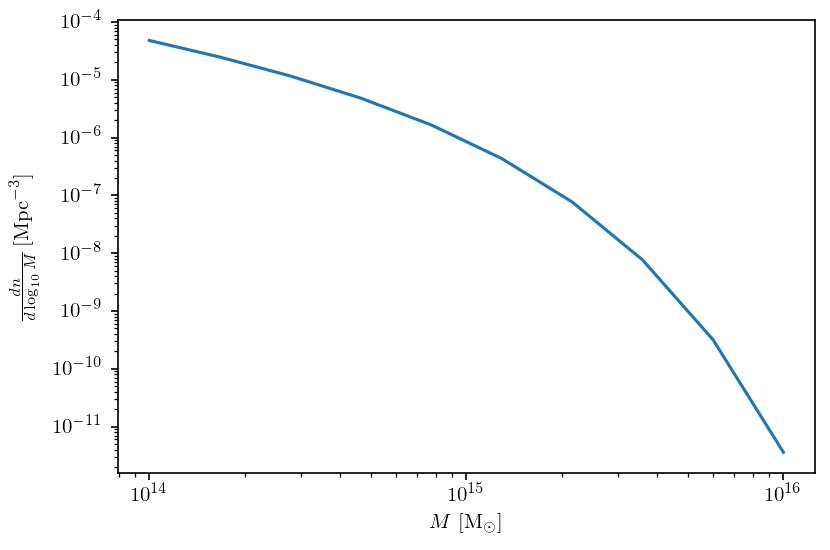

In [15]:
plt.figure()
plt.ylabel(r'$\frac{dn}{d\log_{10}M}\,[{\rm Mpc}^{-3}]$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(masses, hmc[0,:], c=color_map(0))

## Set up simulator

In [16]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [17]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [18]:
#N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data =  N_countsSimulator.simulation(theta_fiducial, 1)
N_counts_data

array([20104, 61296, 78932, 70436, 50010,  2619,  6222,  5741,  3576,
        1761,   103,   162,    78,    43,     8])

In [19]:
n_params = len(theta_fiducial)
print(n_params)
n_data_points = len(N_counts_data)
print(n_data_points)

3
15


## Define ensemble of NDEs

In [20]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Attempt 2

In [21]:
DelfiEnsemble = delfi.Delfi(N_counts_data, prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_tinker_3000sims/")

In [22]:
n_initial = 100 
n_batch = 100 
n_populations = 30 

Sampling approximate posterior...
Done.
Removed no burn in


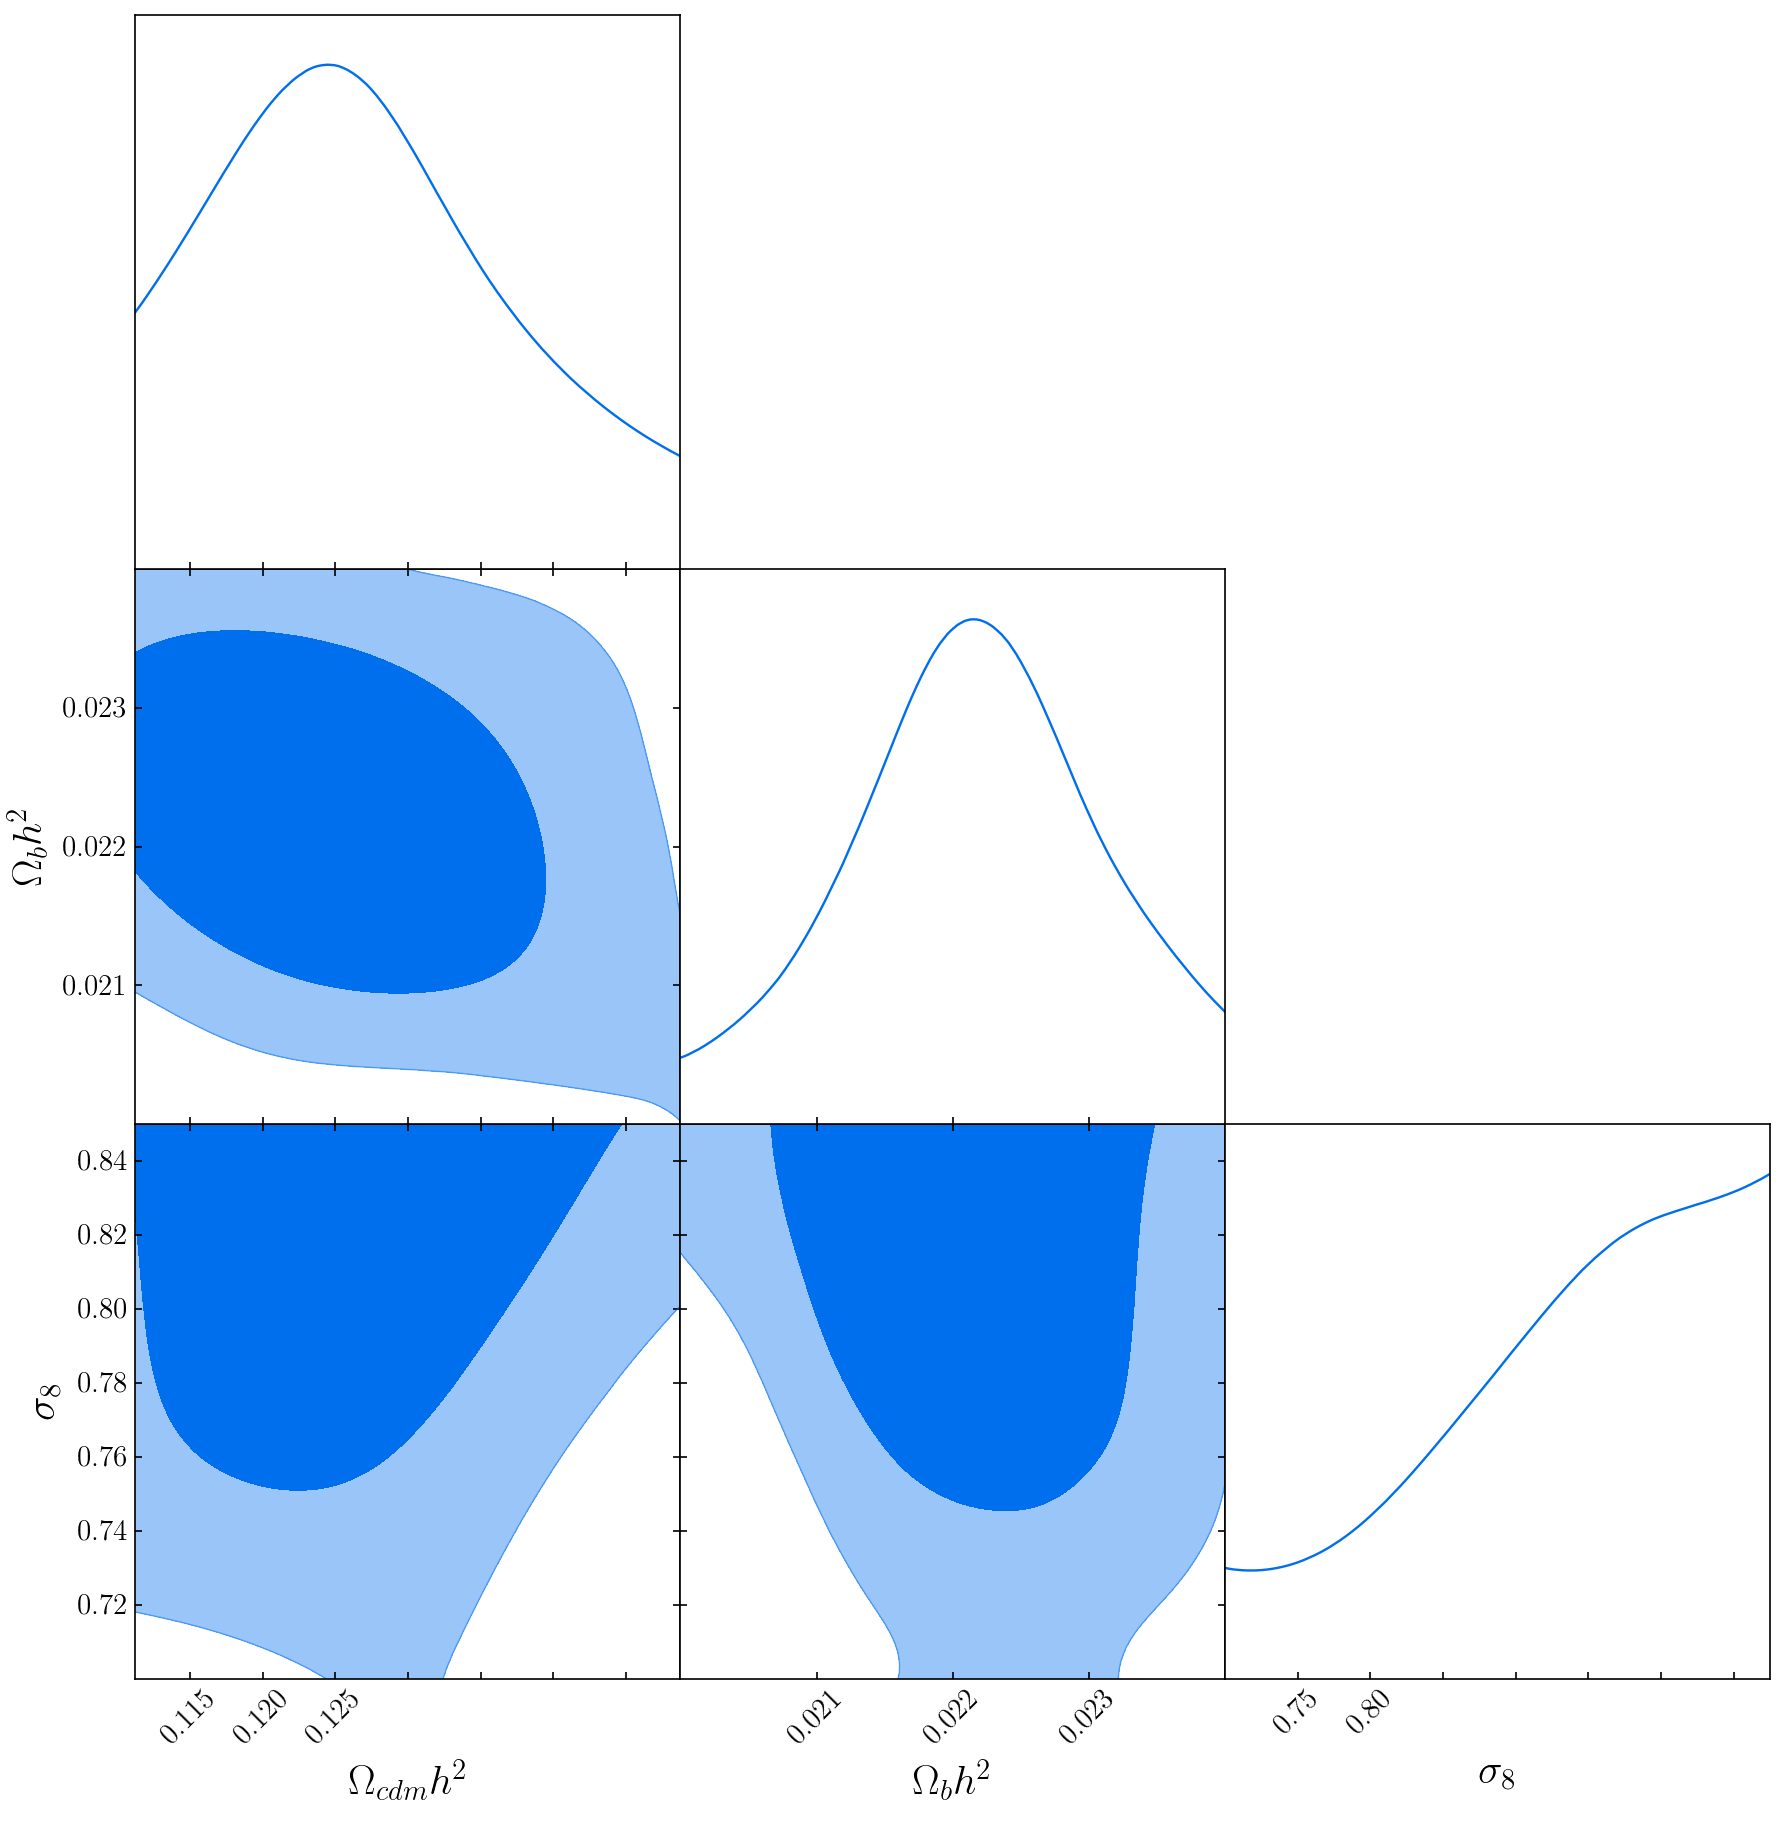

Population 1/30
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


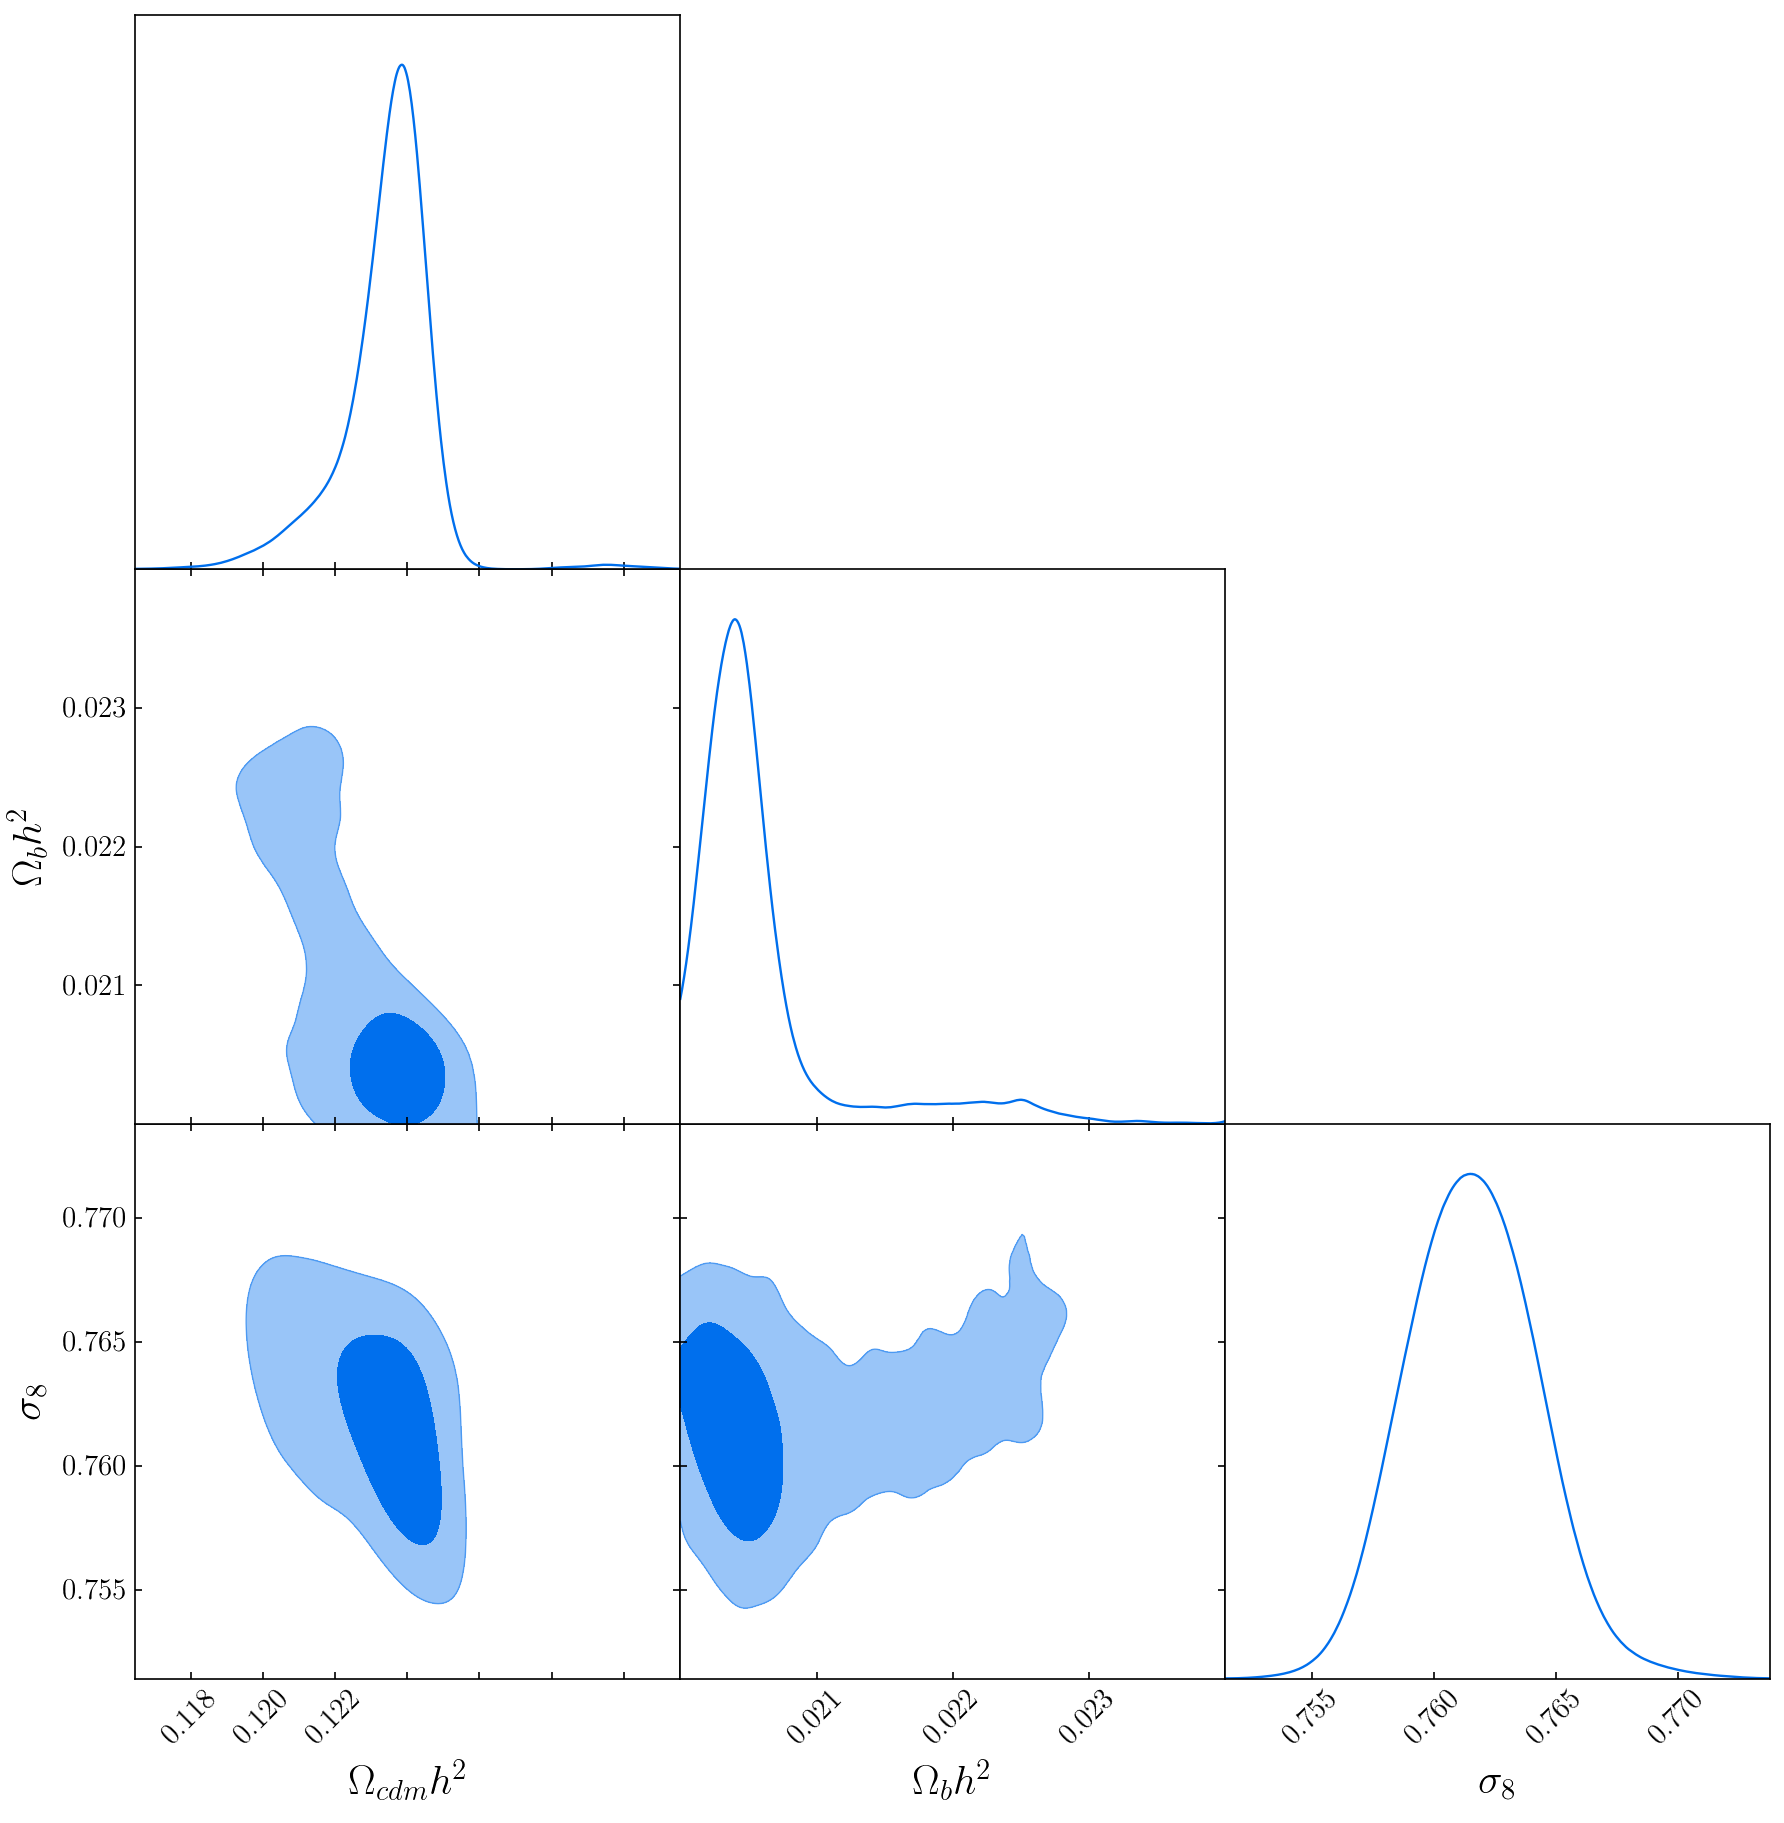

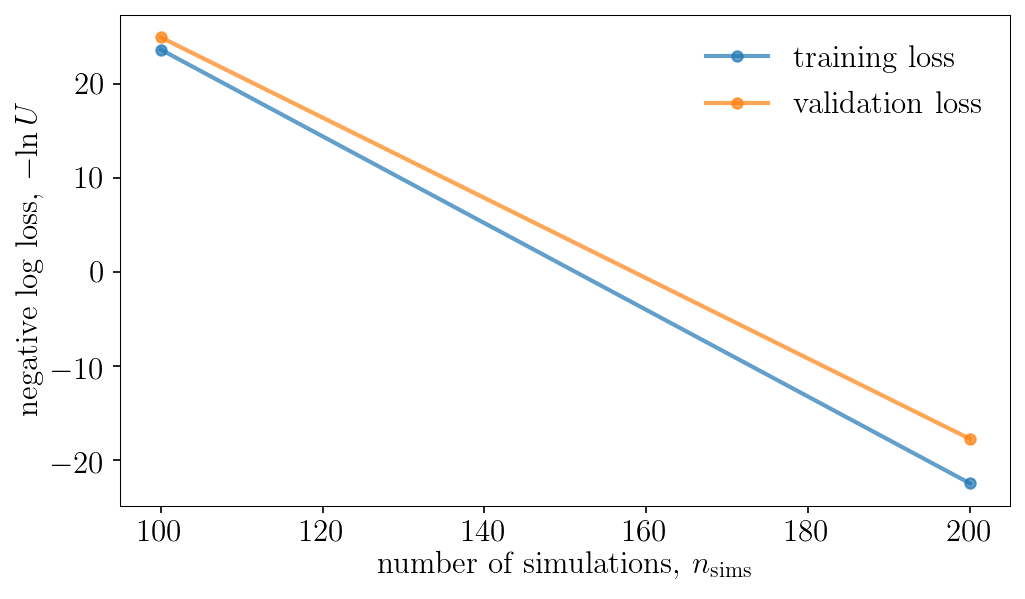

Population 2/30
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


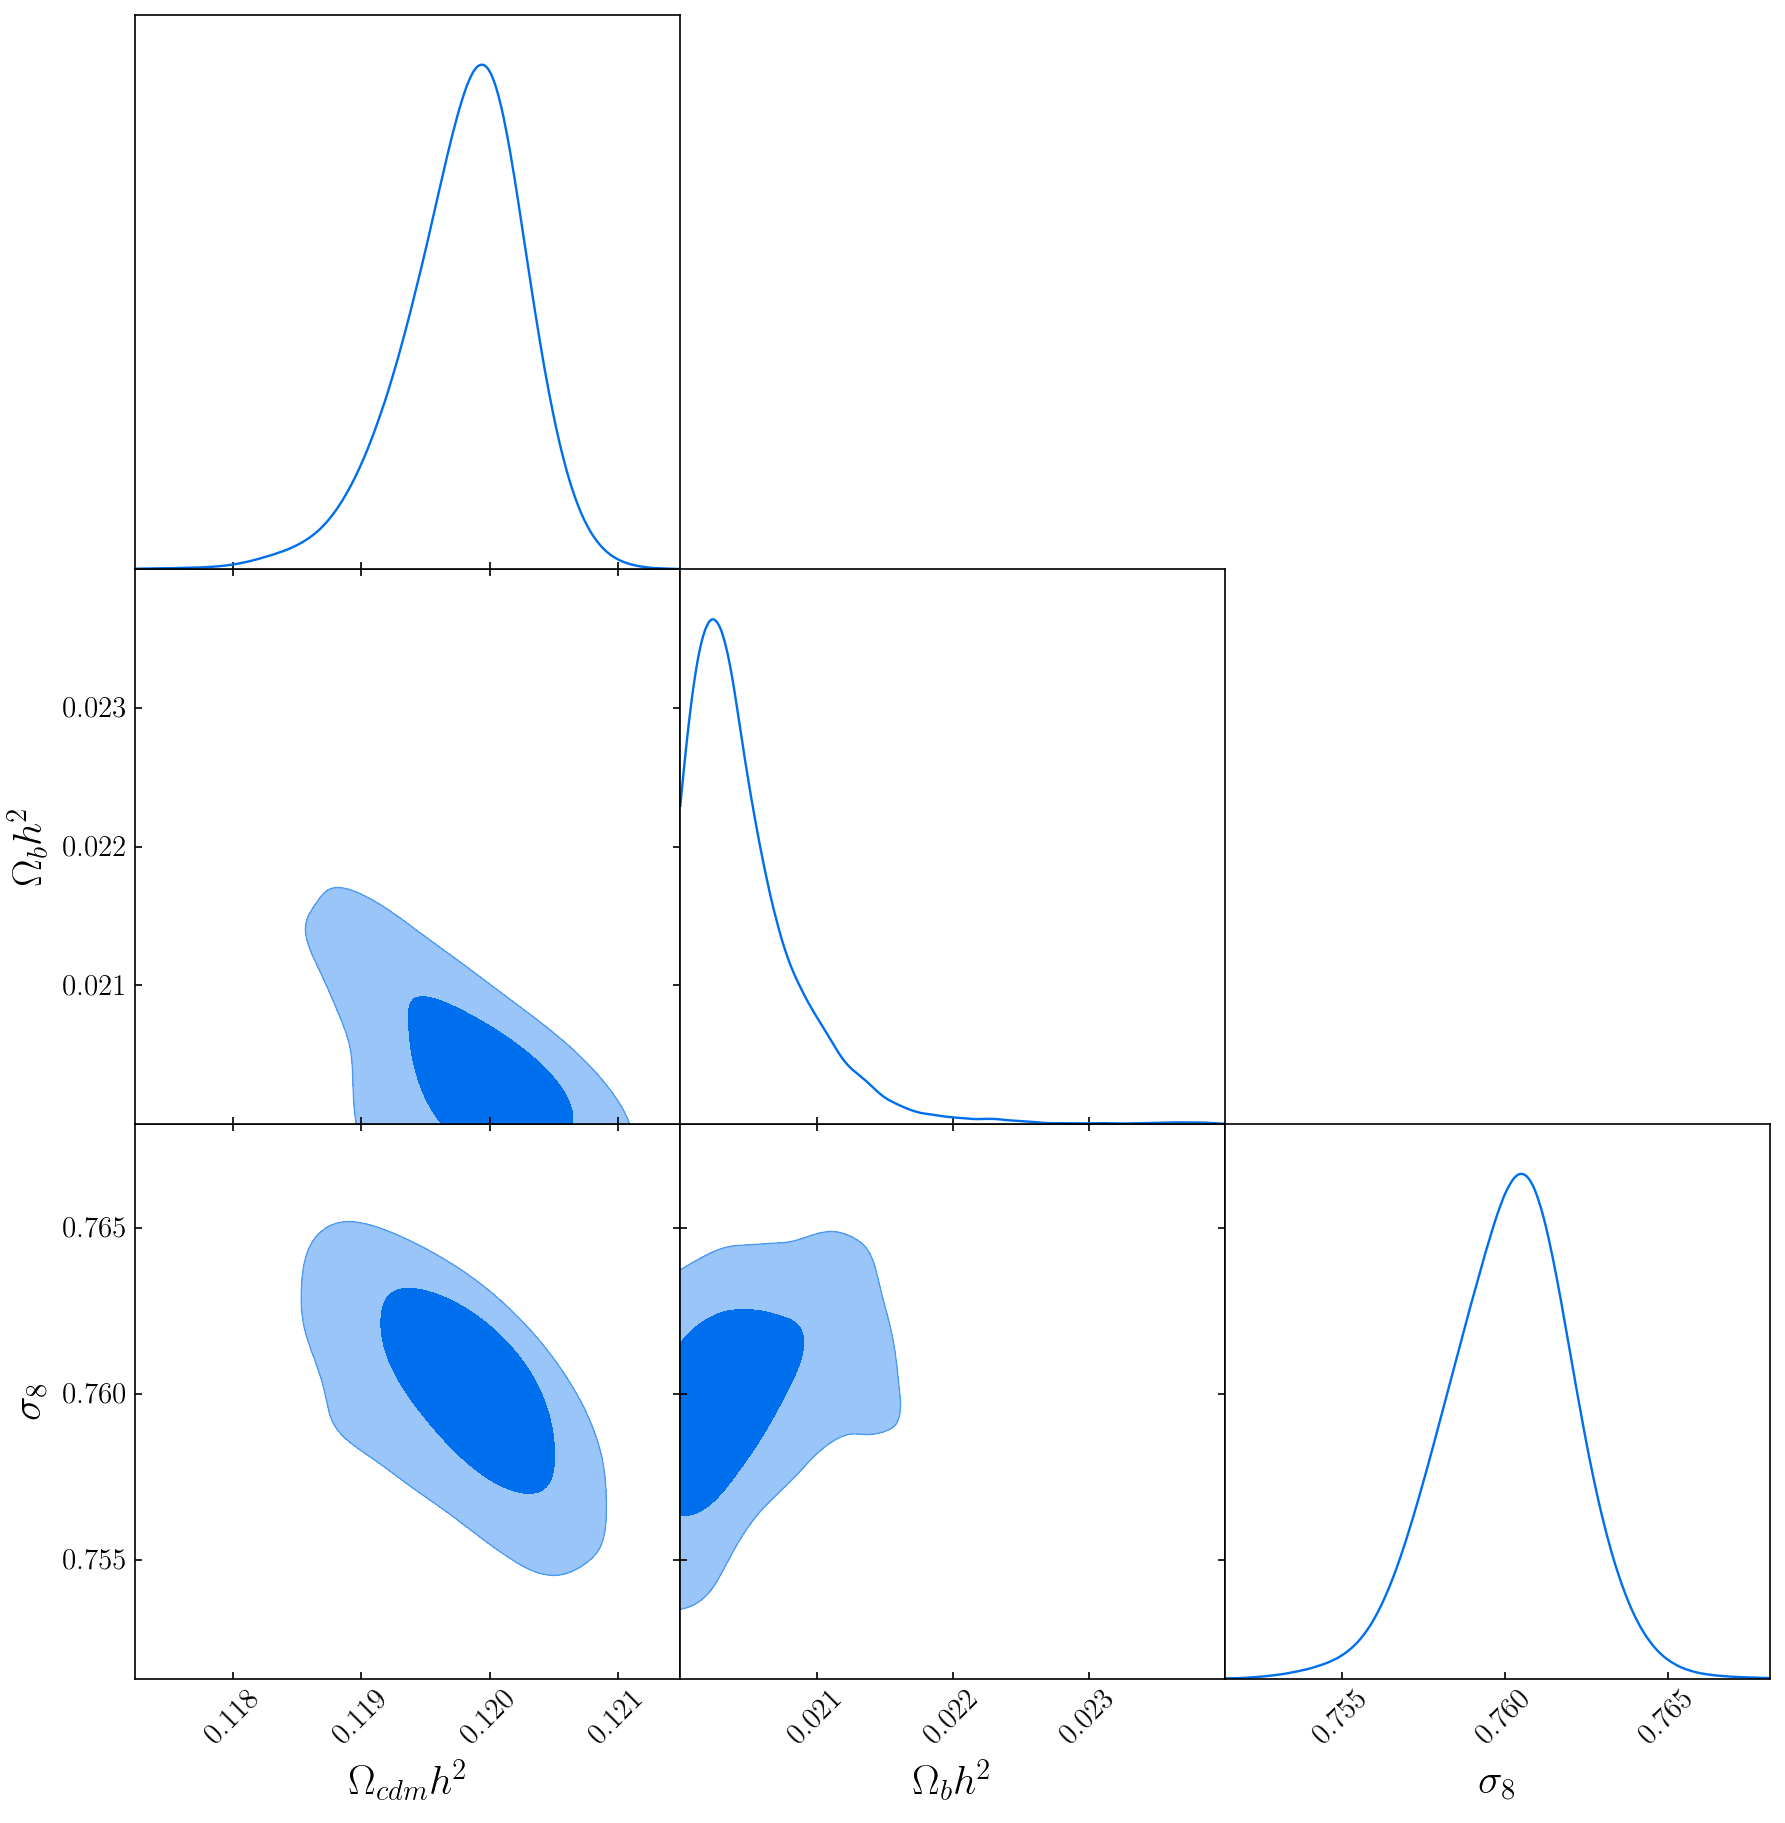

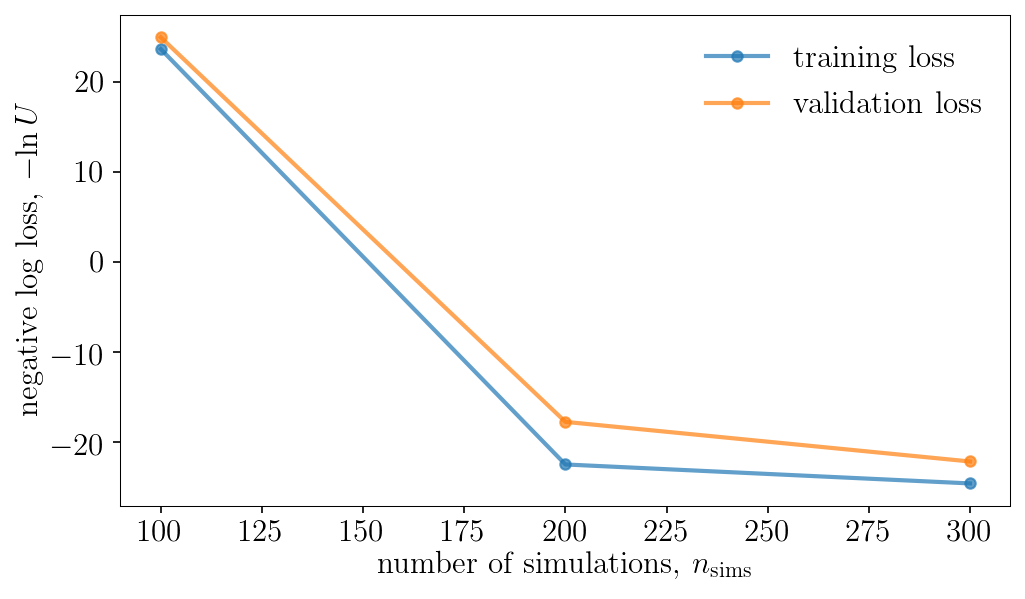

Population 3/30
Sampling proposal density...
Done.


Sampling approximate posterior...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


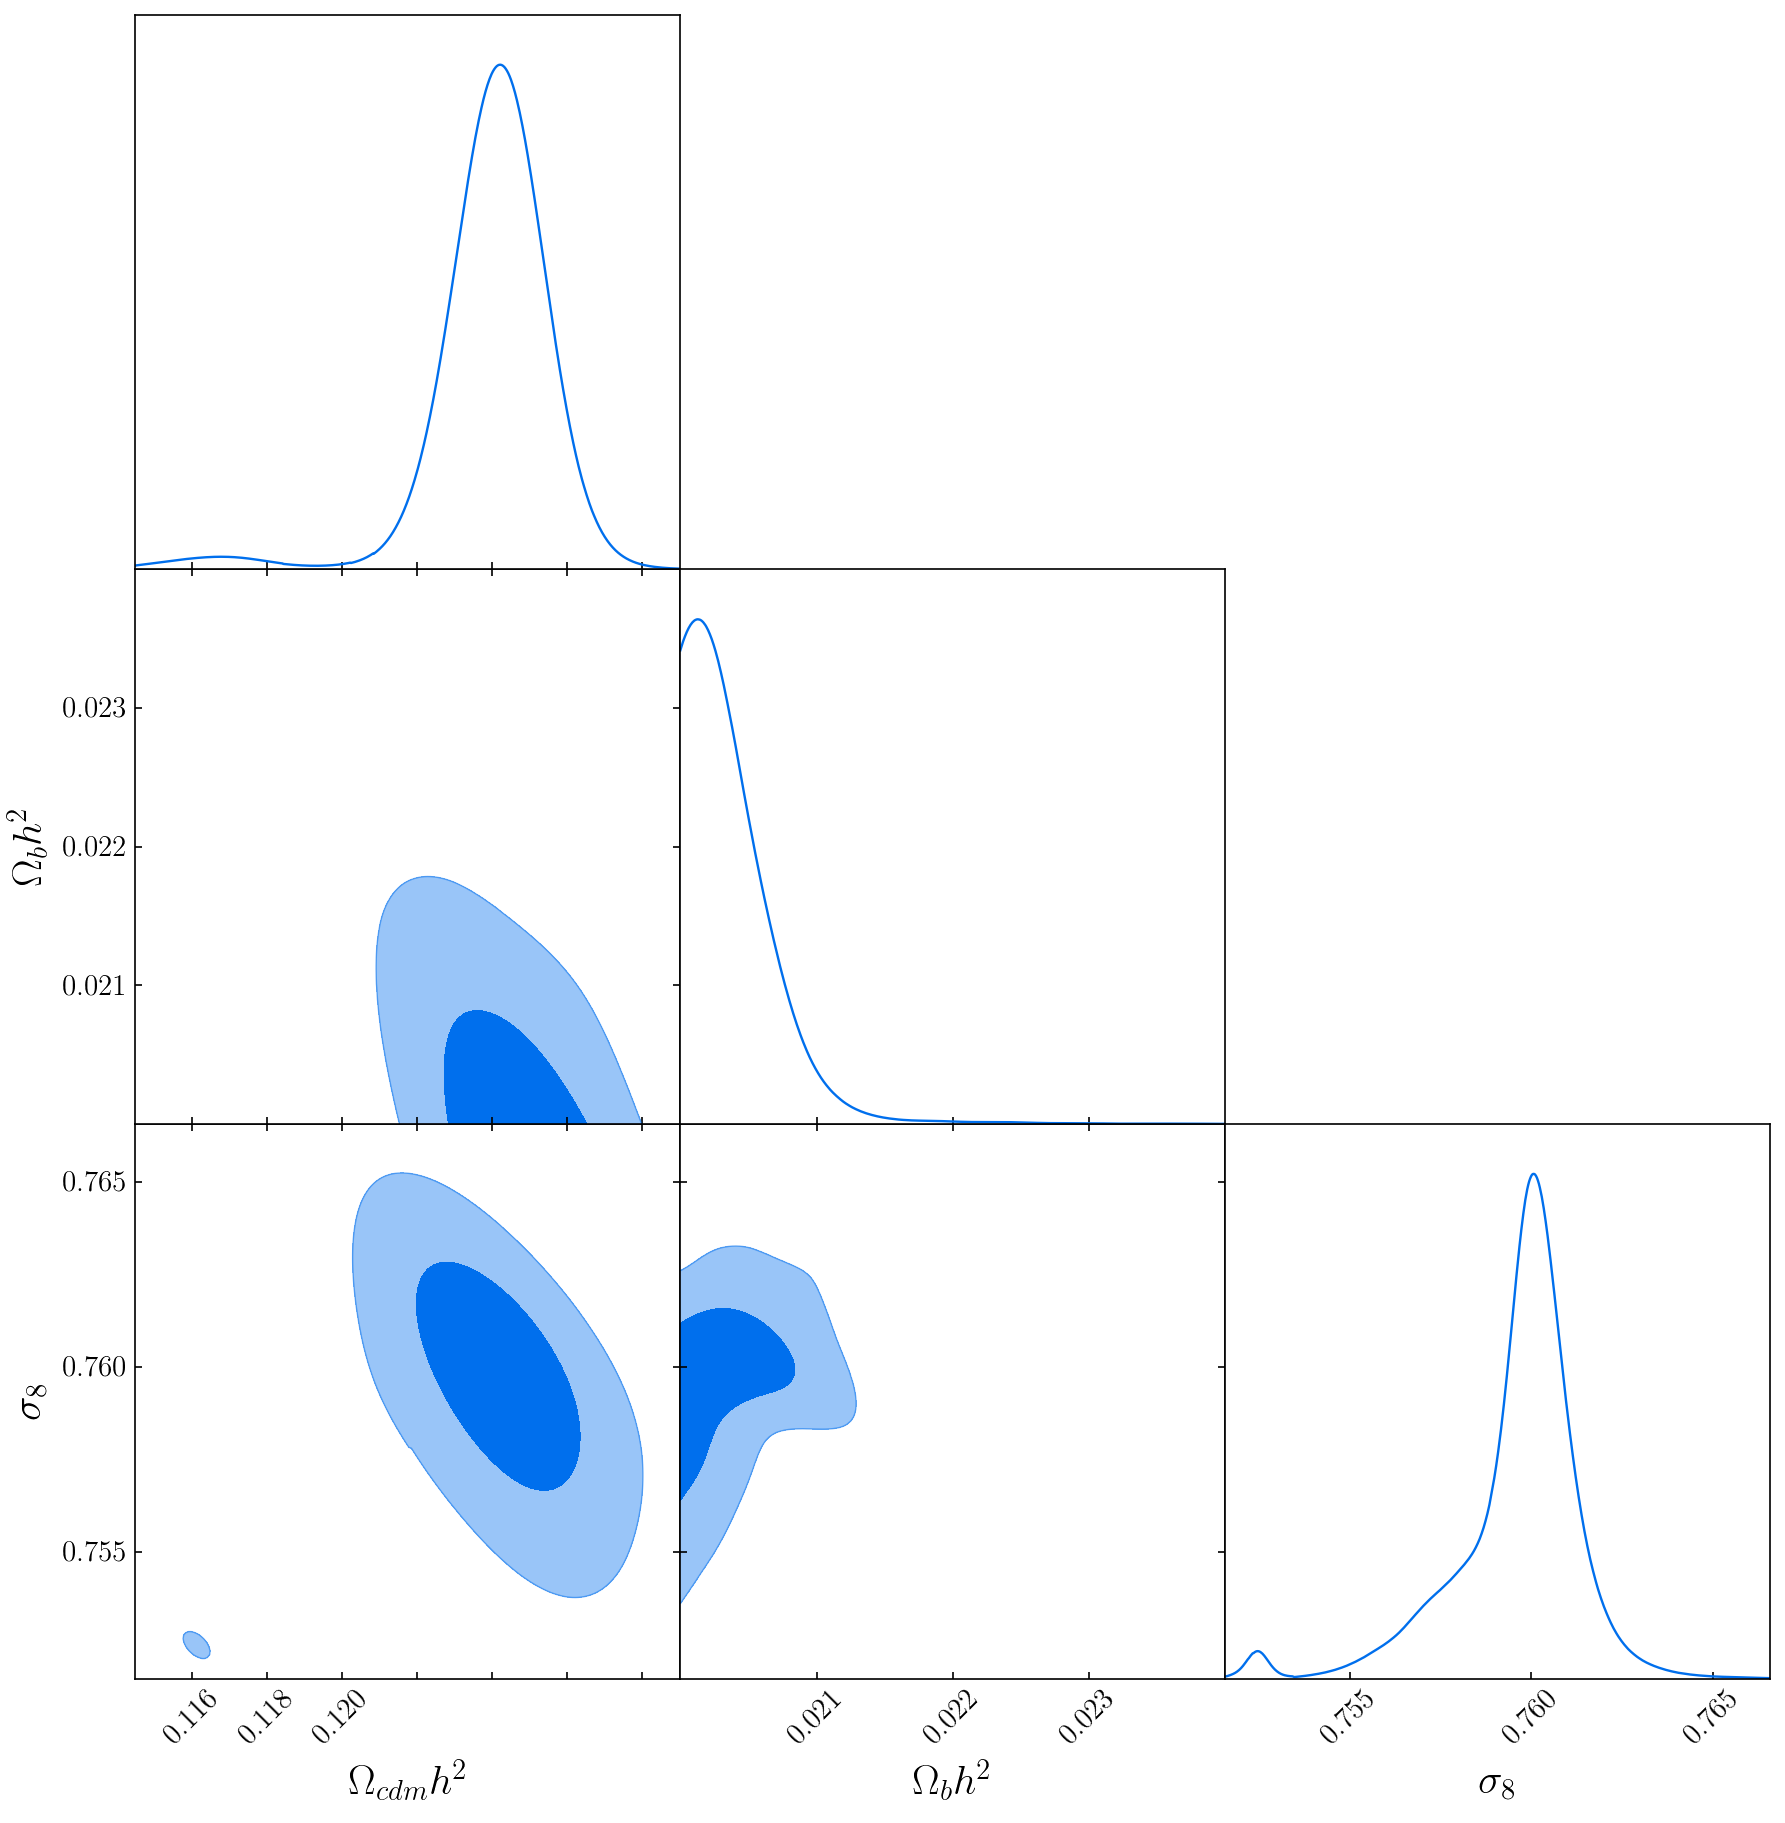

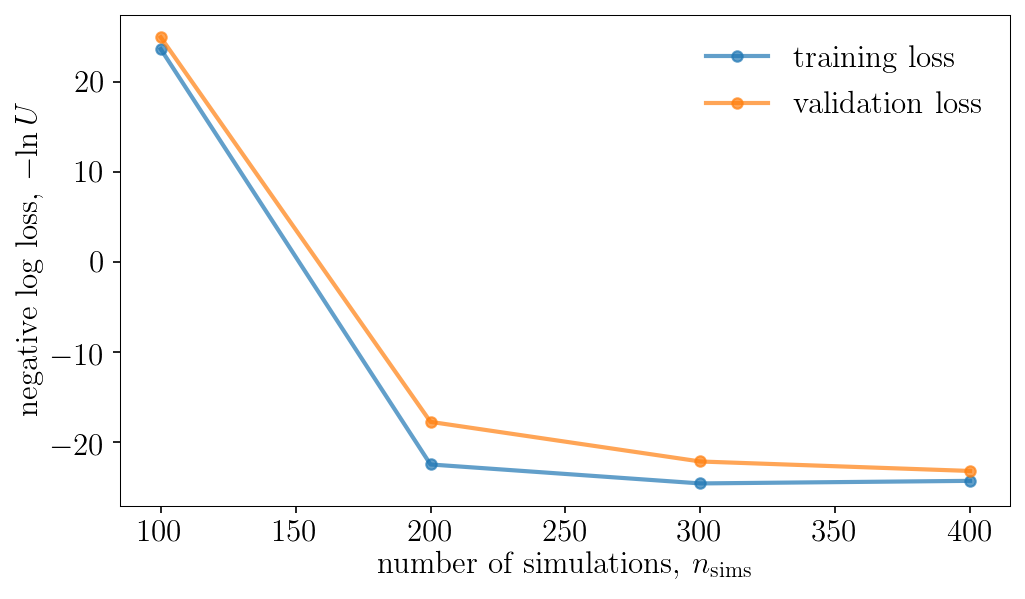

Population 4/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


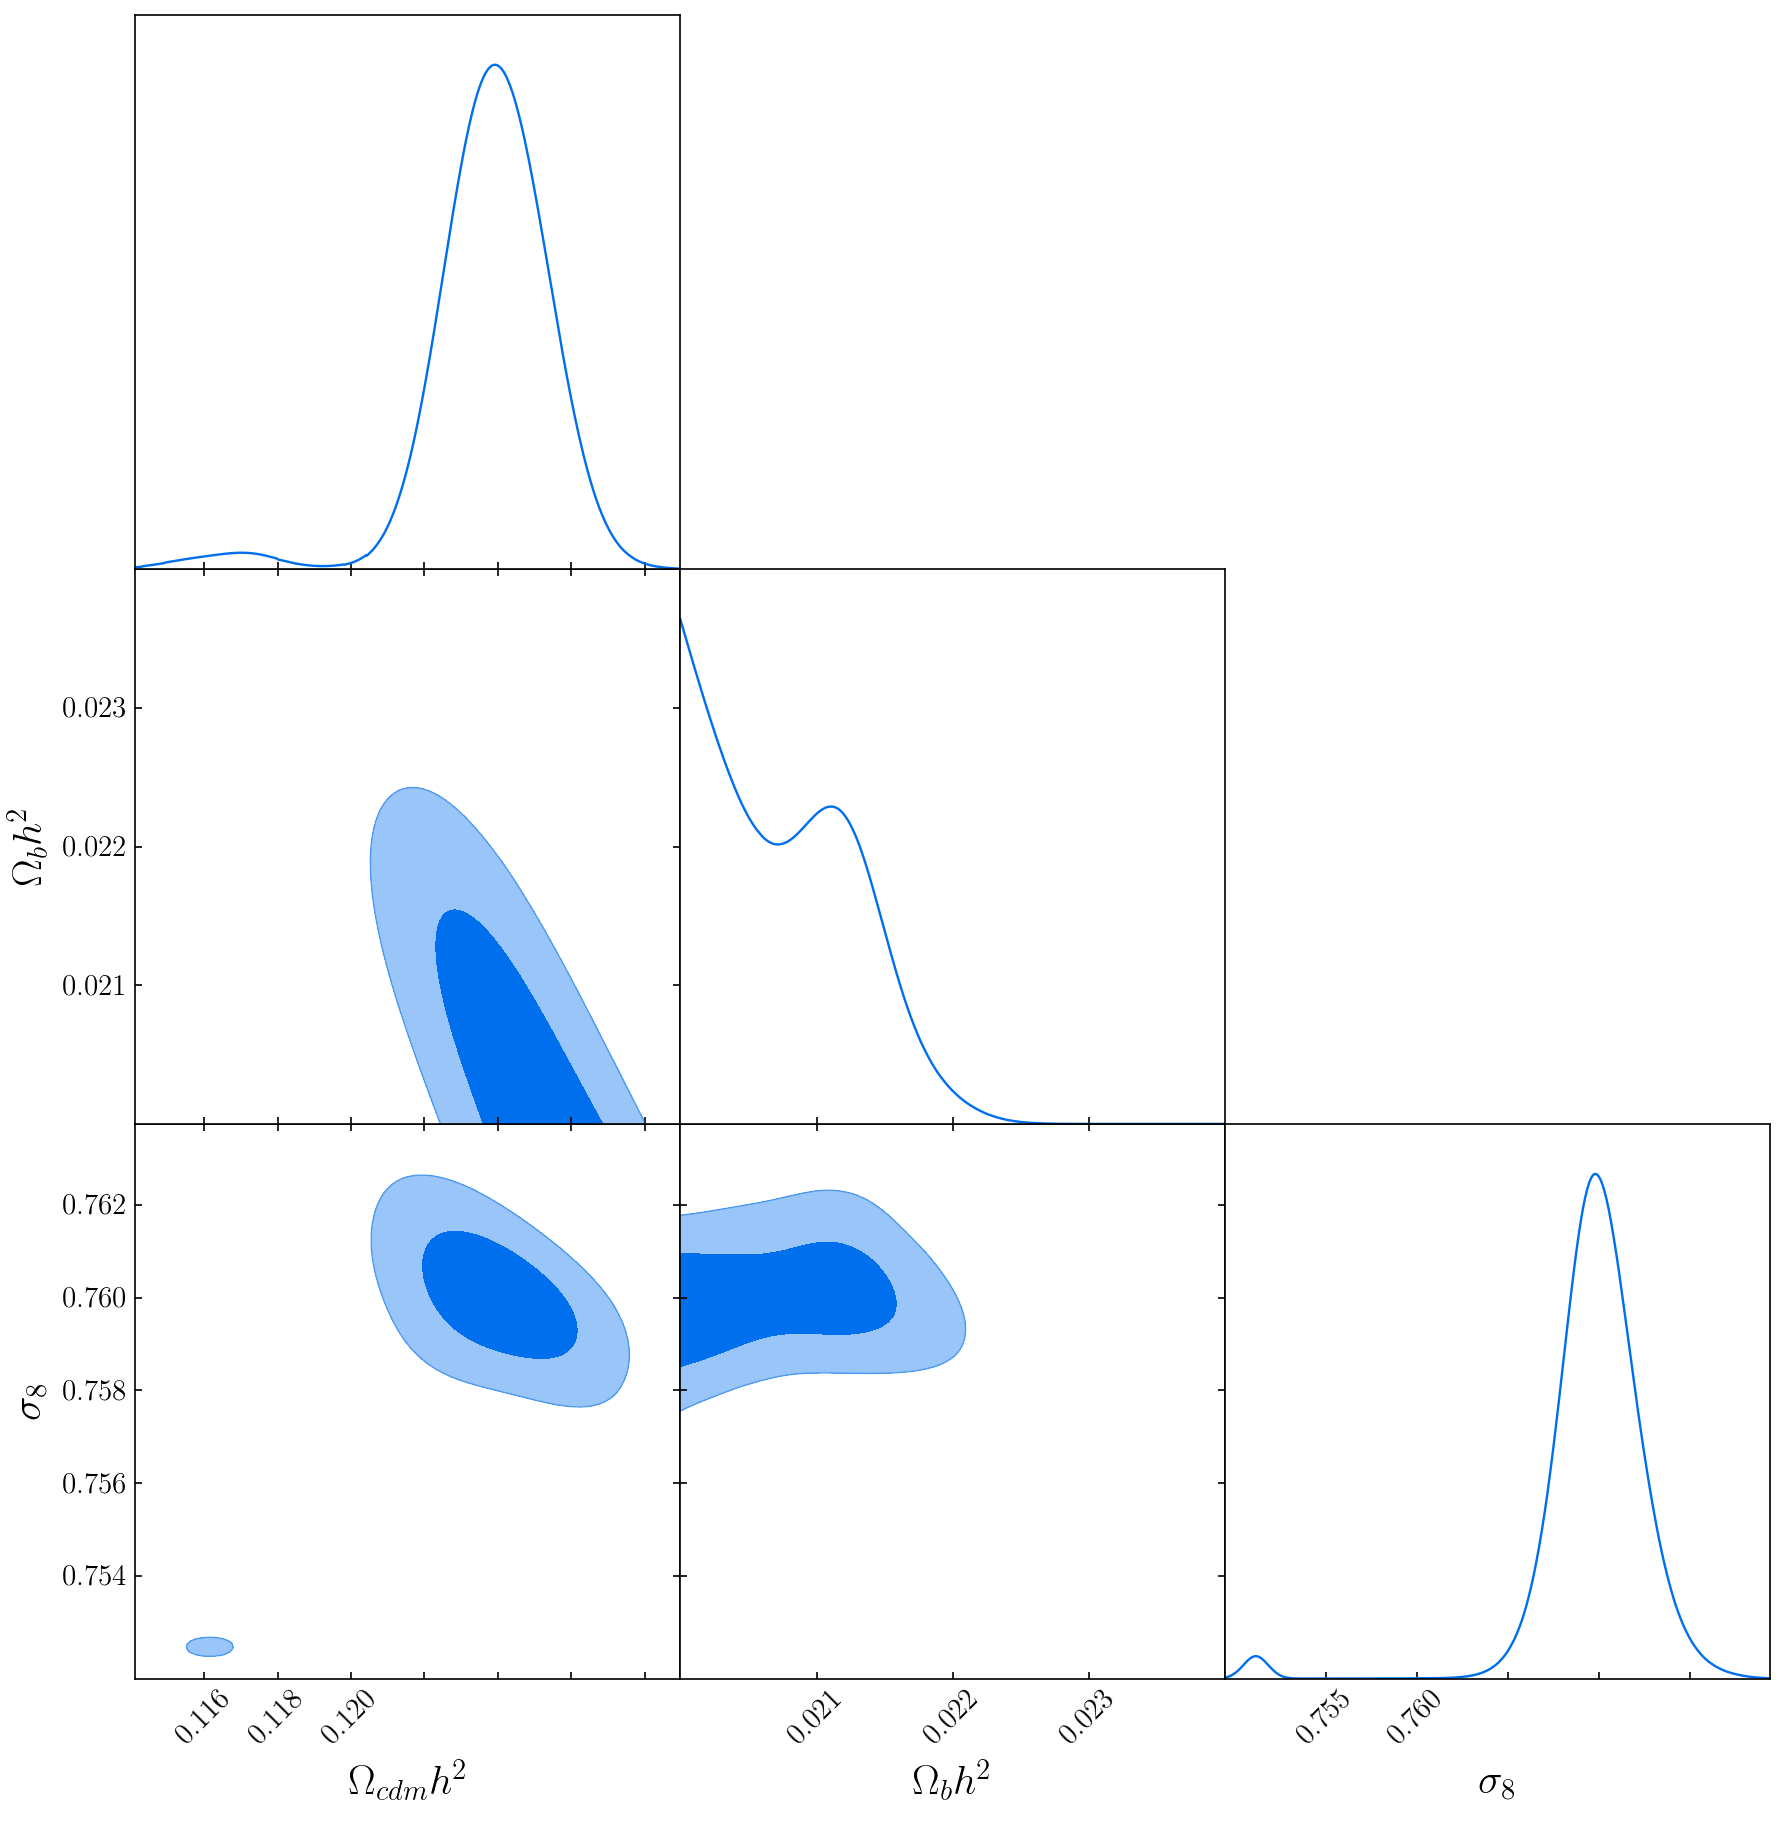

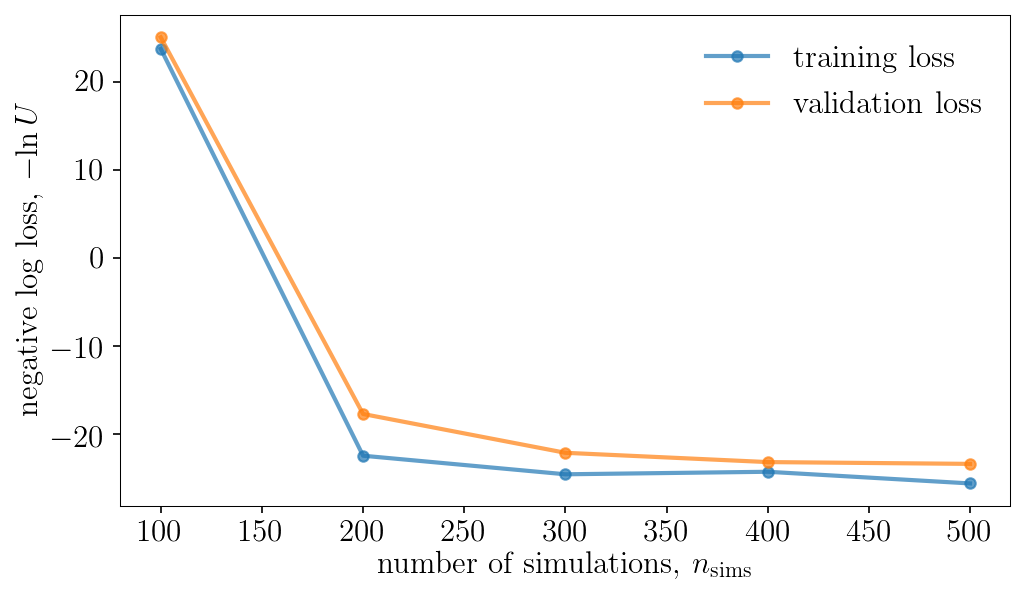

Population 5/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


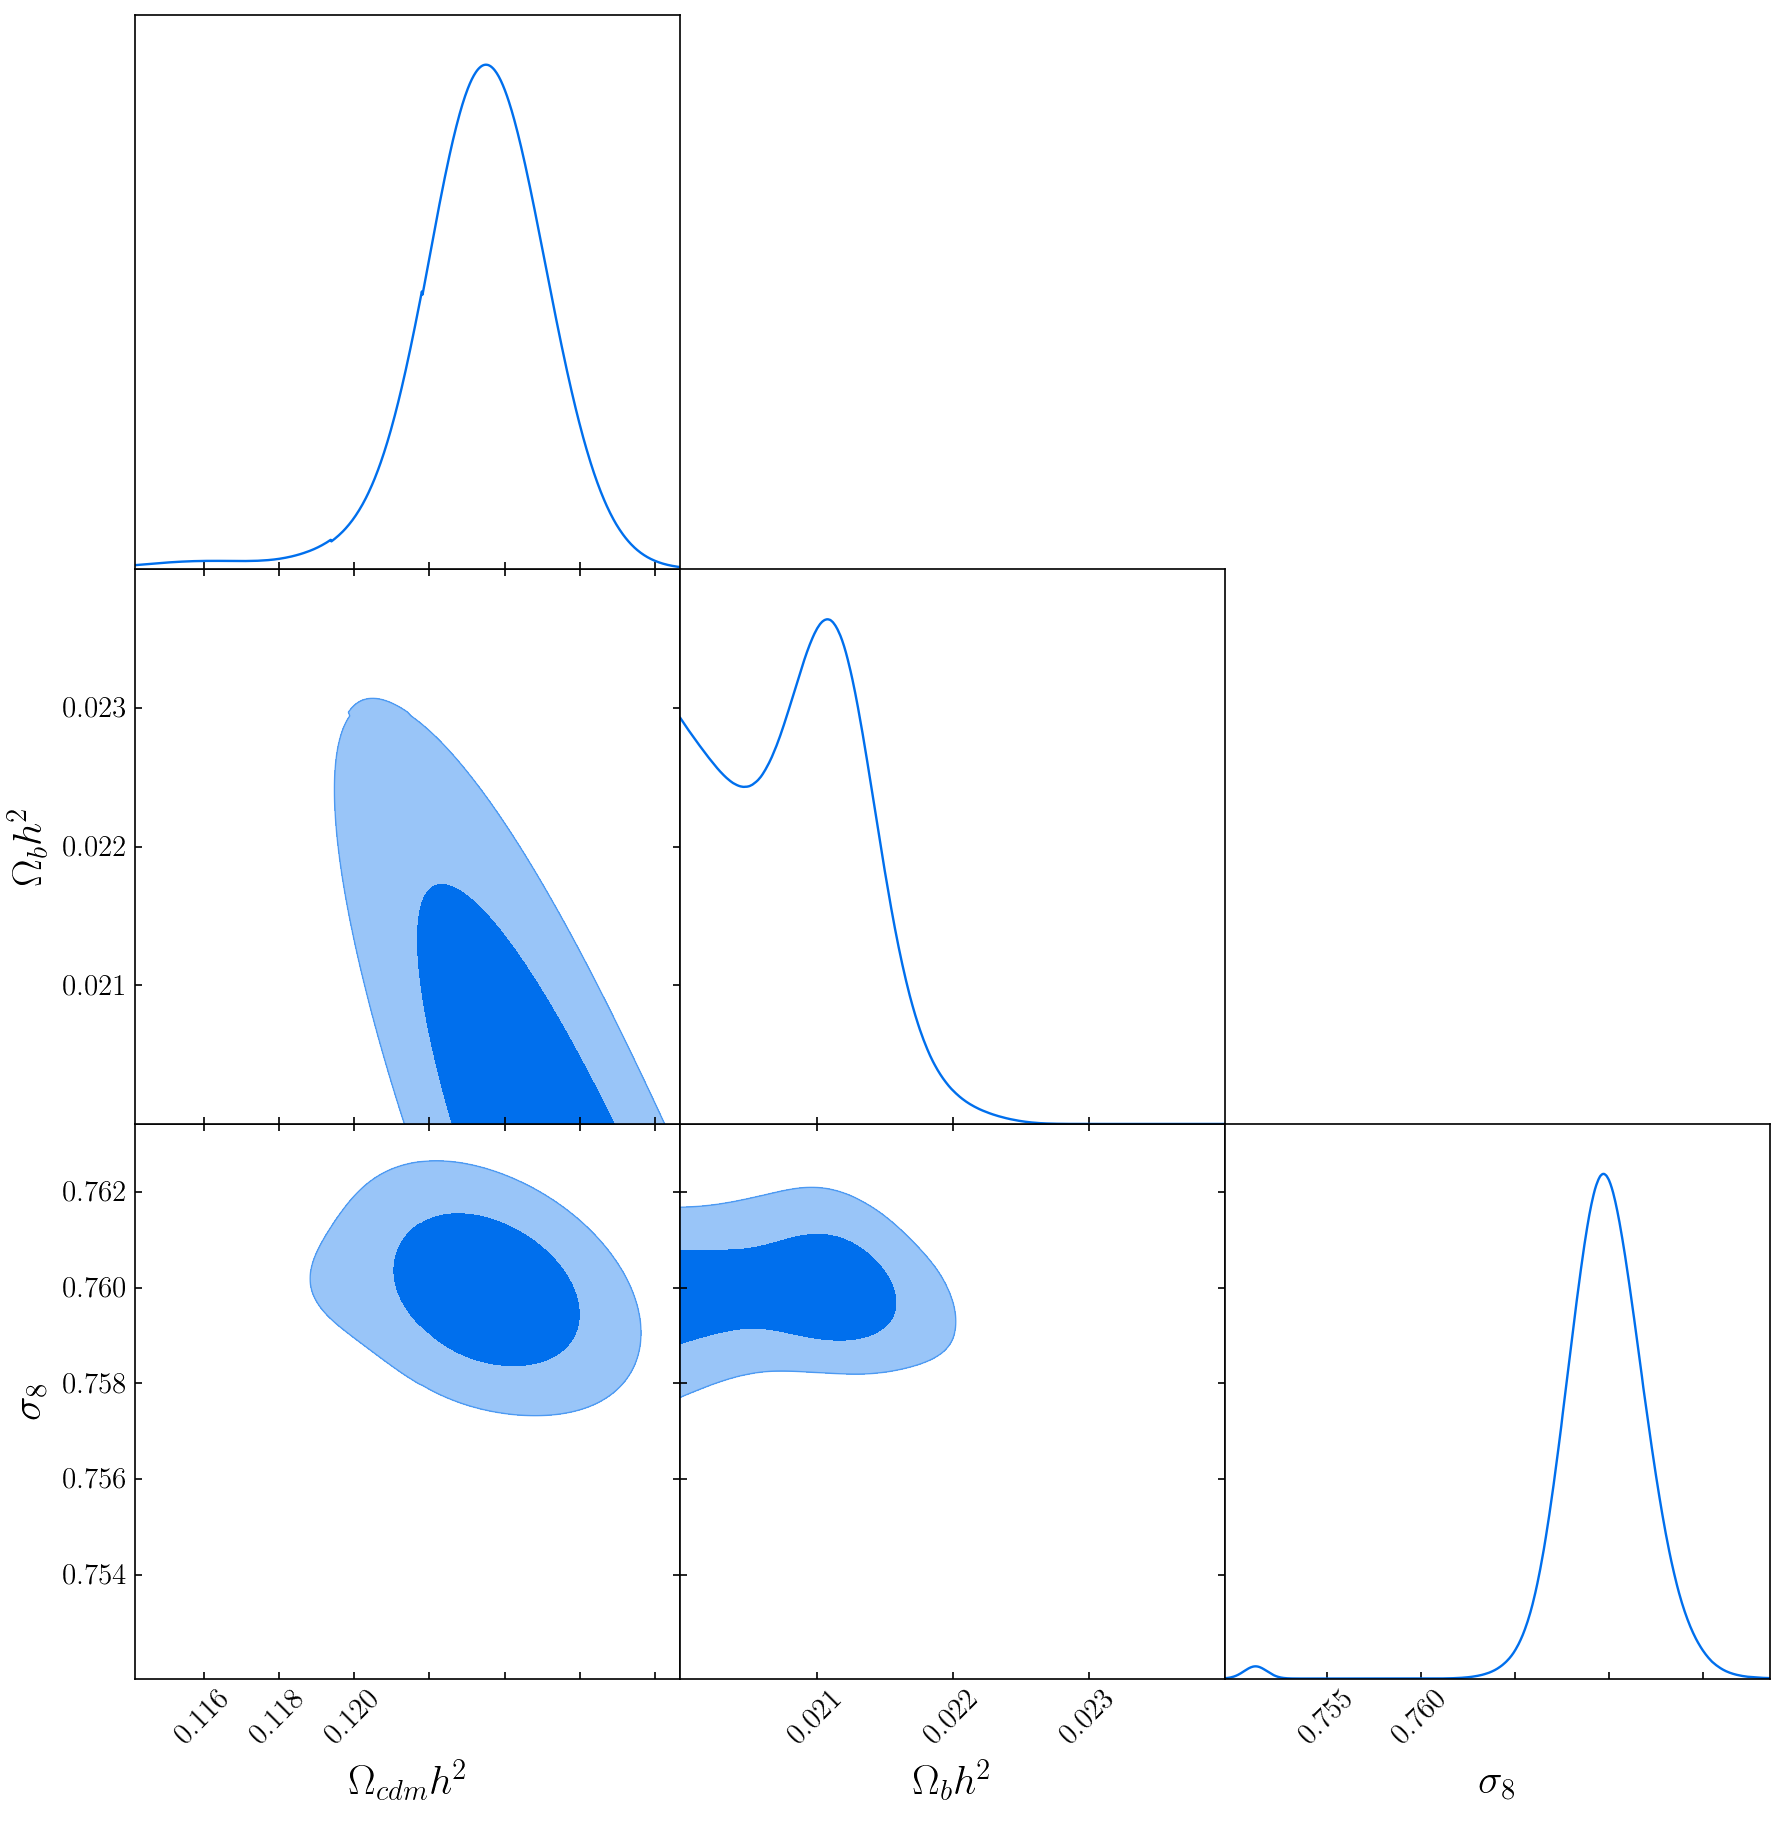

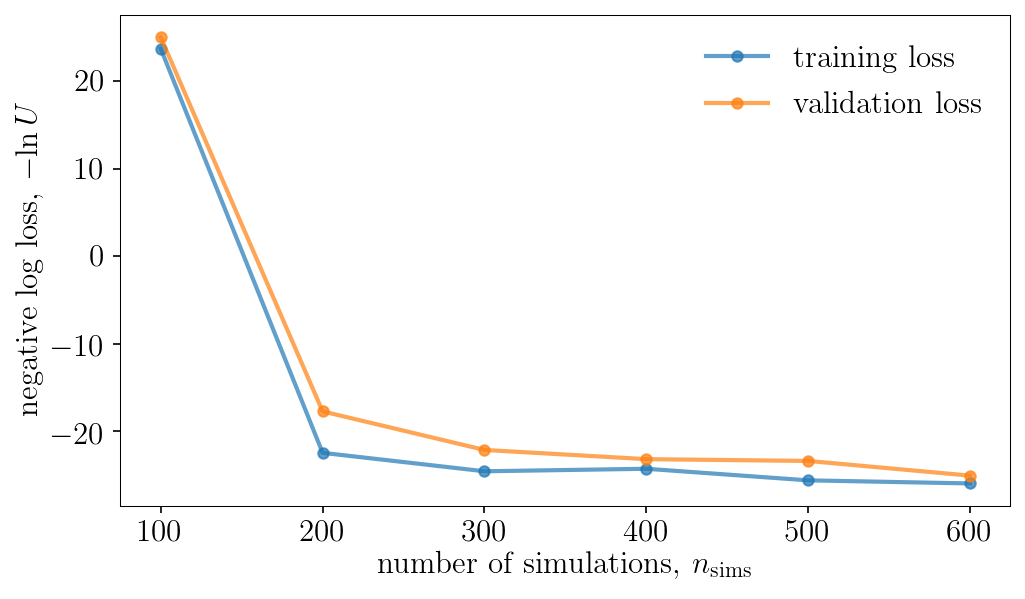

Population 6/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


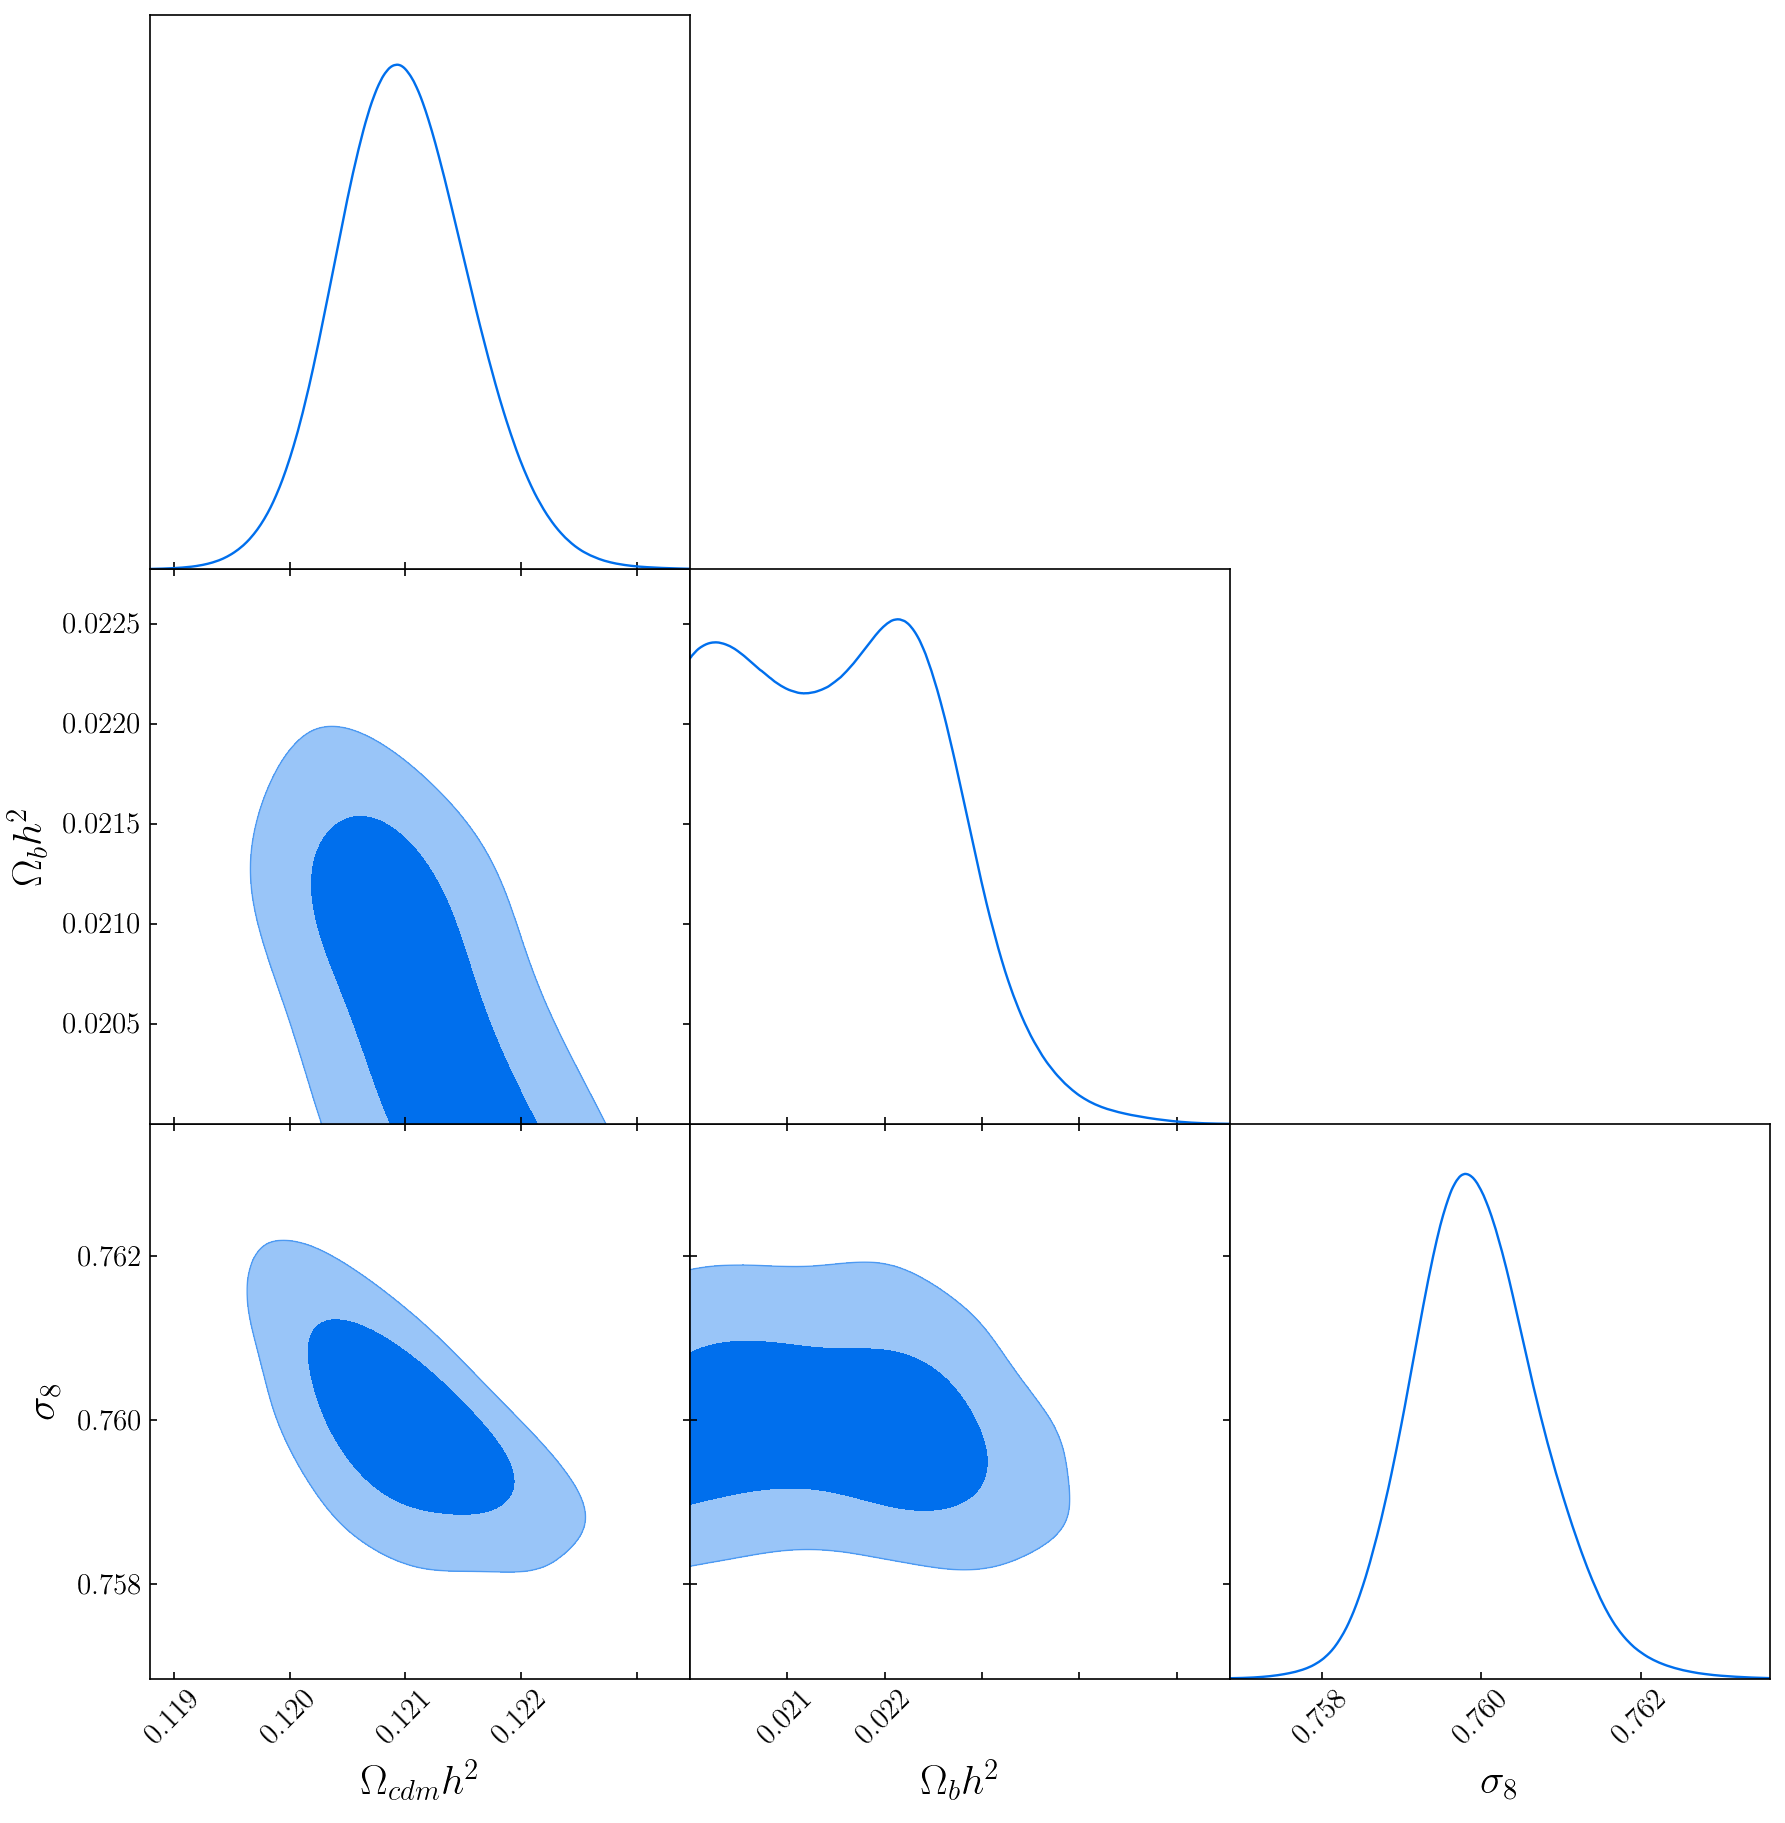

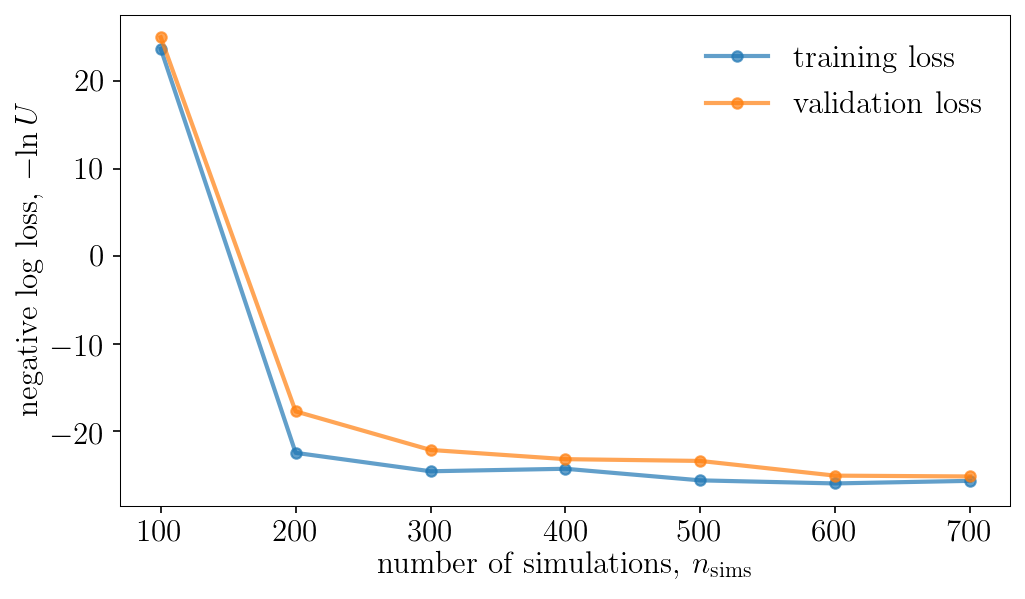

Population 7/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


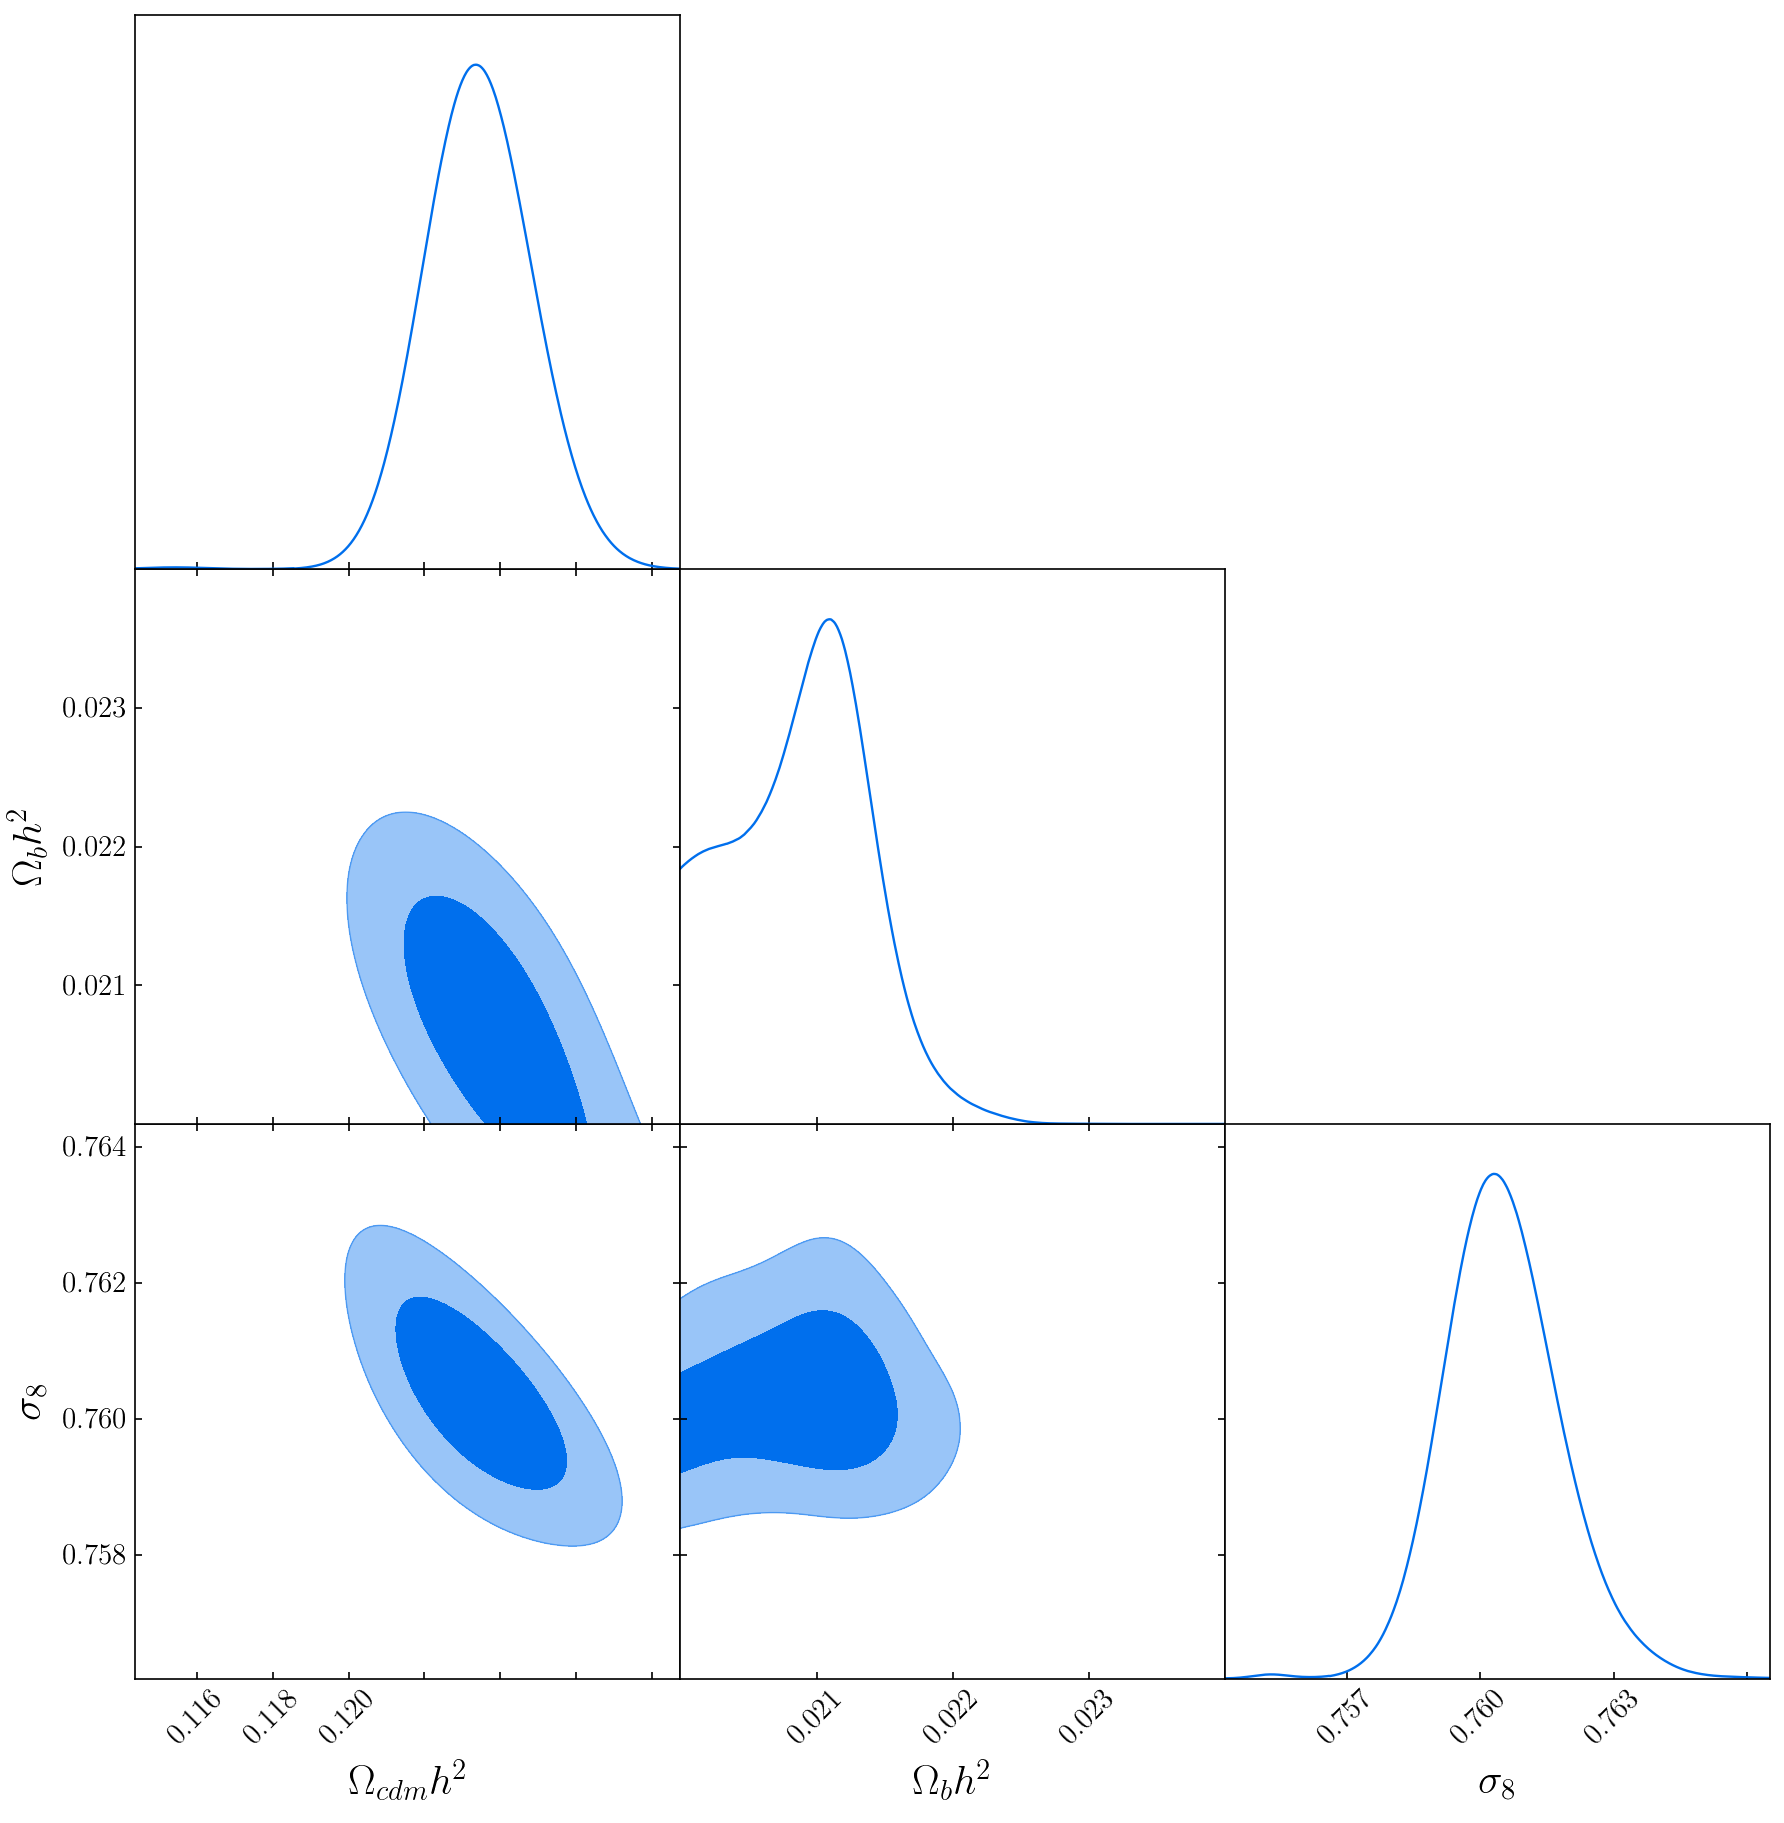

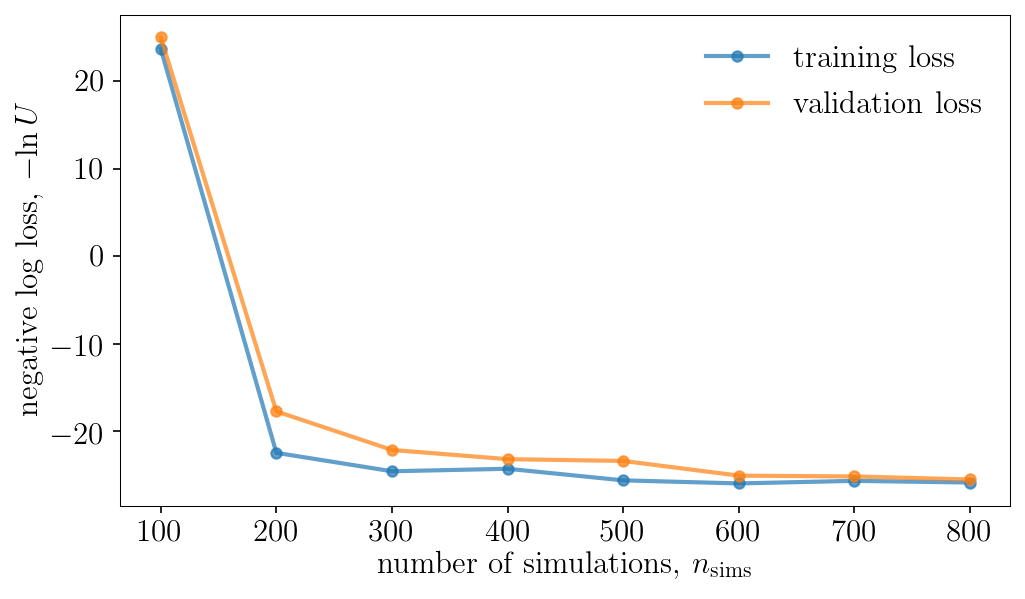

Population 8/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


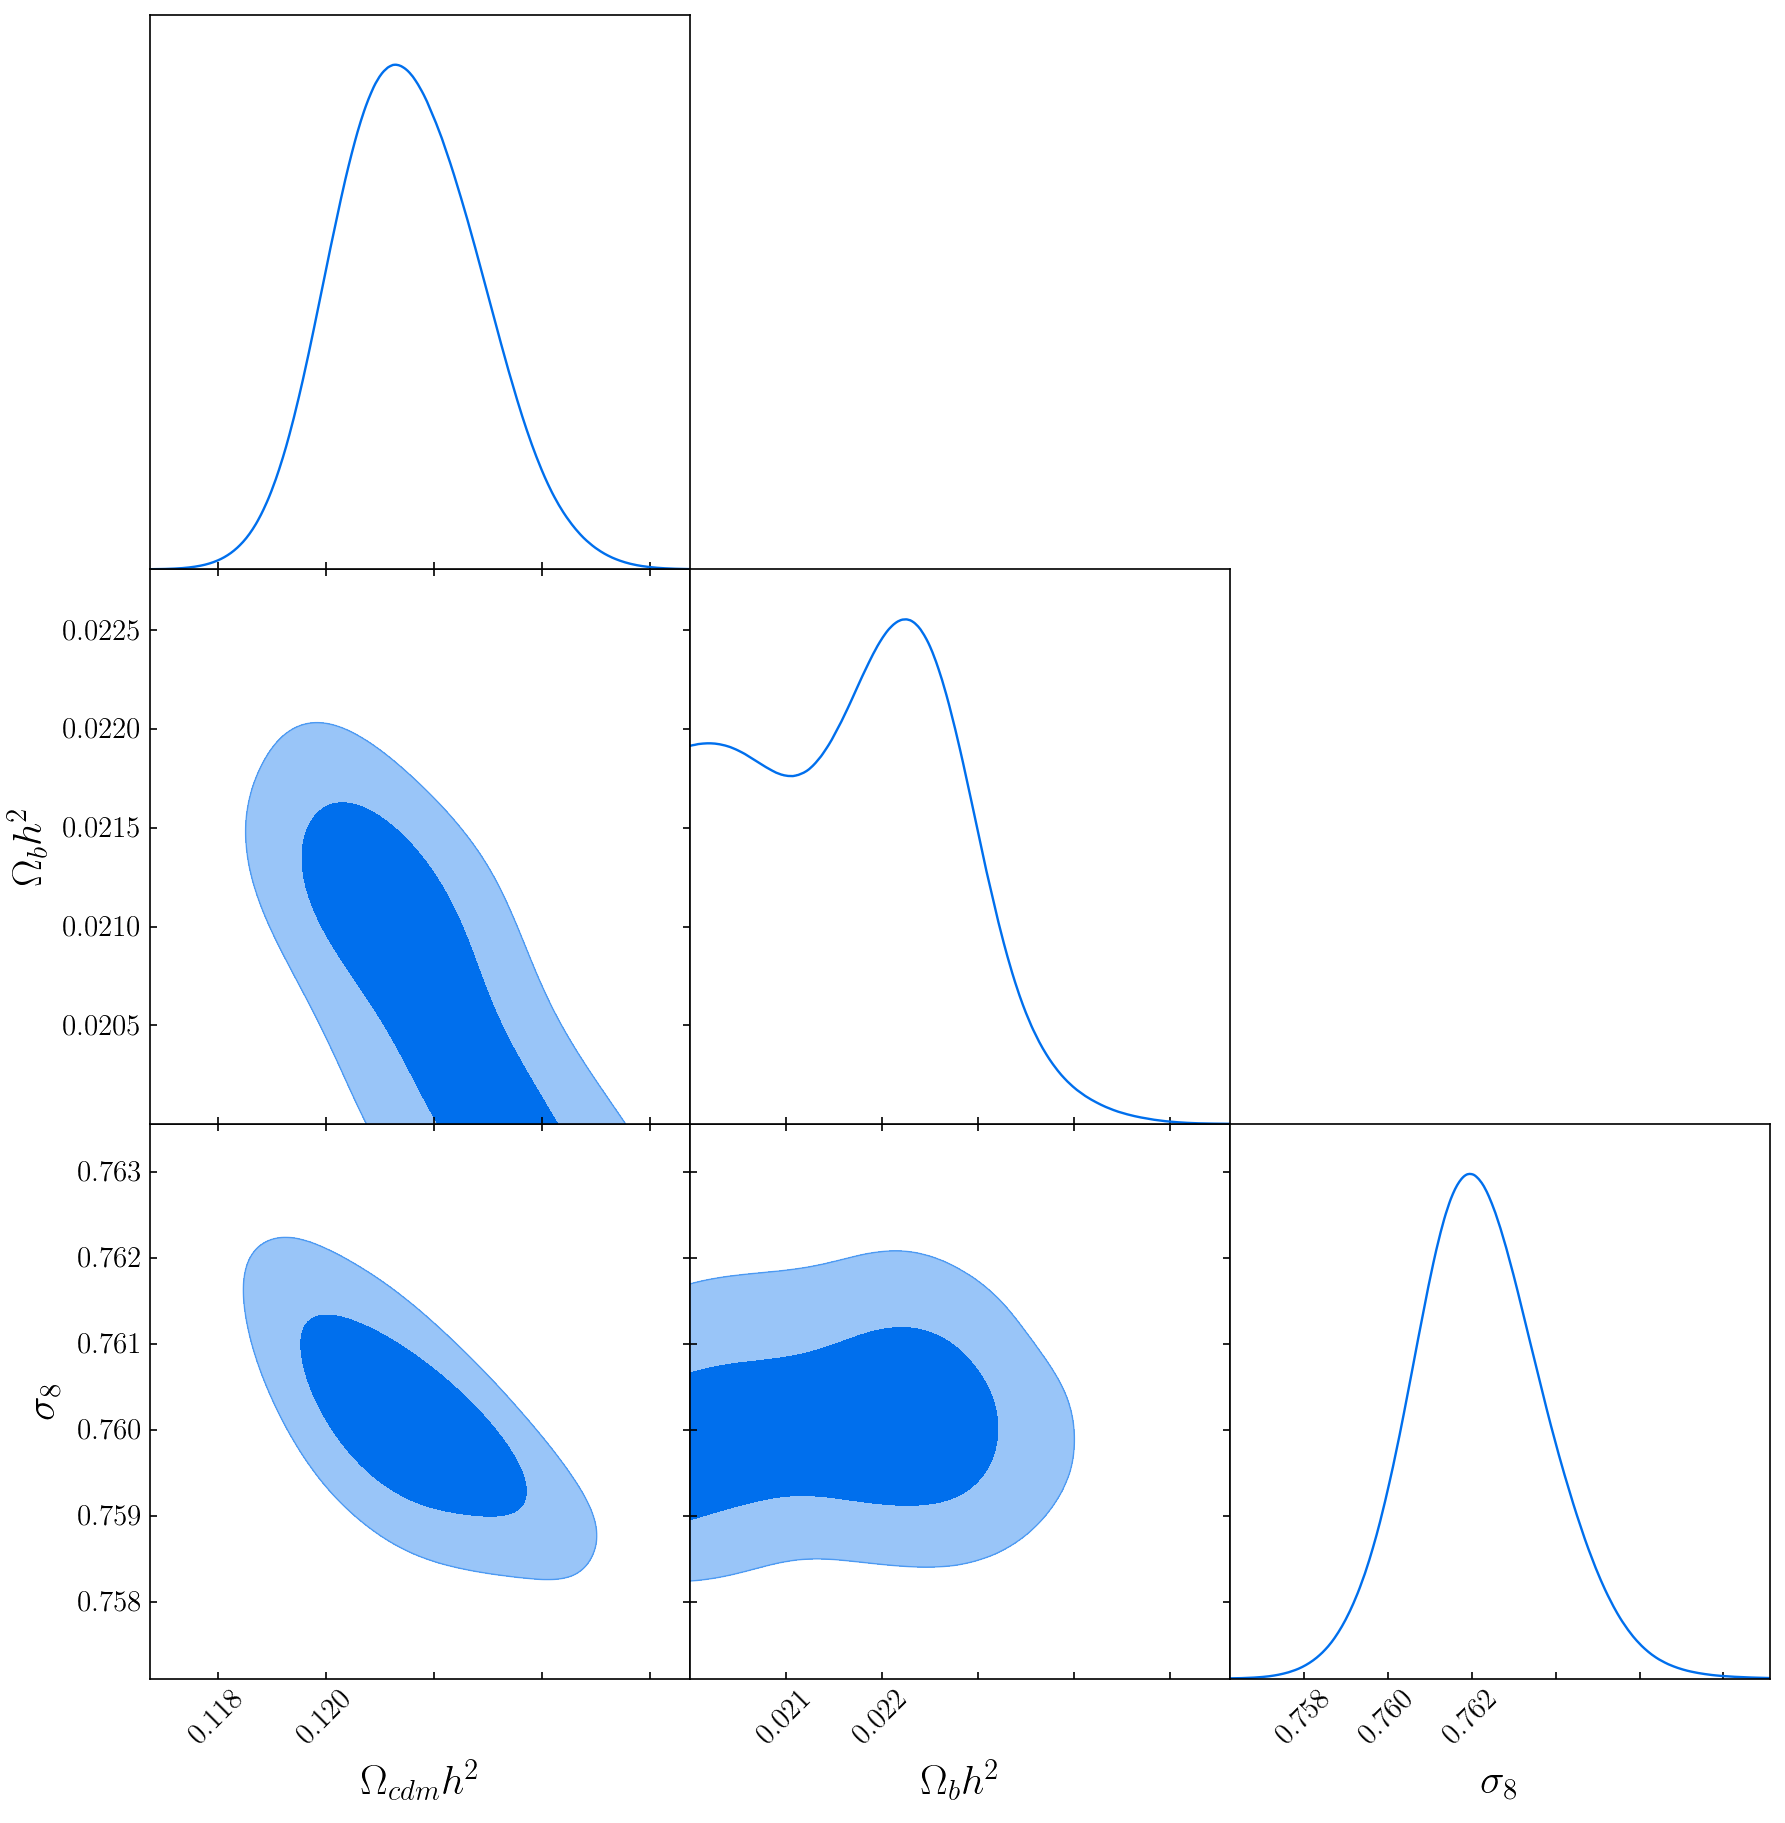

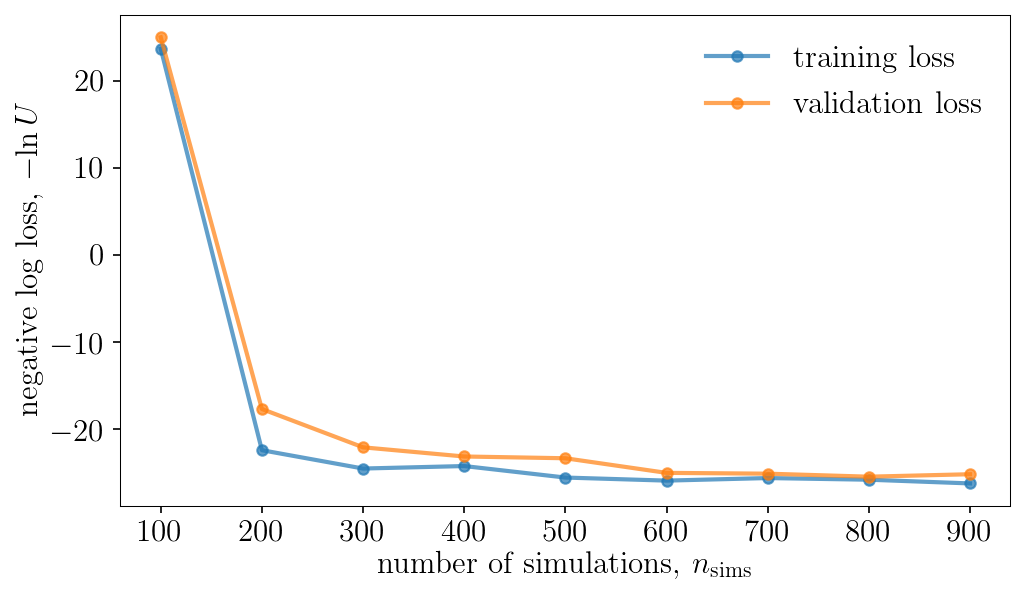

Population 9/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


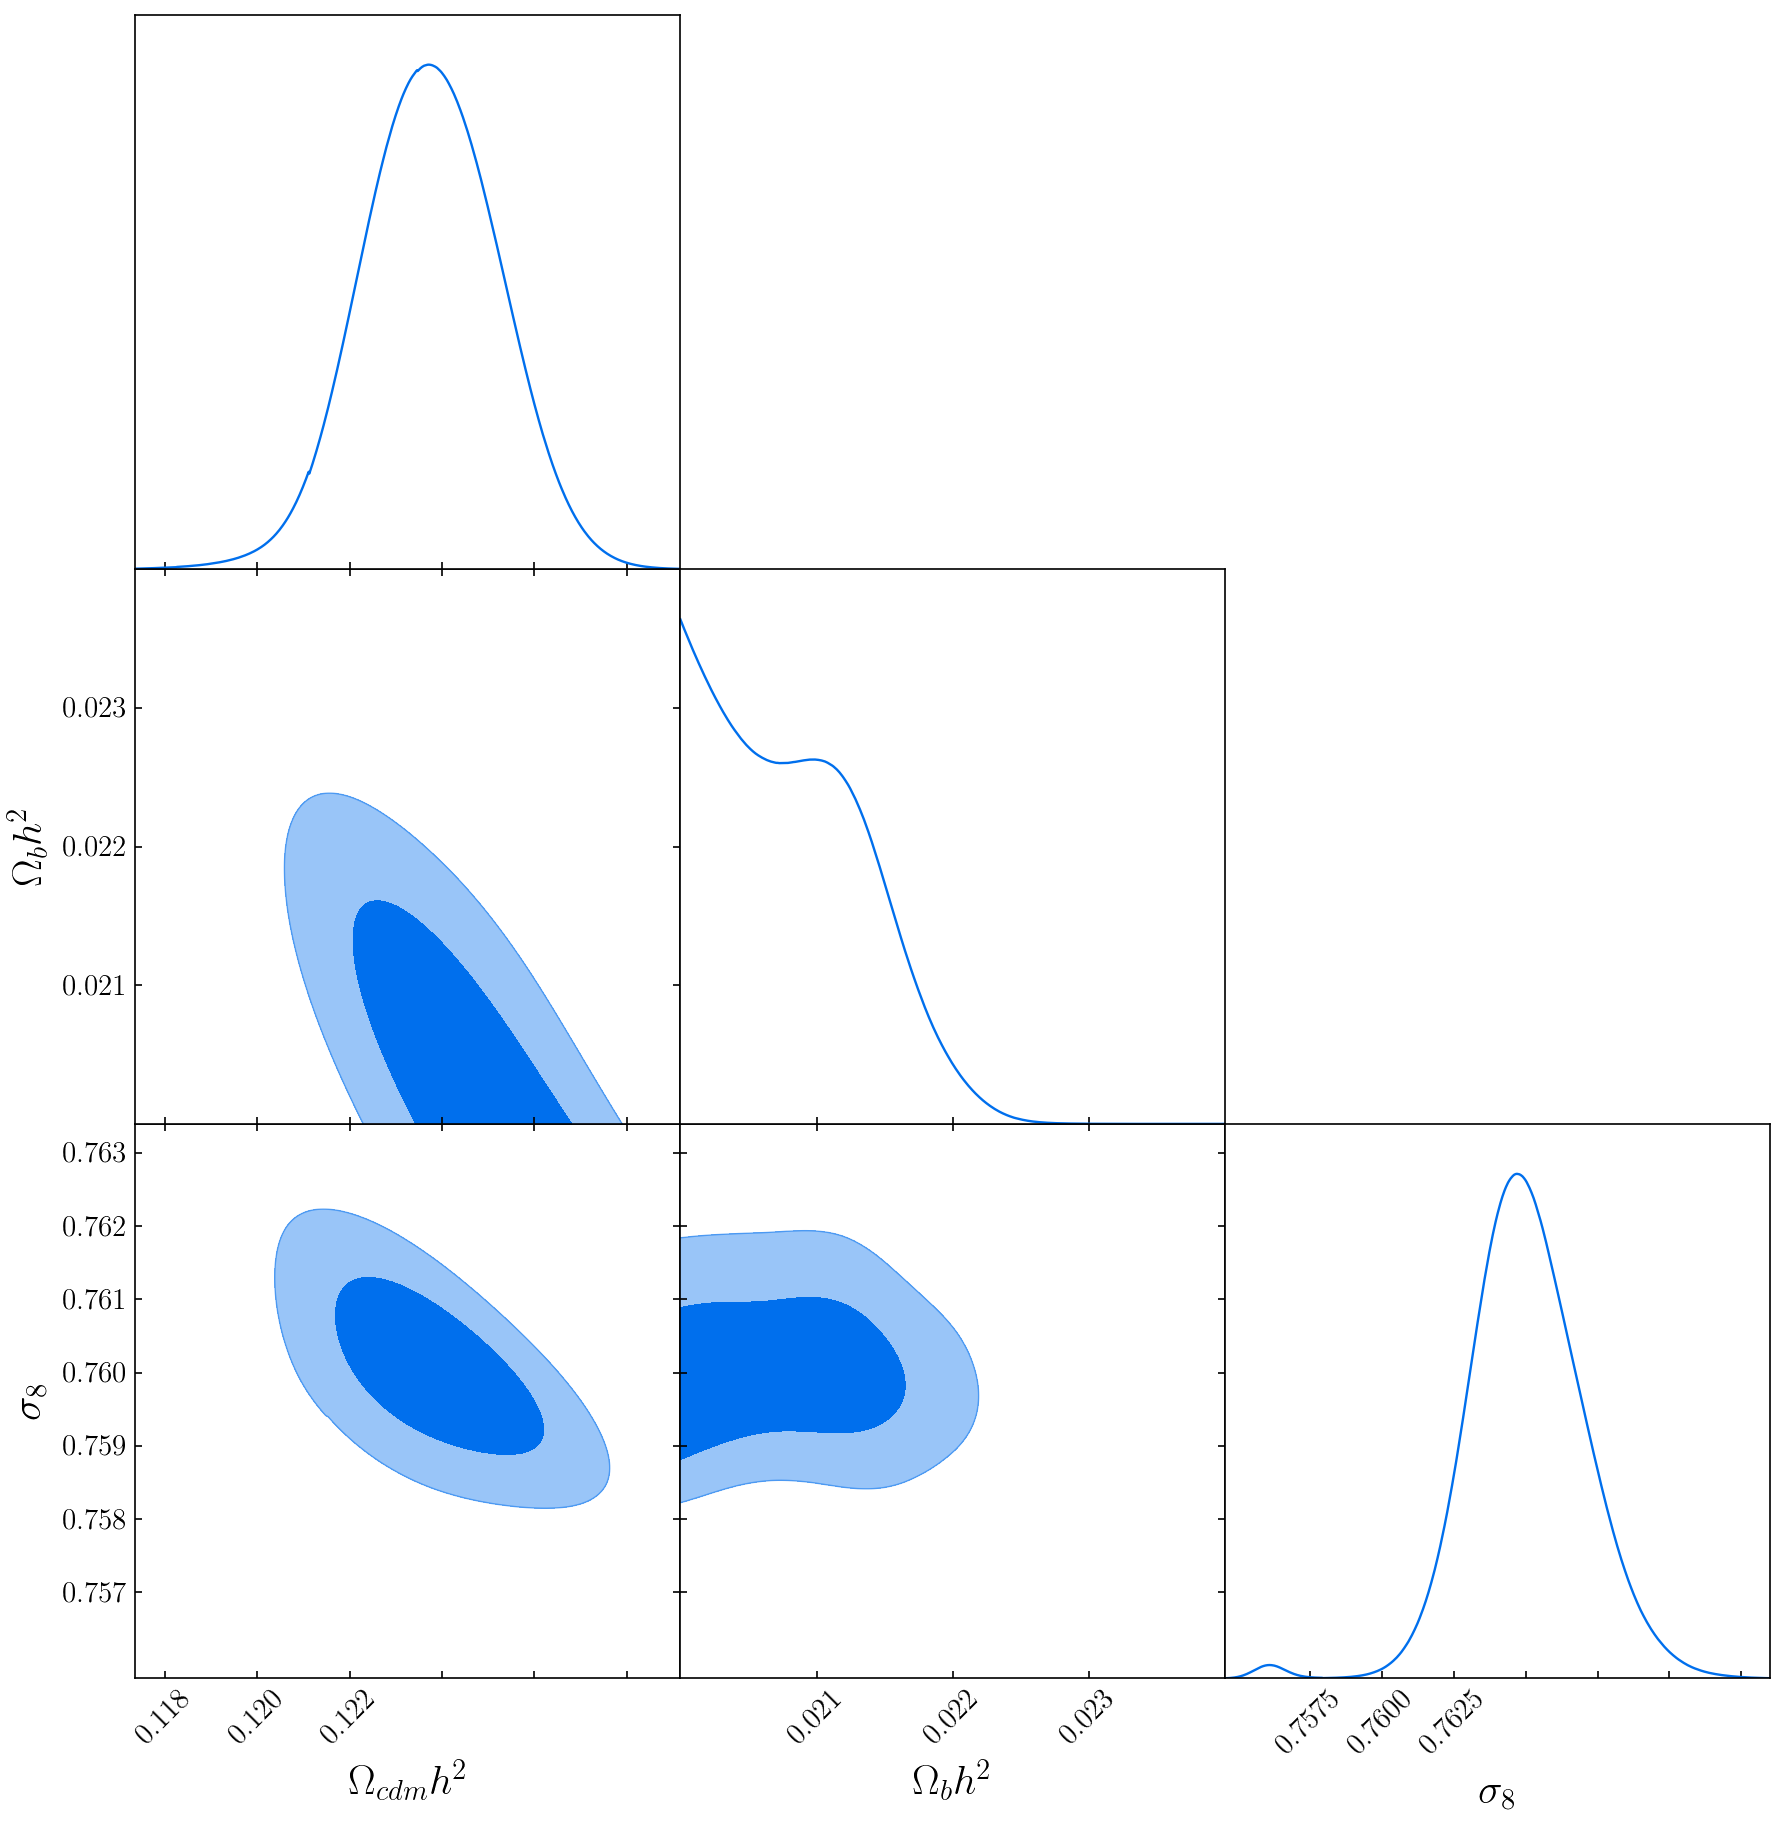

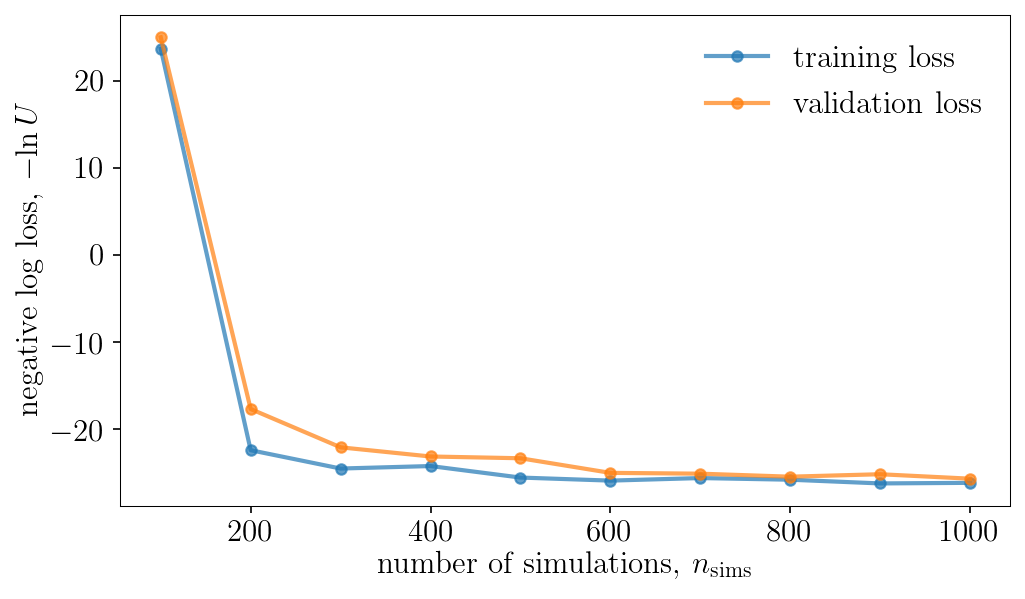

Population 10/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


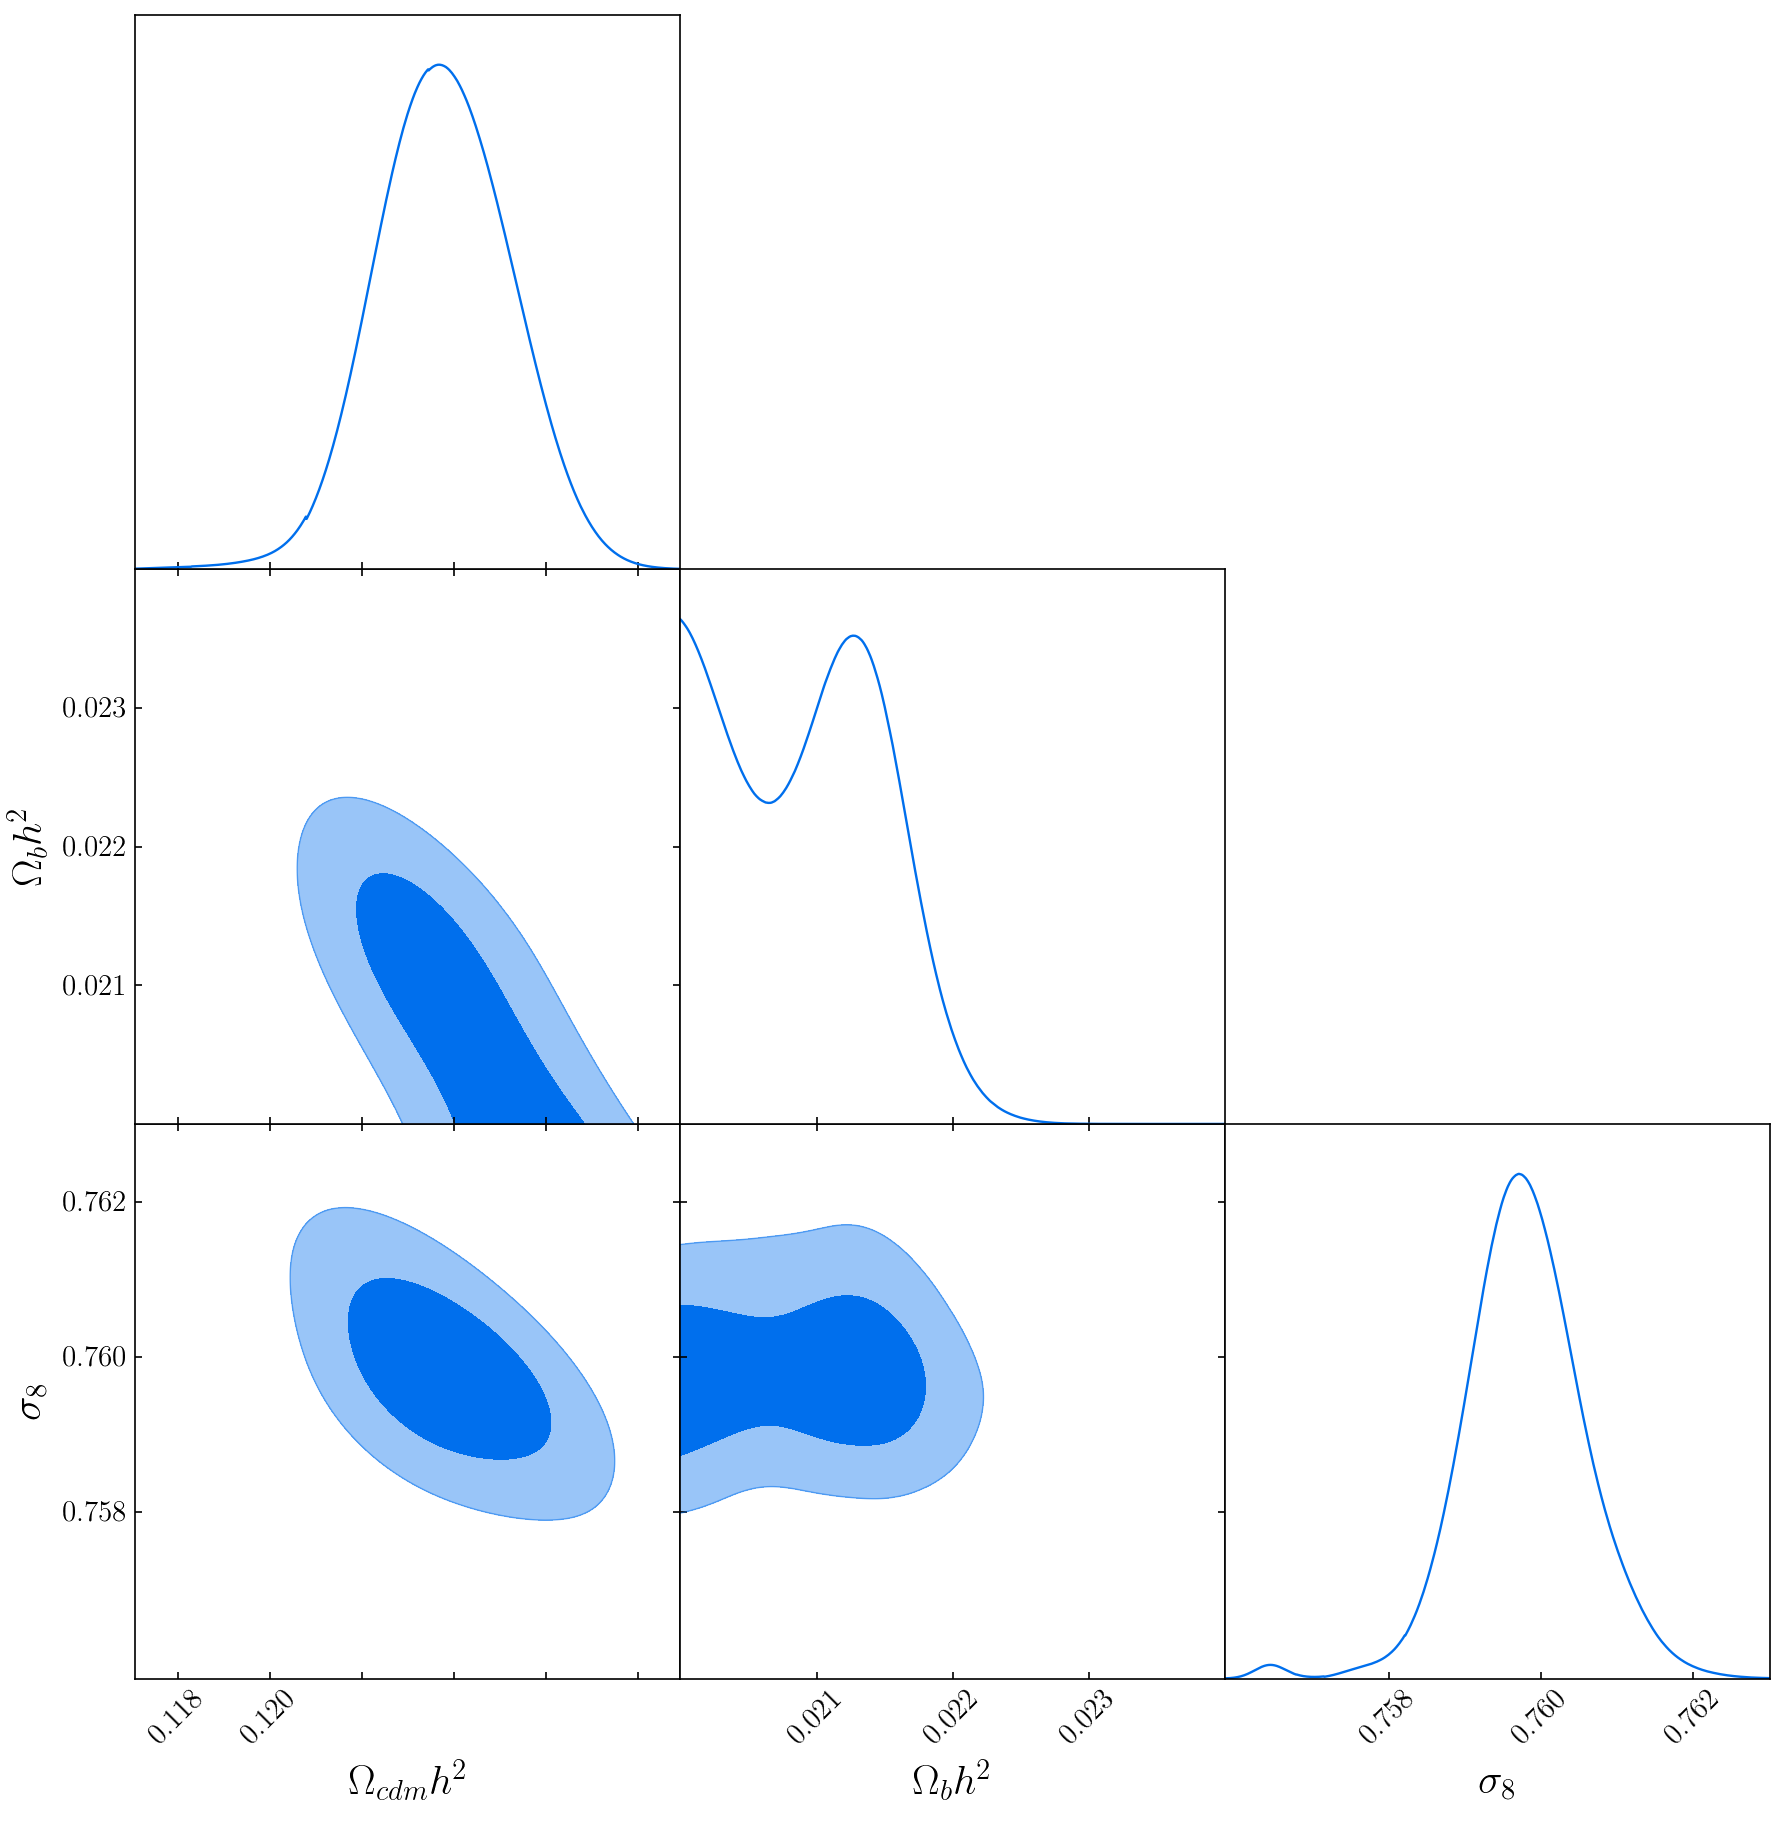

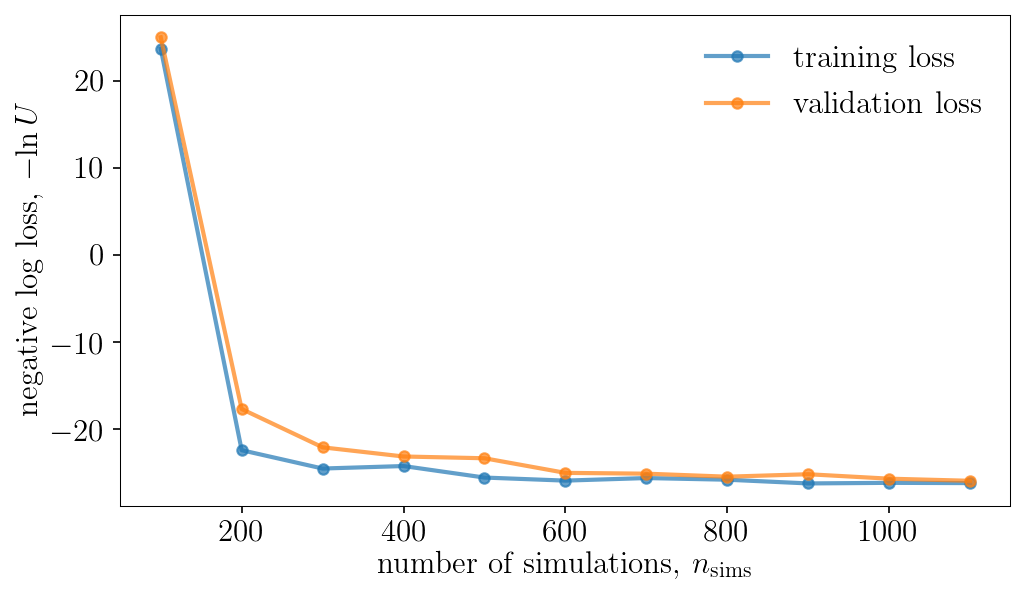

Population 11/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


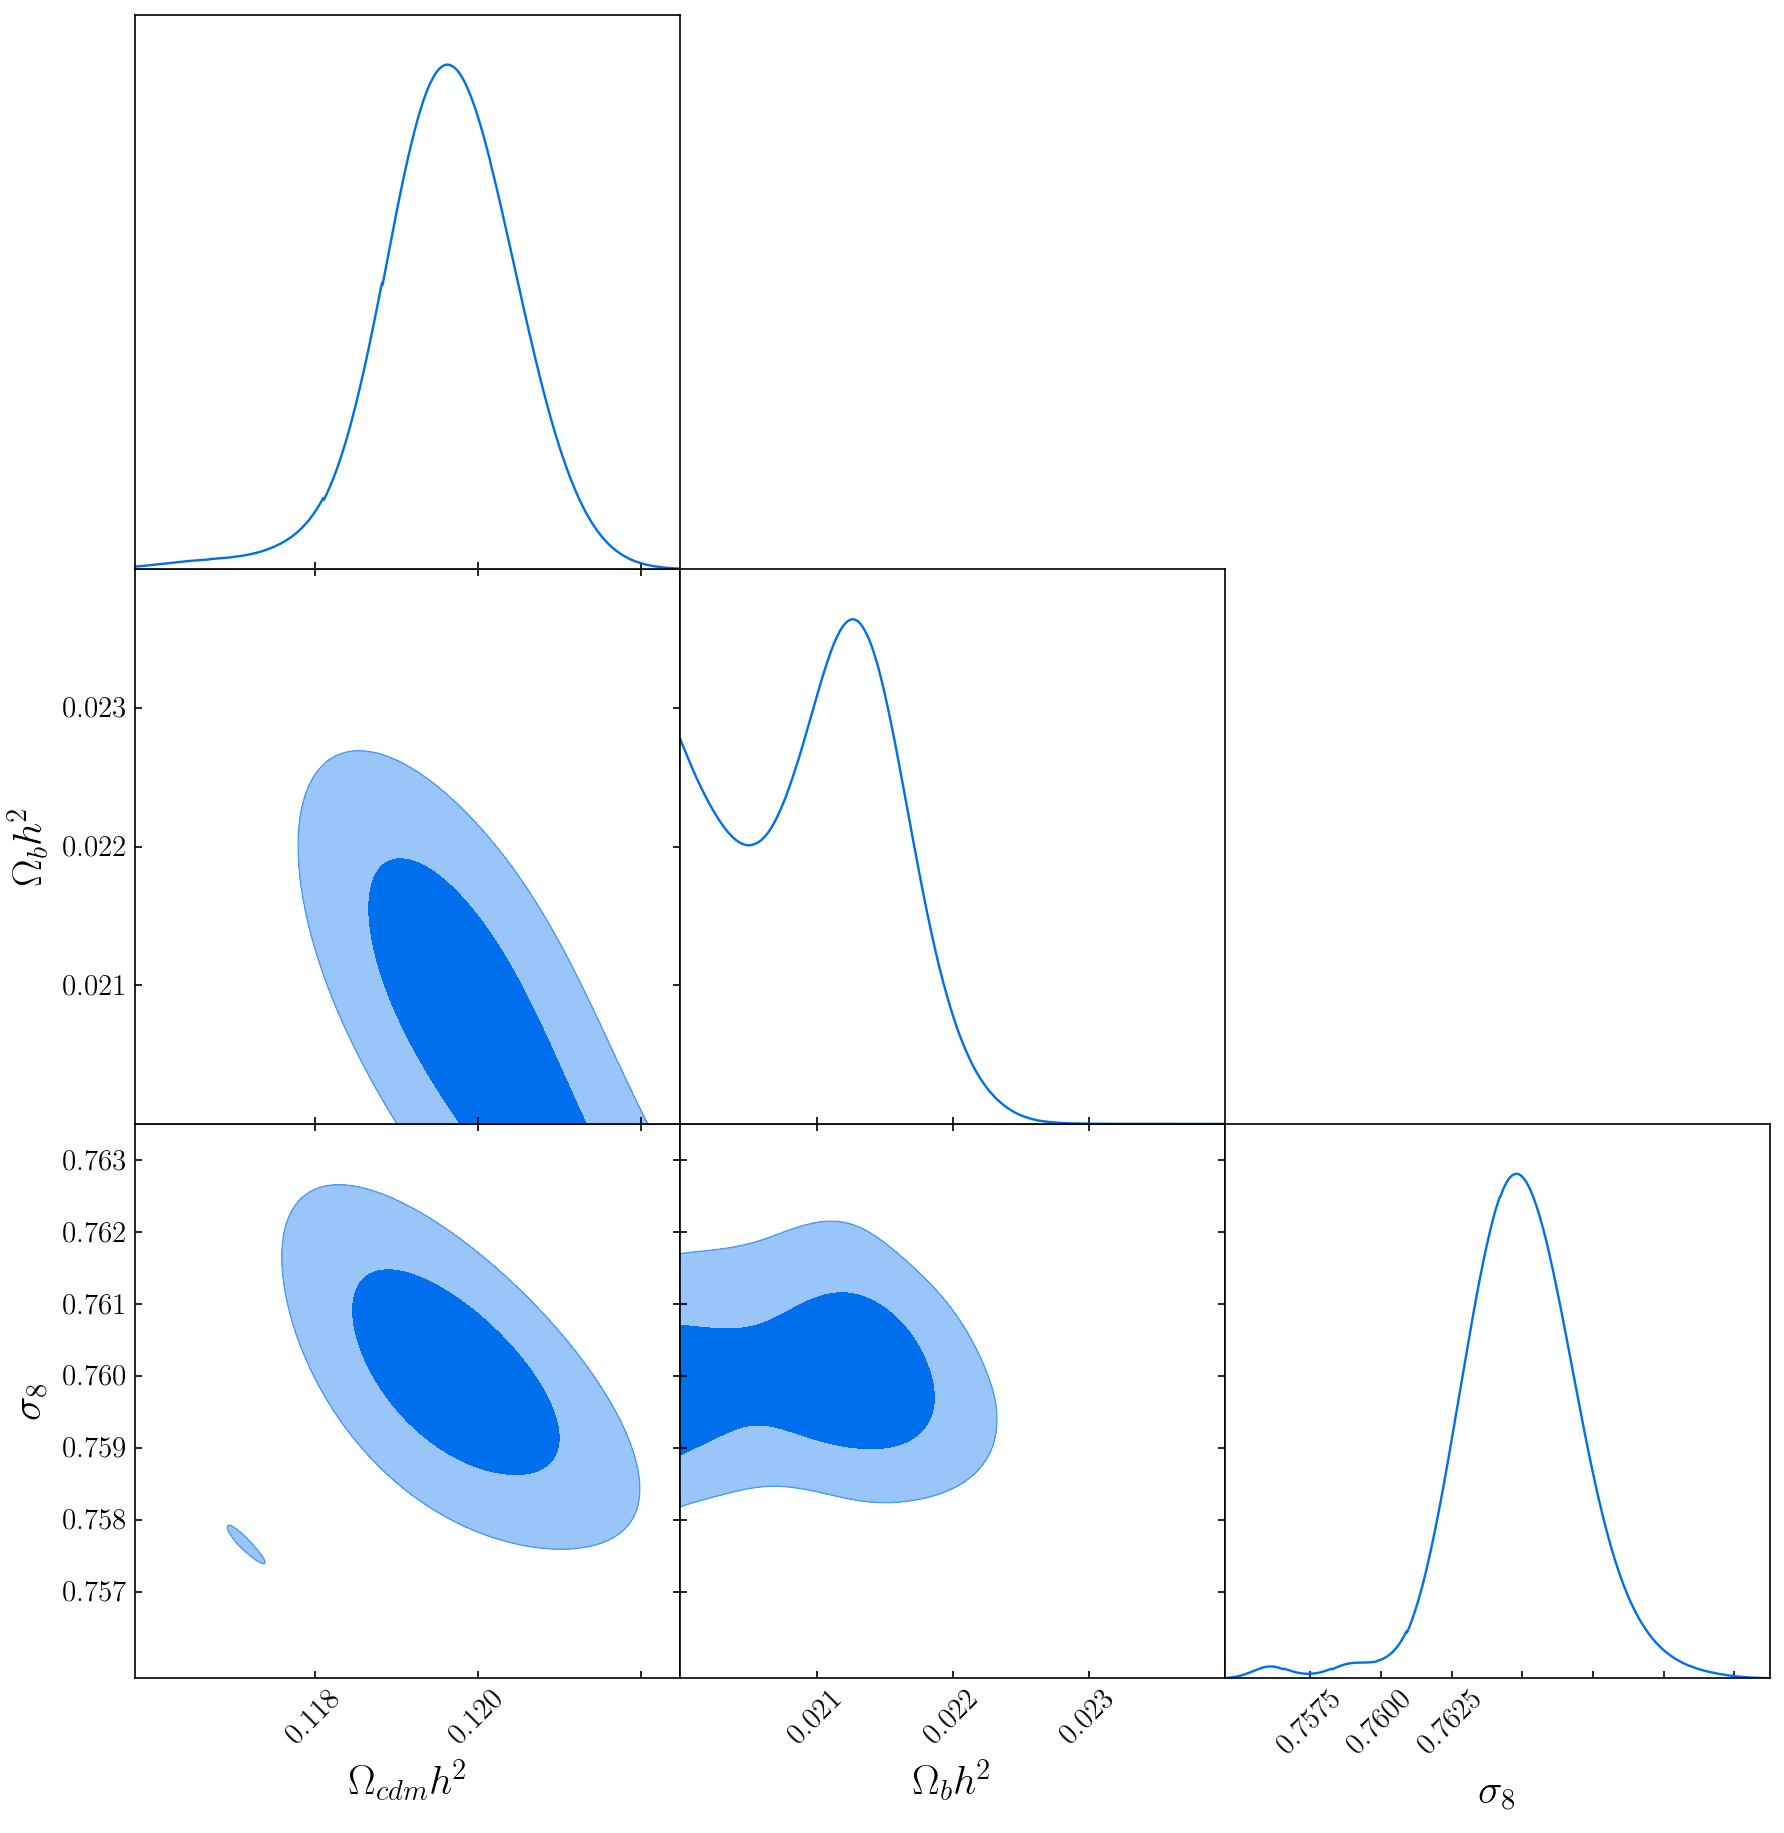

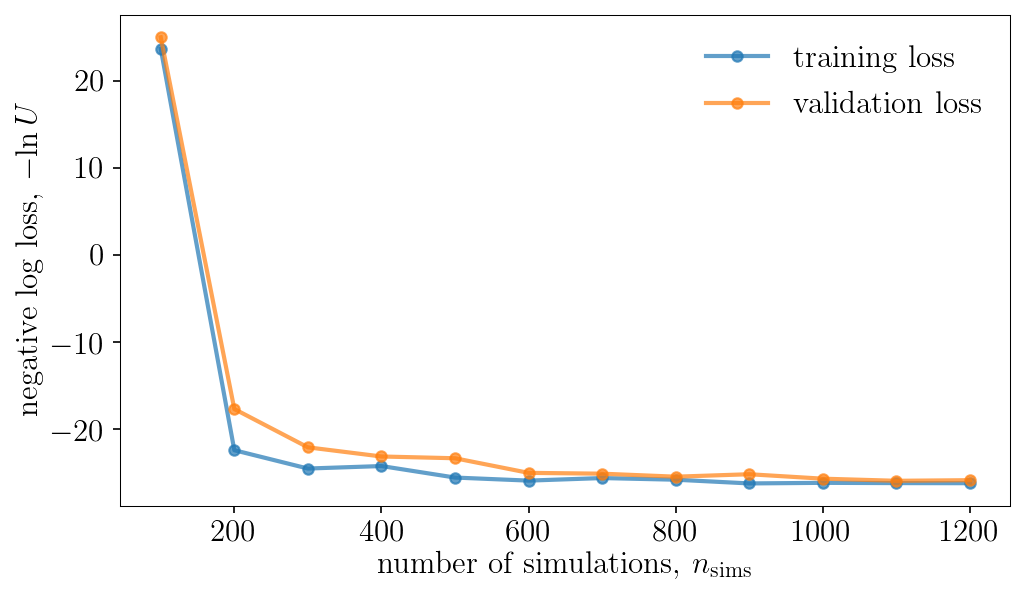

Population 12/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


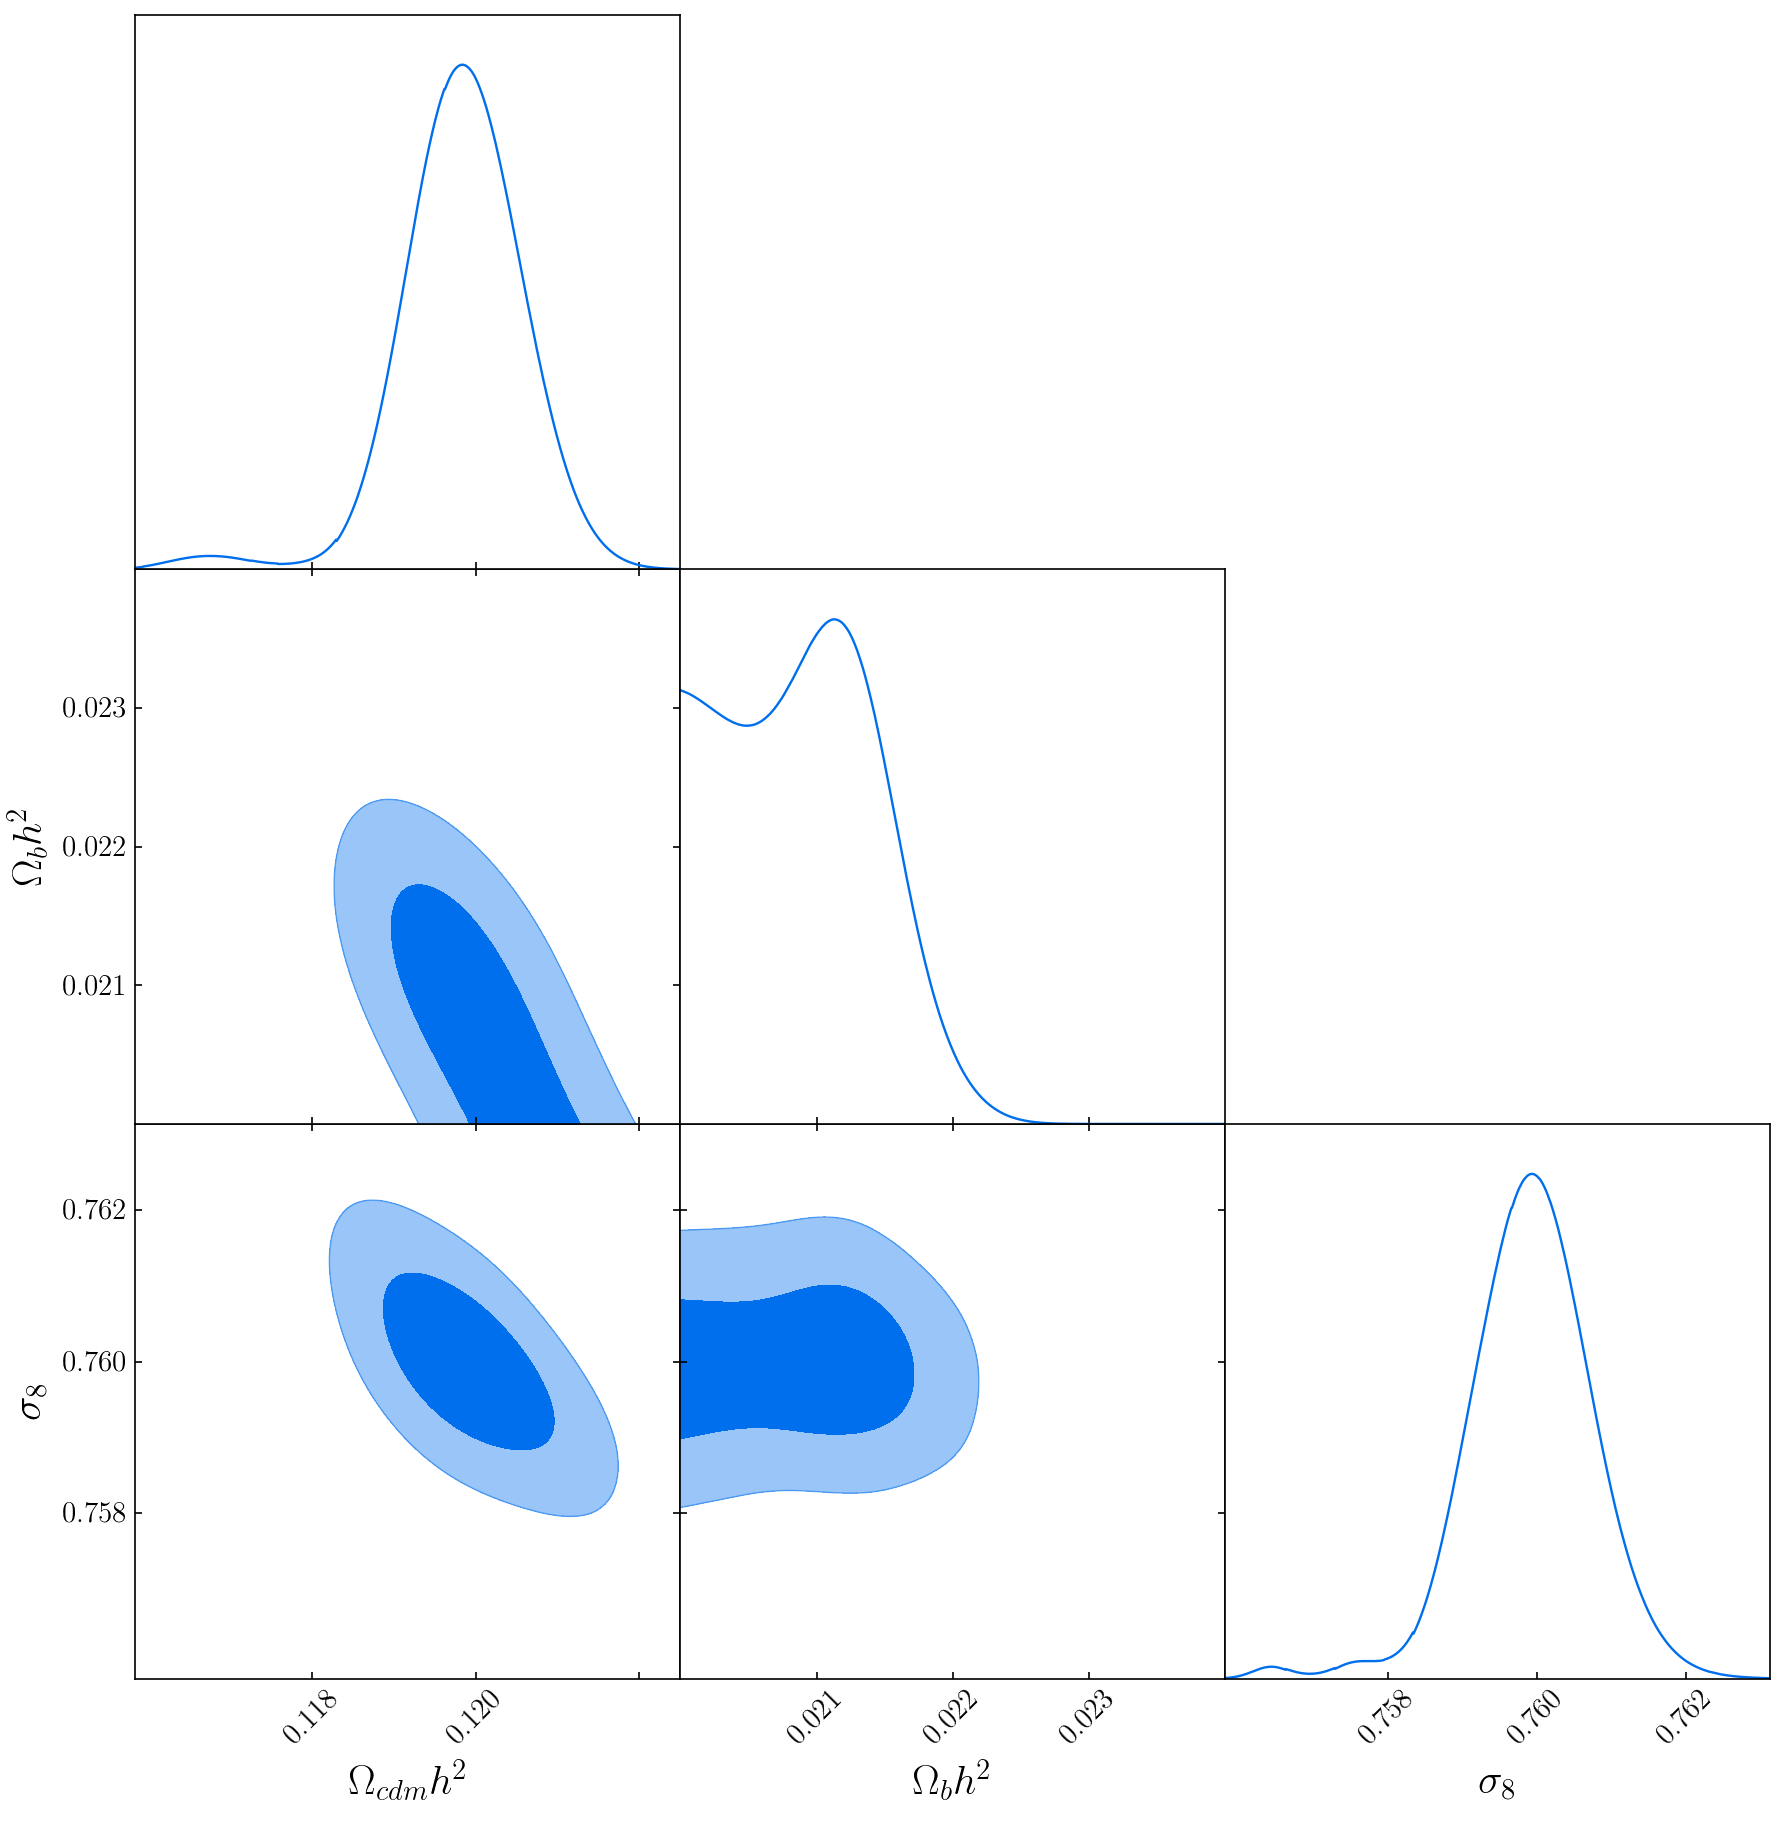

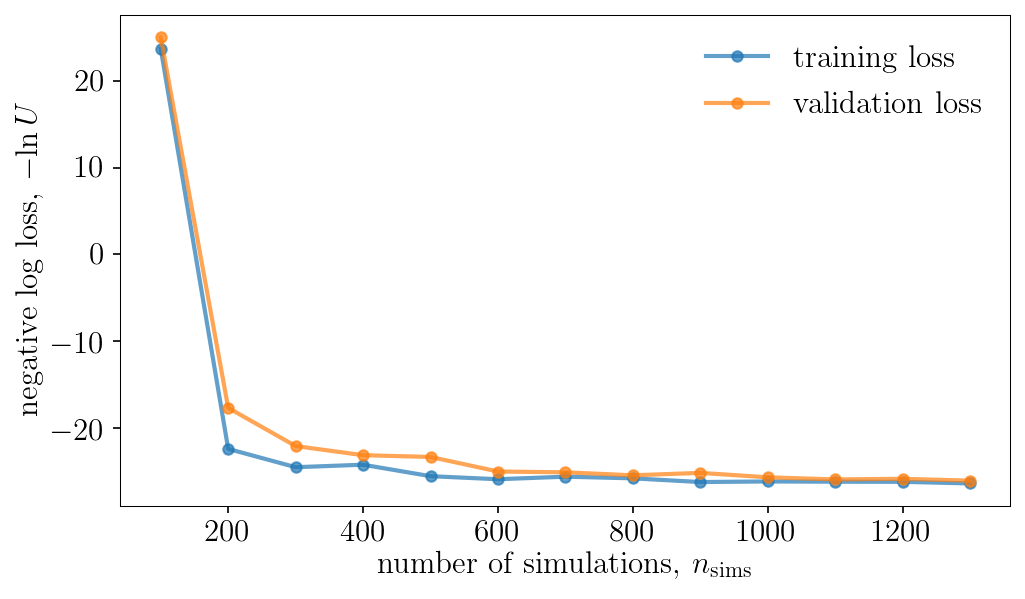

Population 13/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


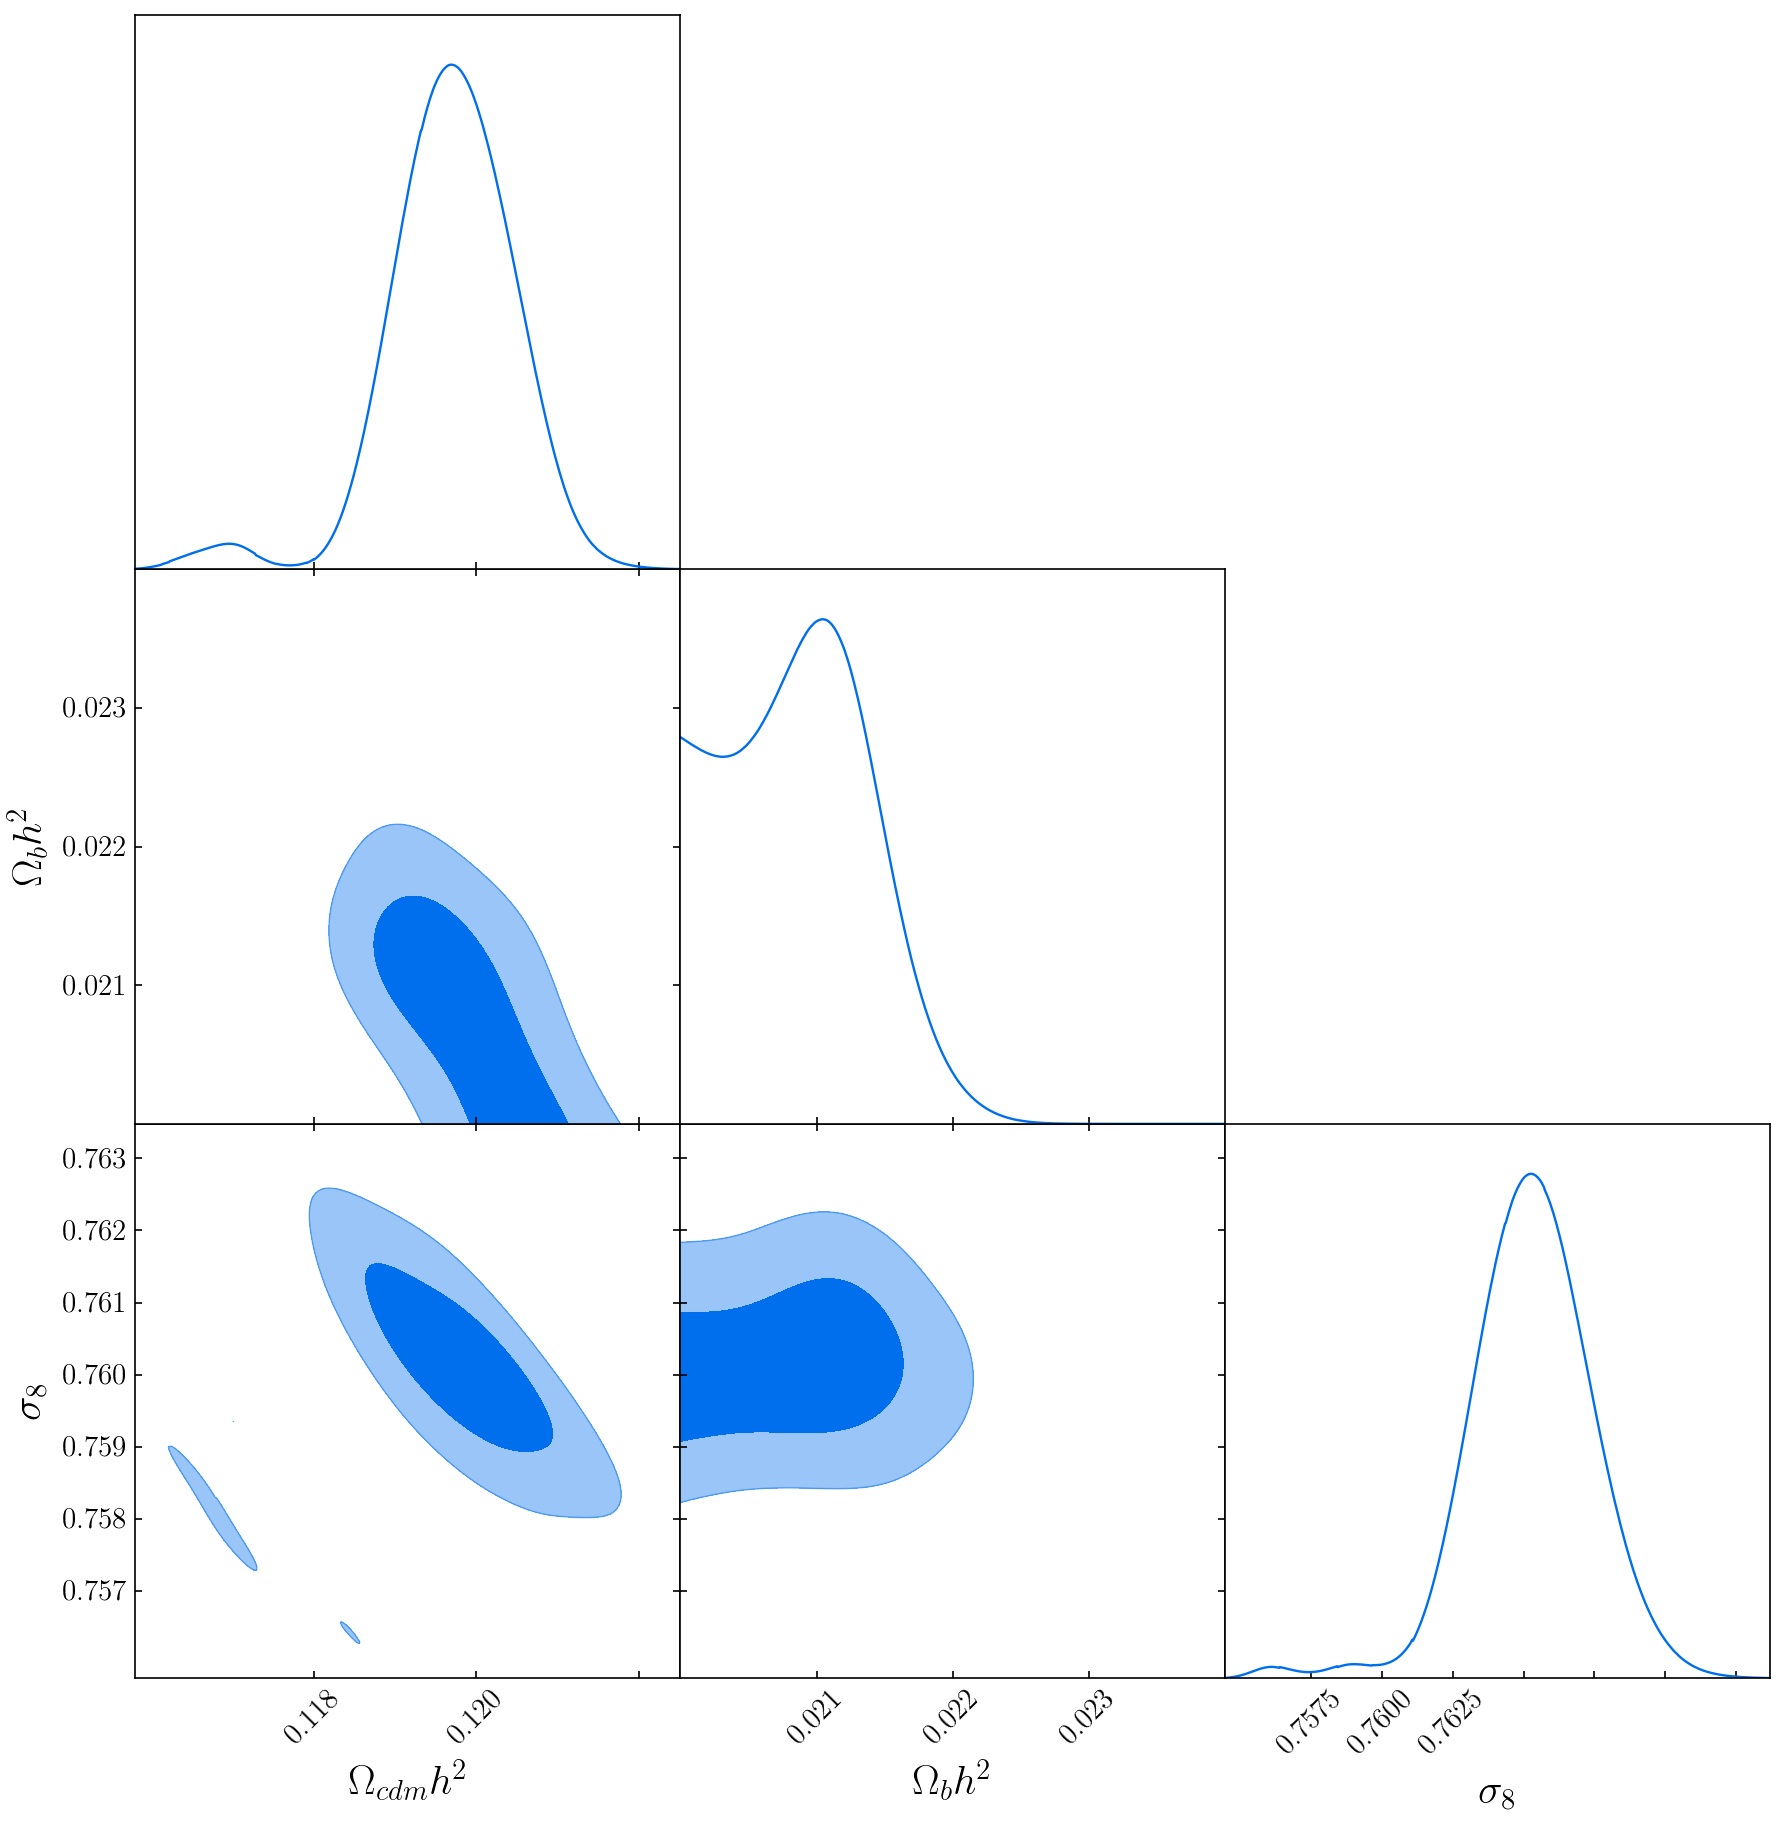

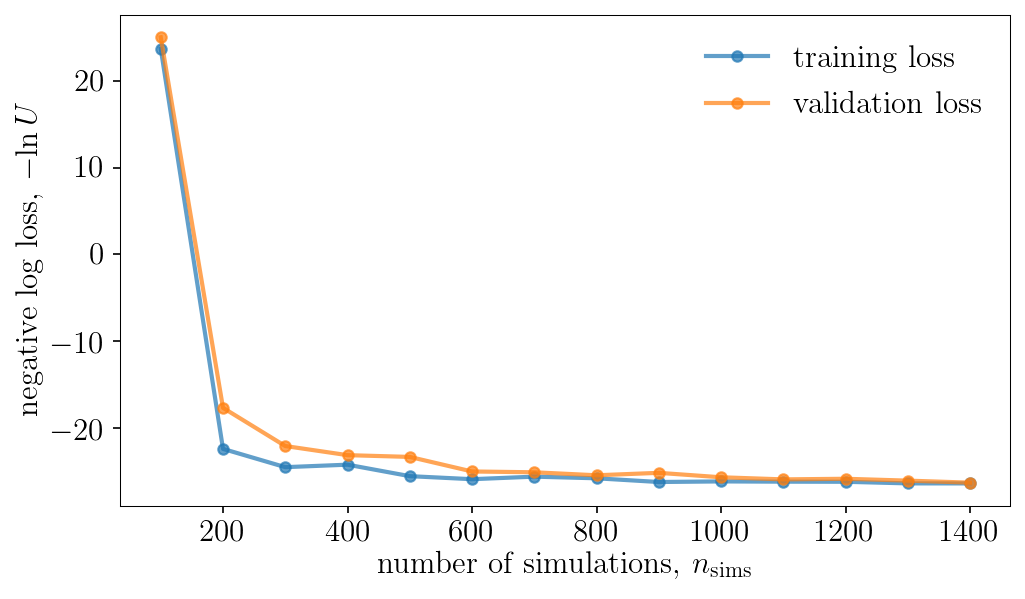

Population 14/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


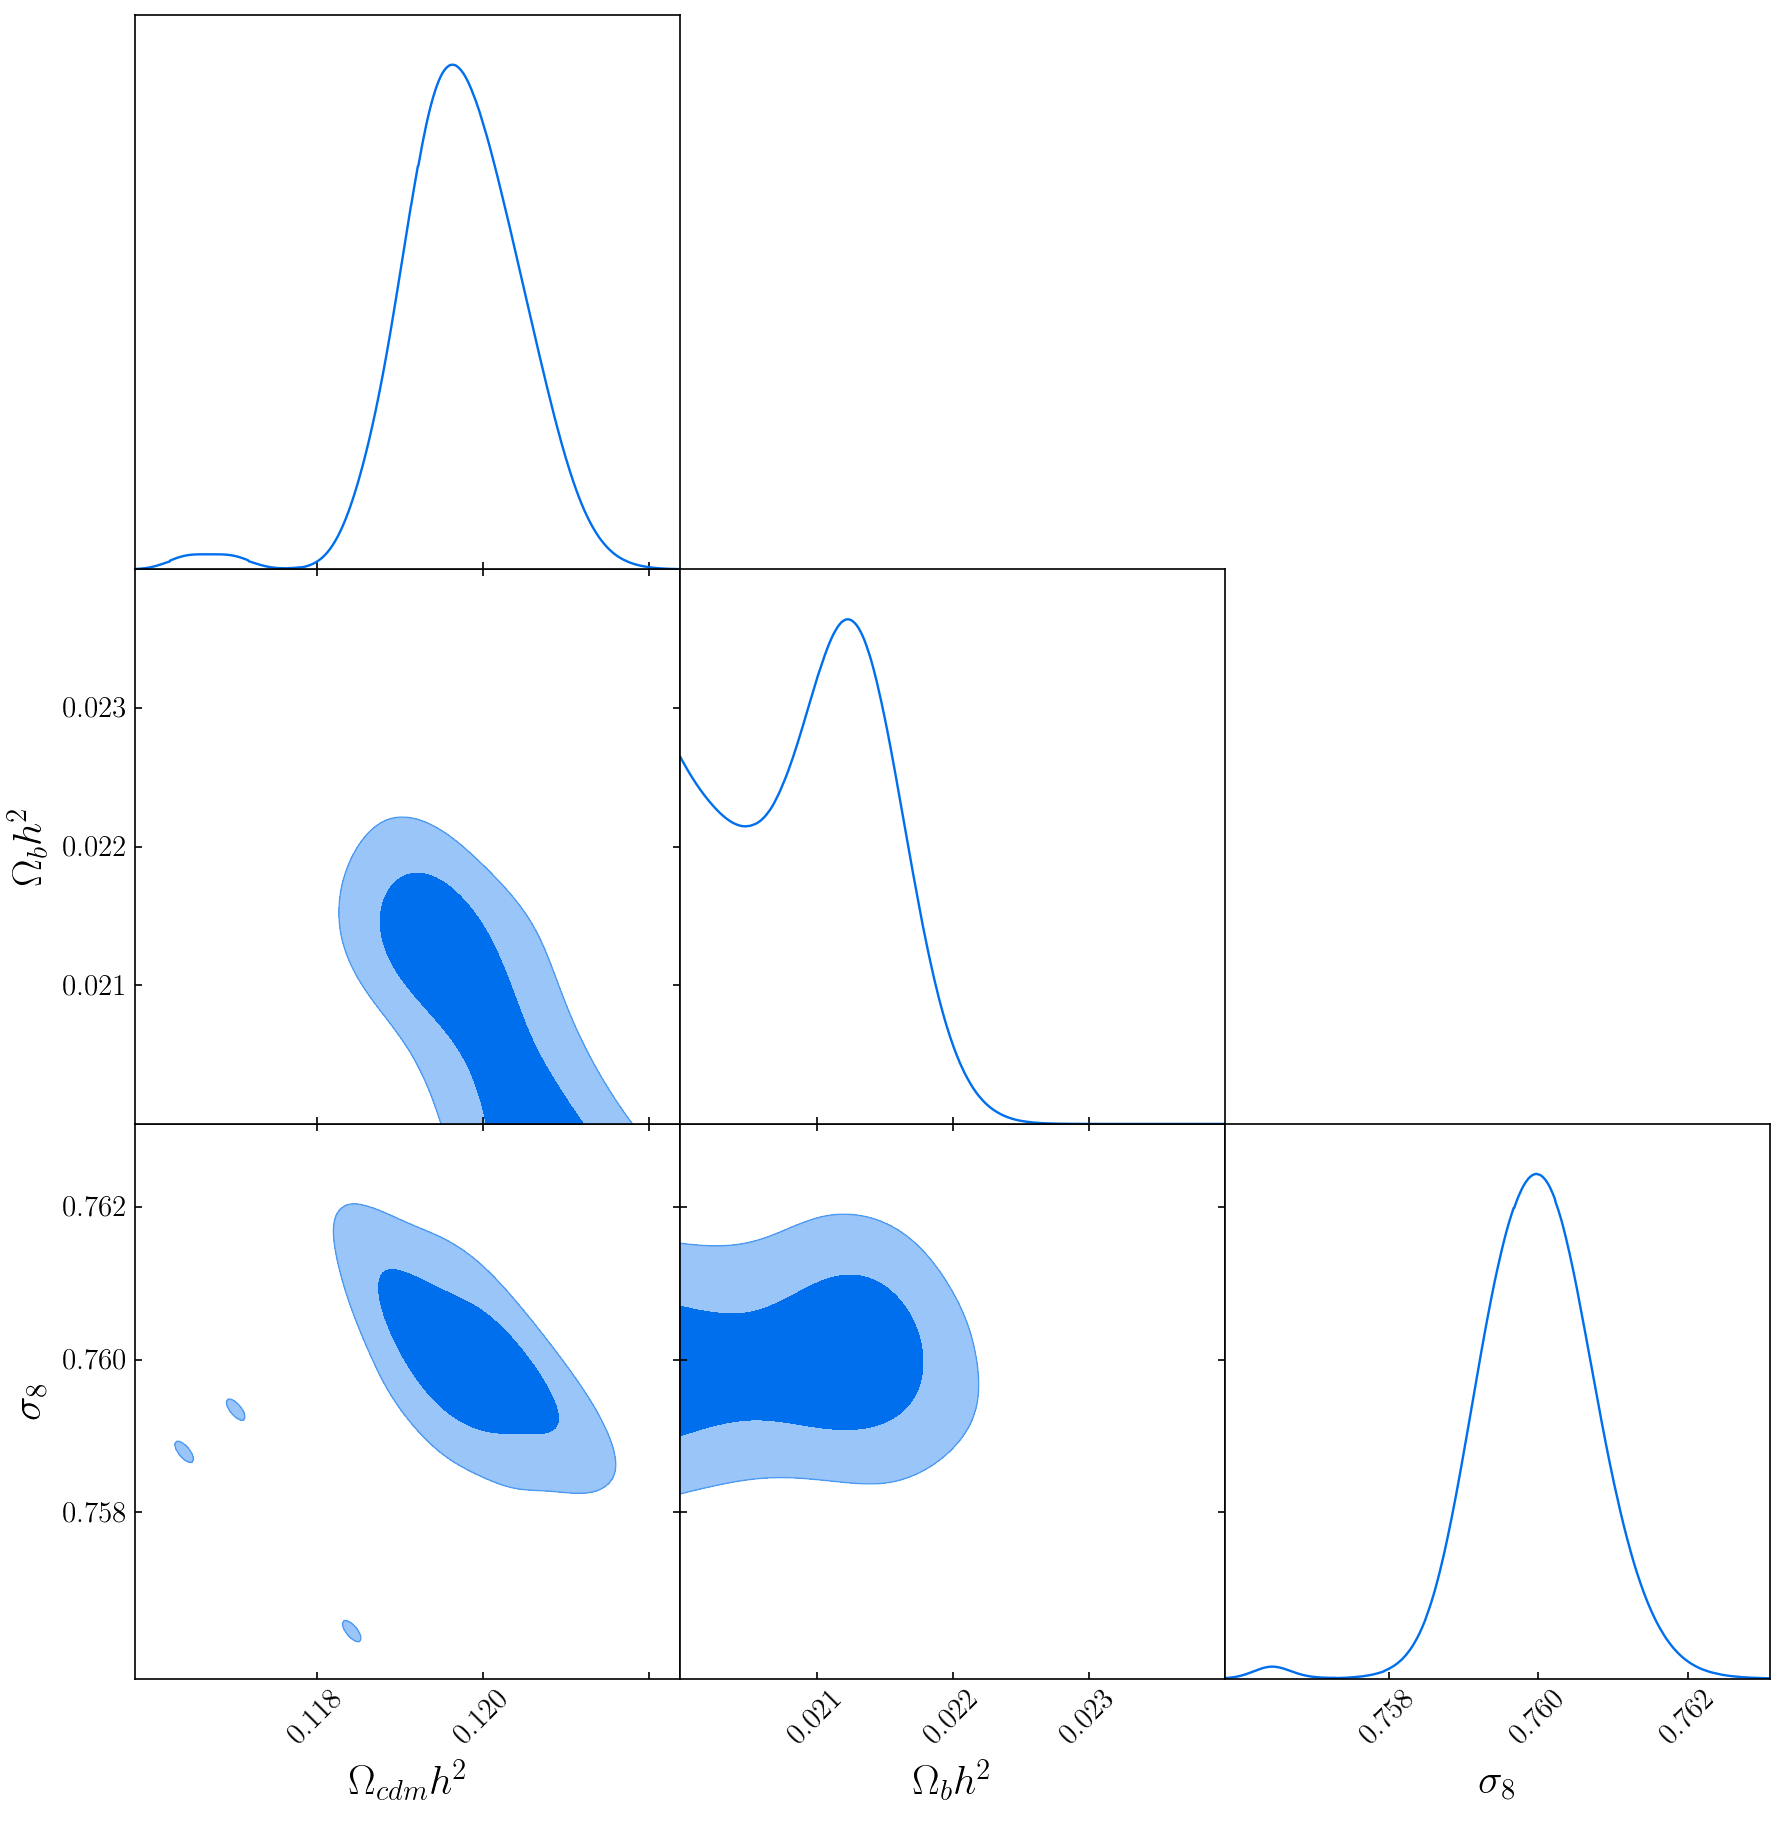

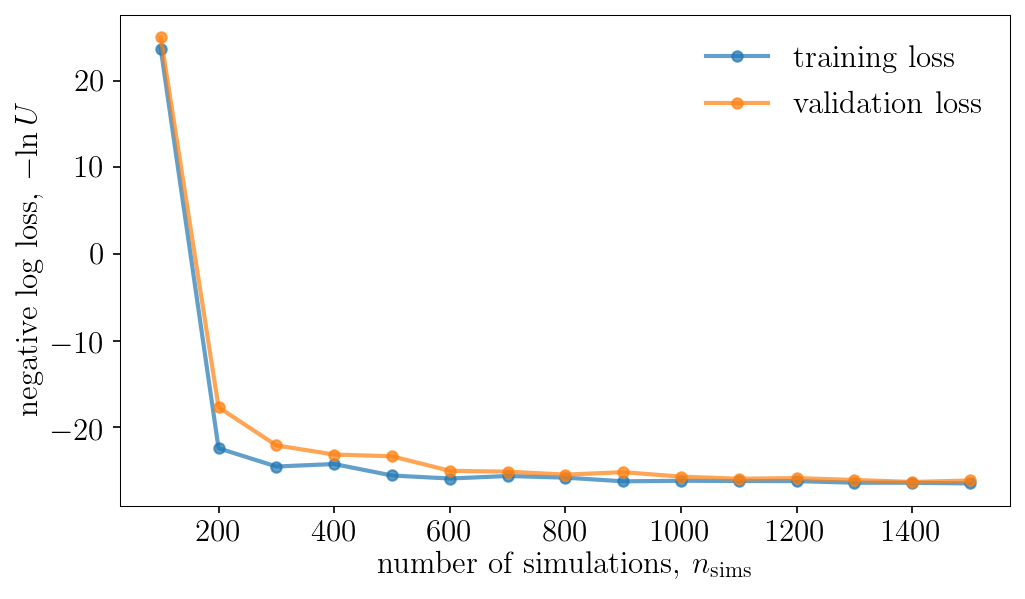

Population 15/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


KeyboardInterrupt: 

In [23]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

## Create DELFI object

In [24]:
DelfiEnsemble0 = delfi.Delfi(N_counts_data, prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_tinker_1000sims/")

In [ ]:
DelfiEnsemble0 = delfi.Delfi(N_counts_data, prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_tinker_1000sims/")
n_initial = 100 
n_batch = 100 
n_populations = 10 

DelfiEnsemble0.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

## Sequential Neural Likelihood

In [25]:
n_initial = 100 
n_batch = 100 
n_populations = 10 

Sampling approximate posterior...
Done.
Removed no burn in


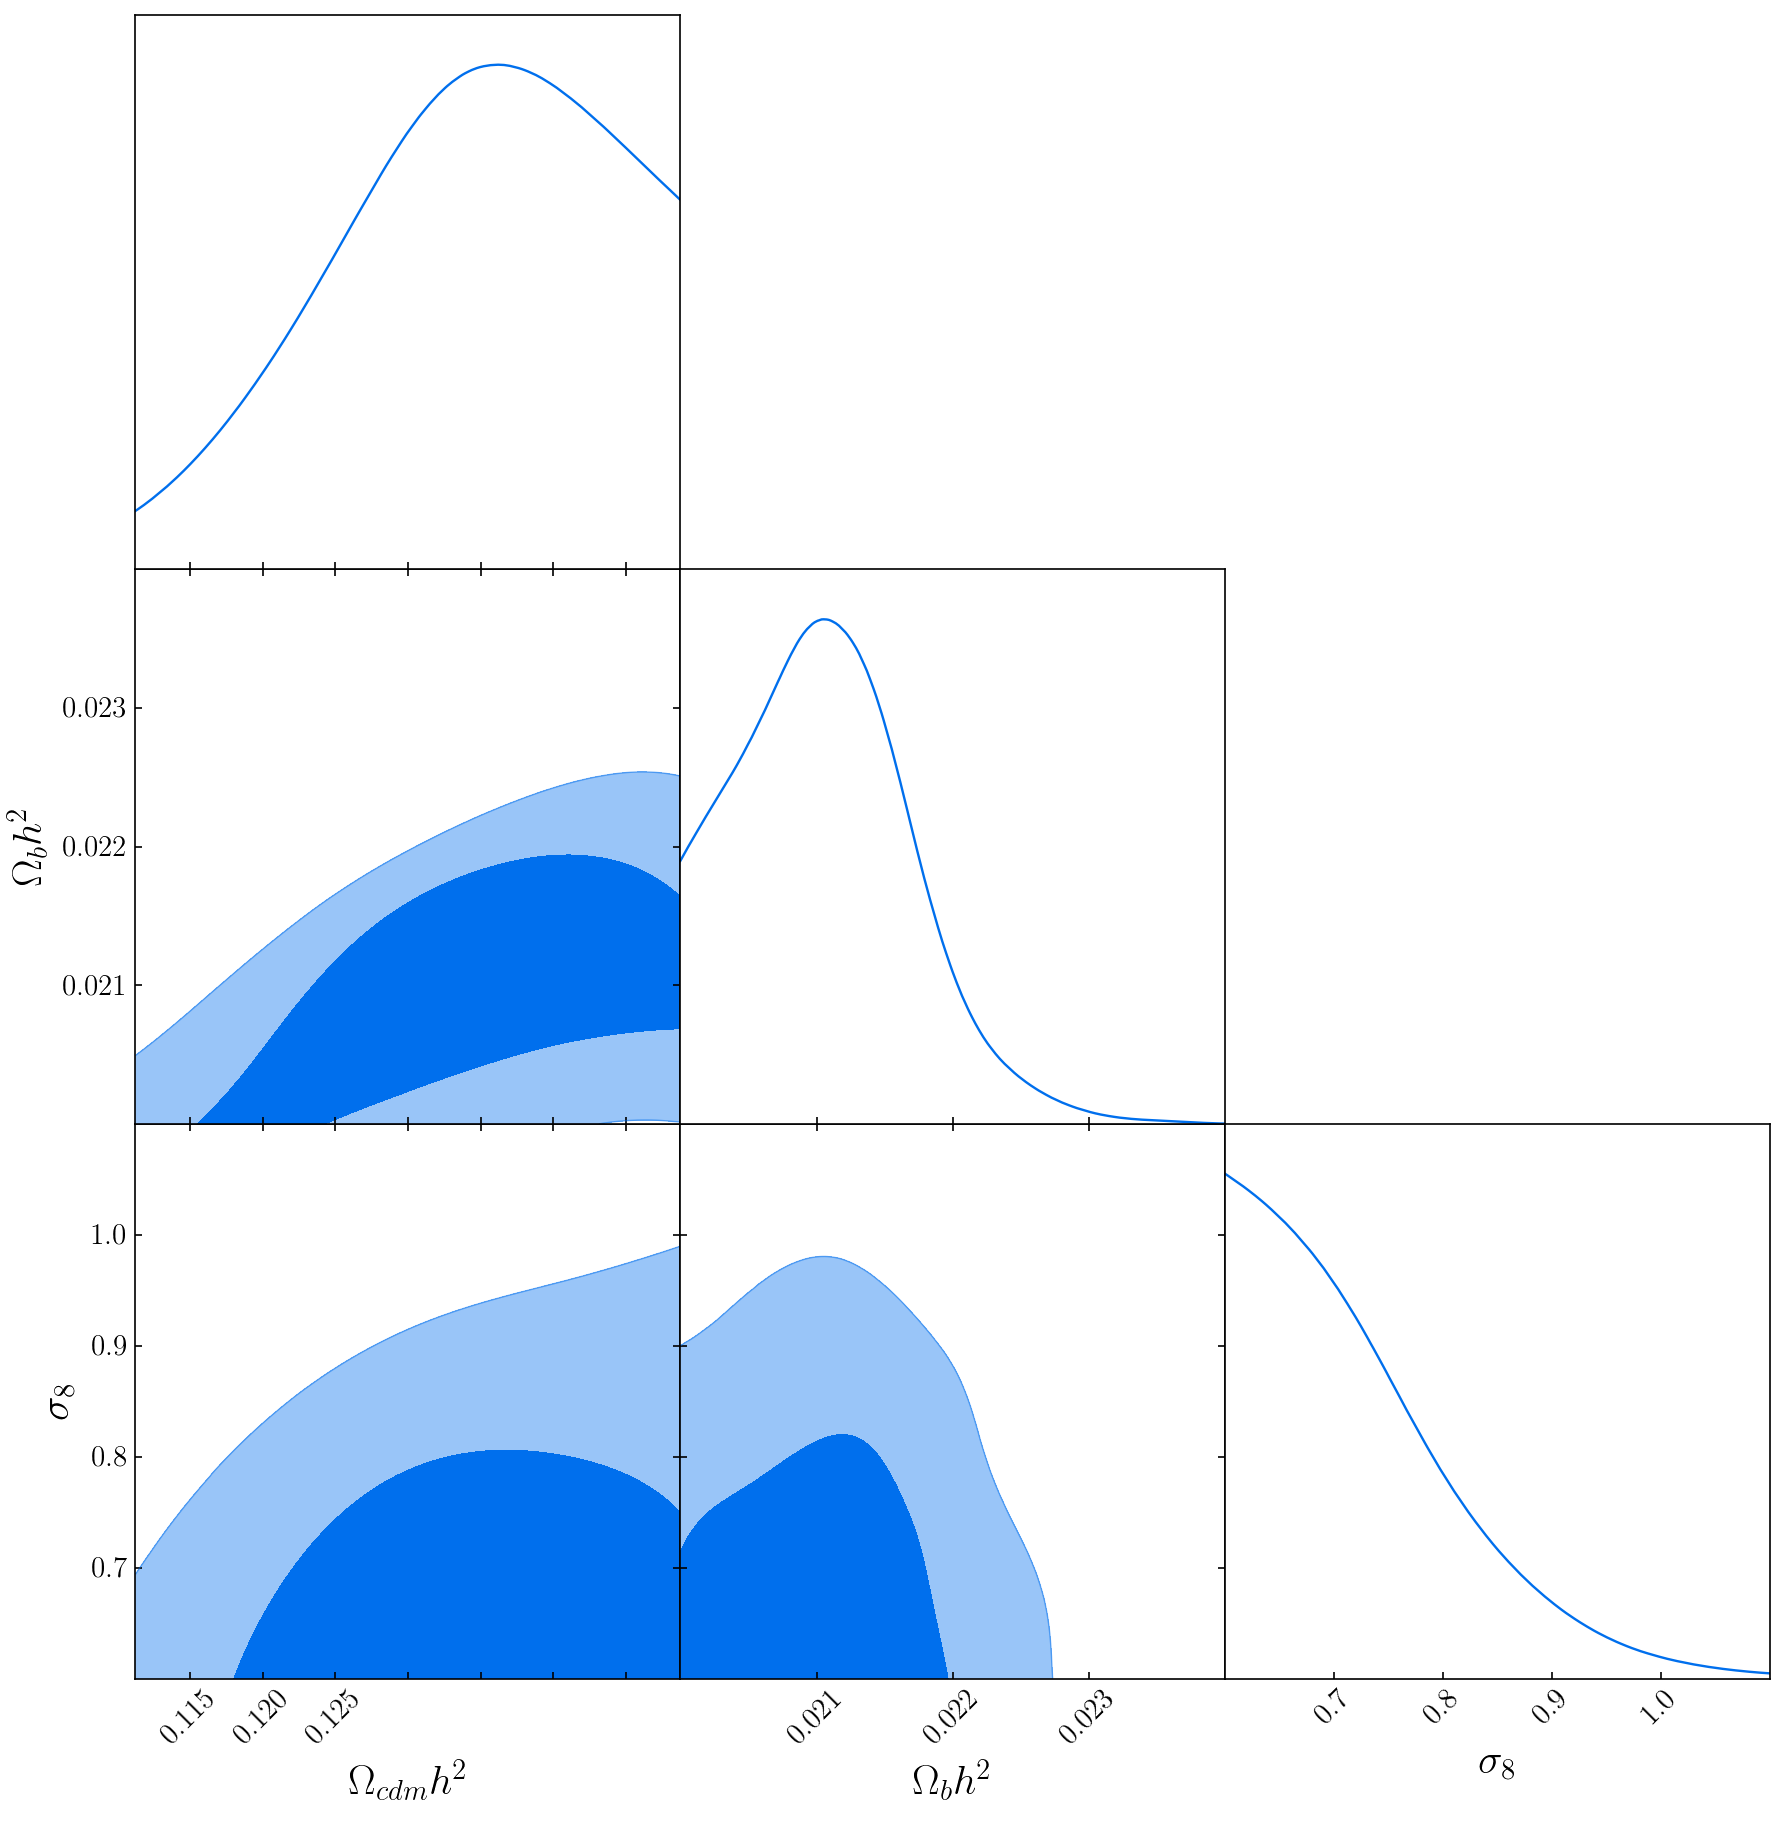

Population 1/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


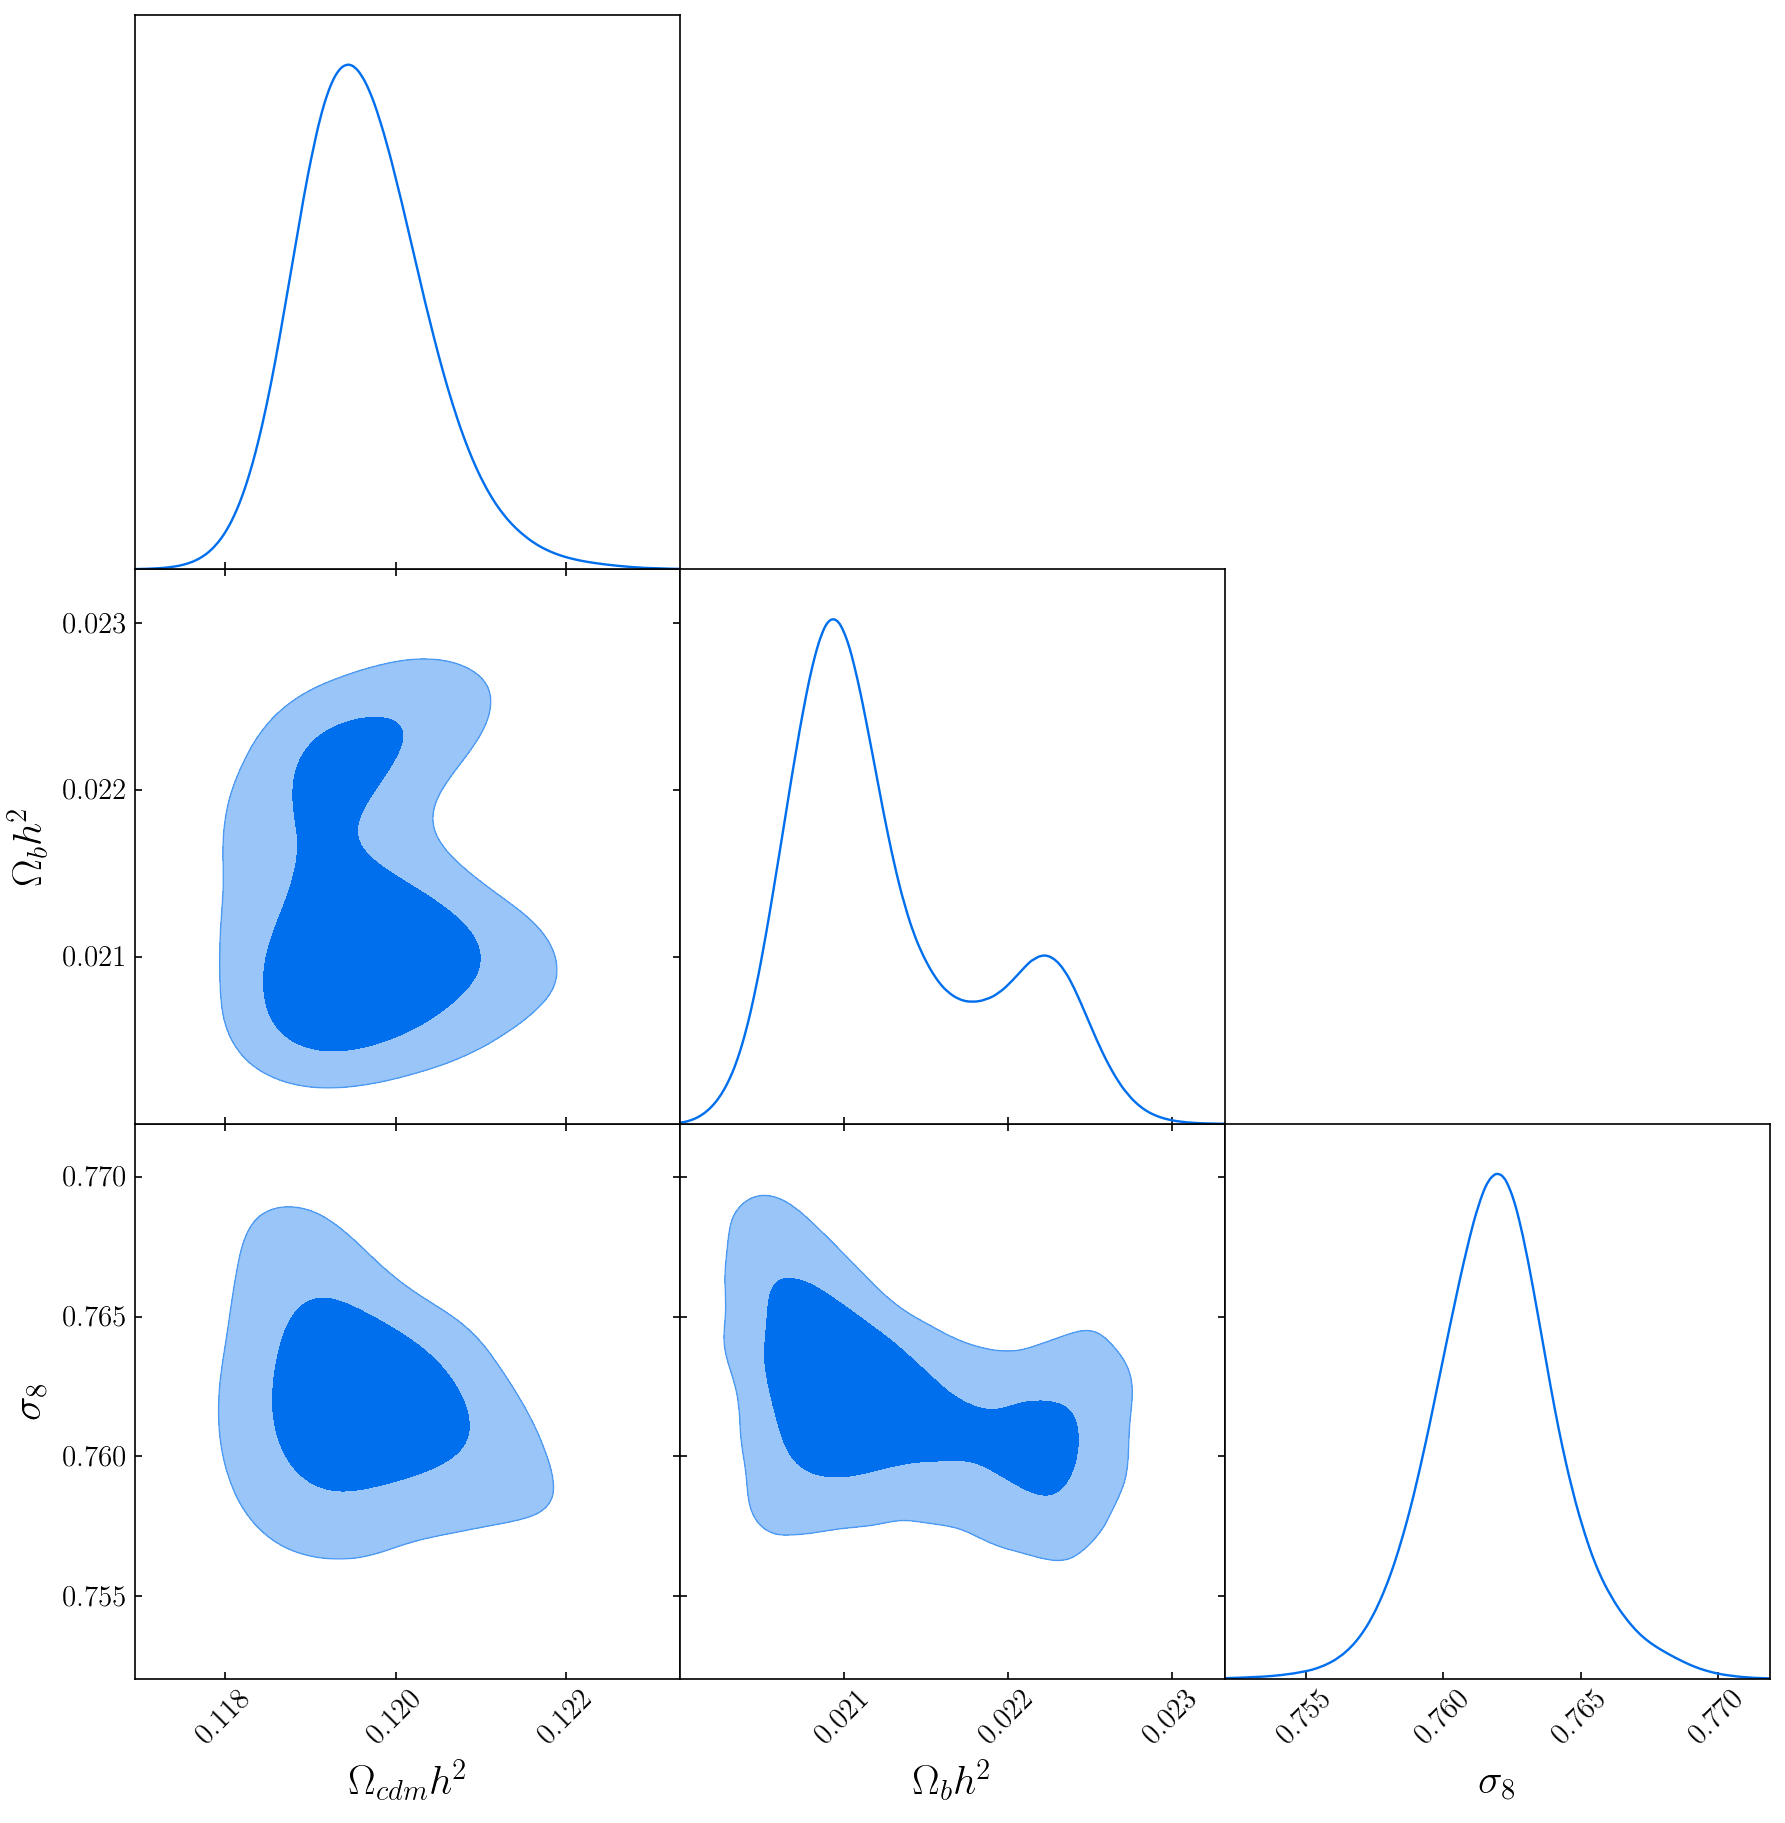

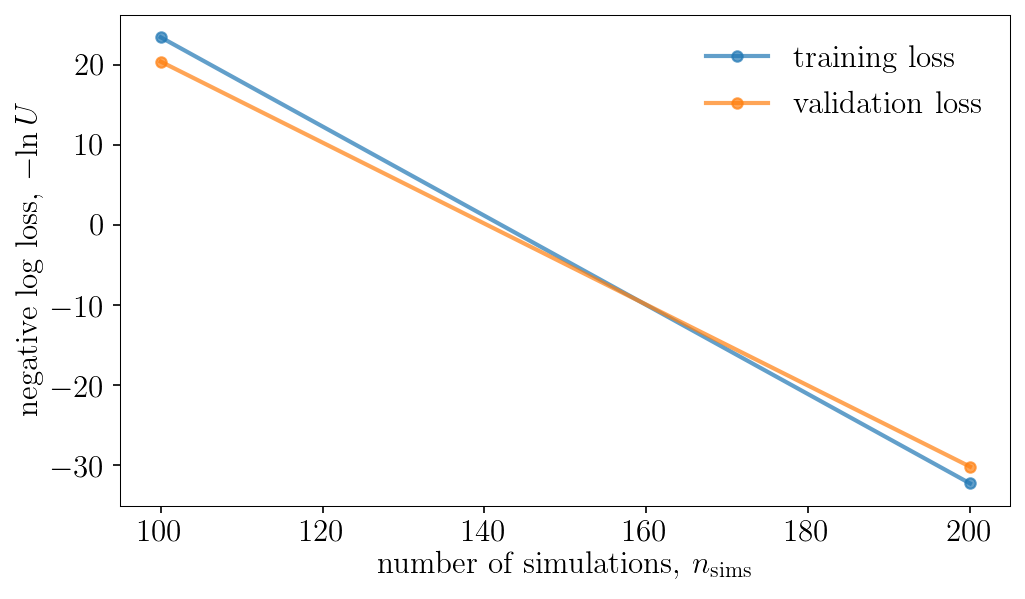

Population 2/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


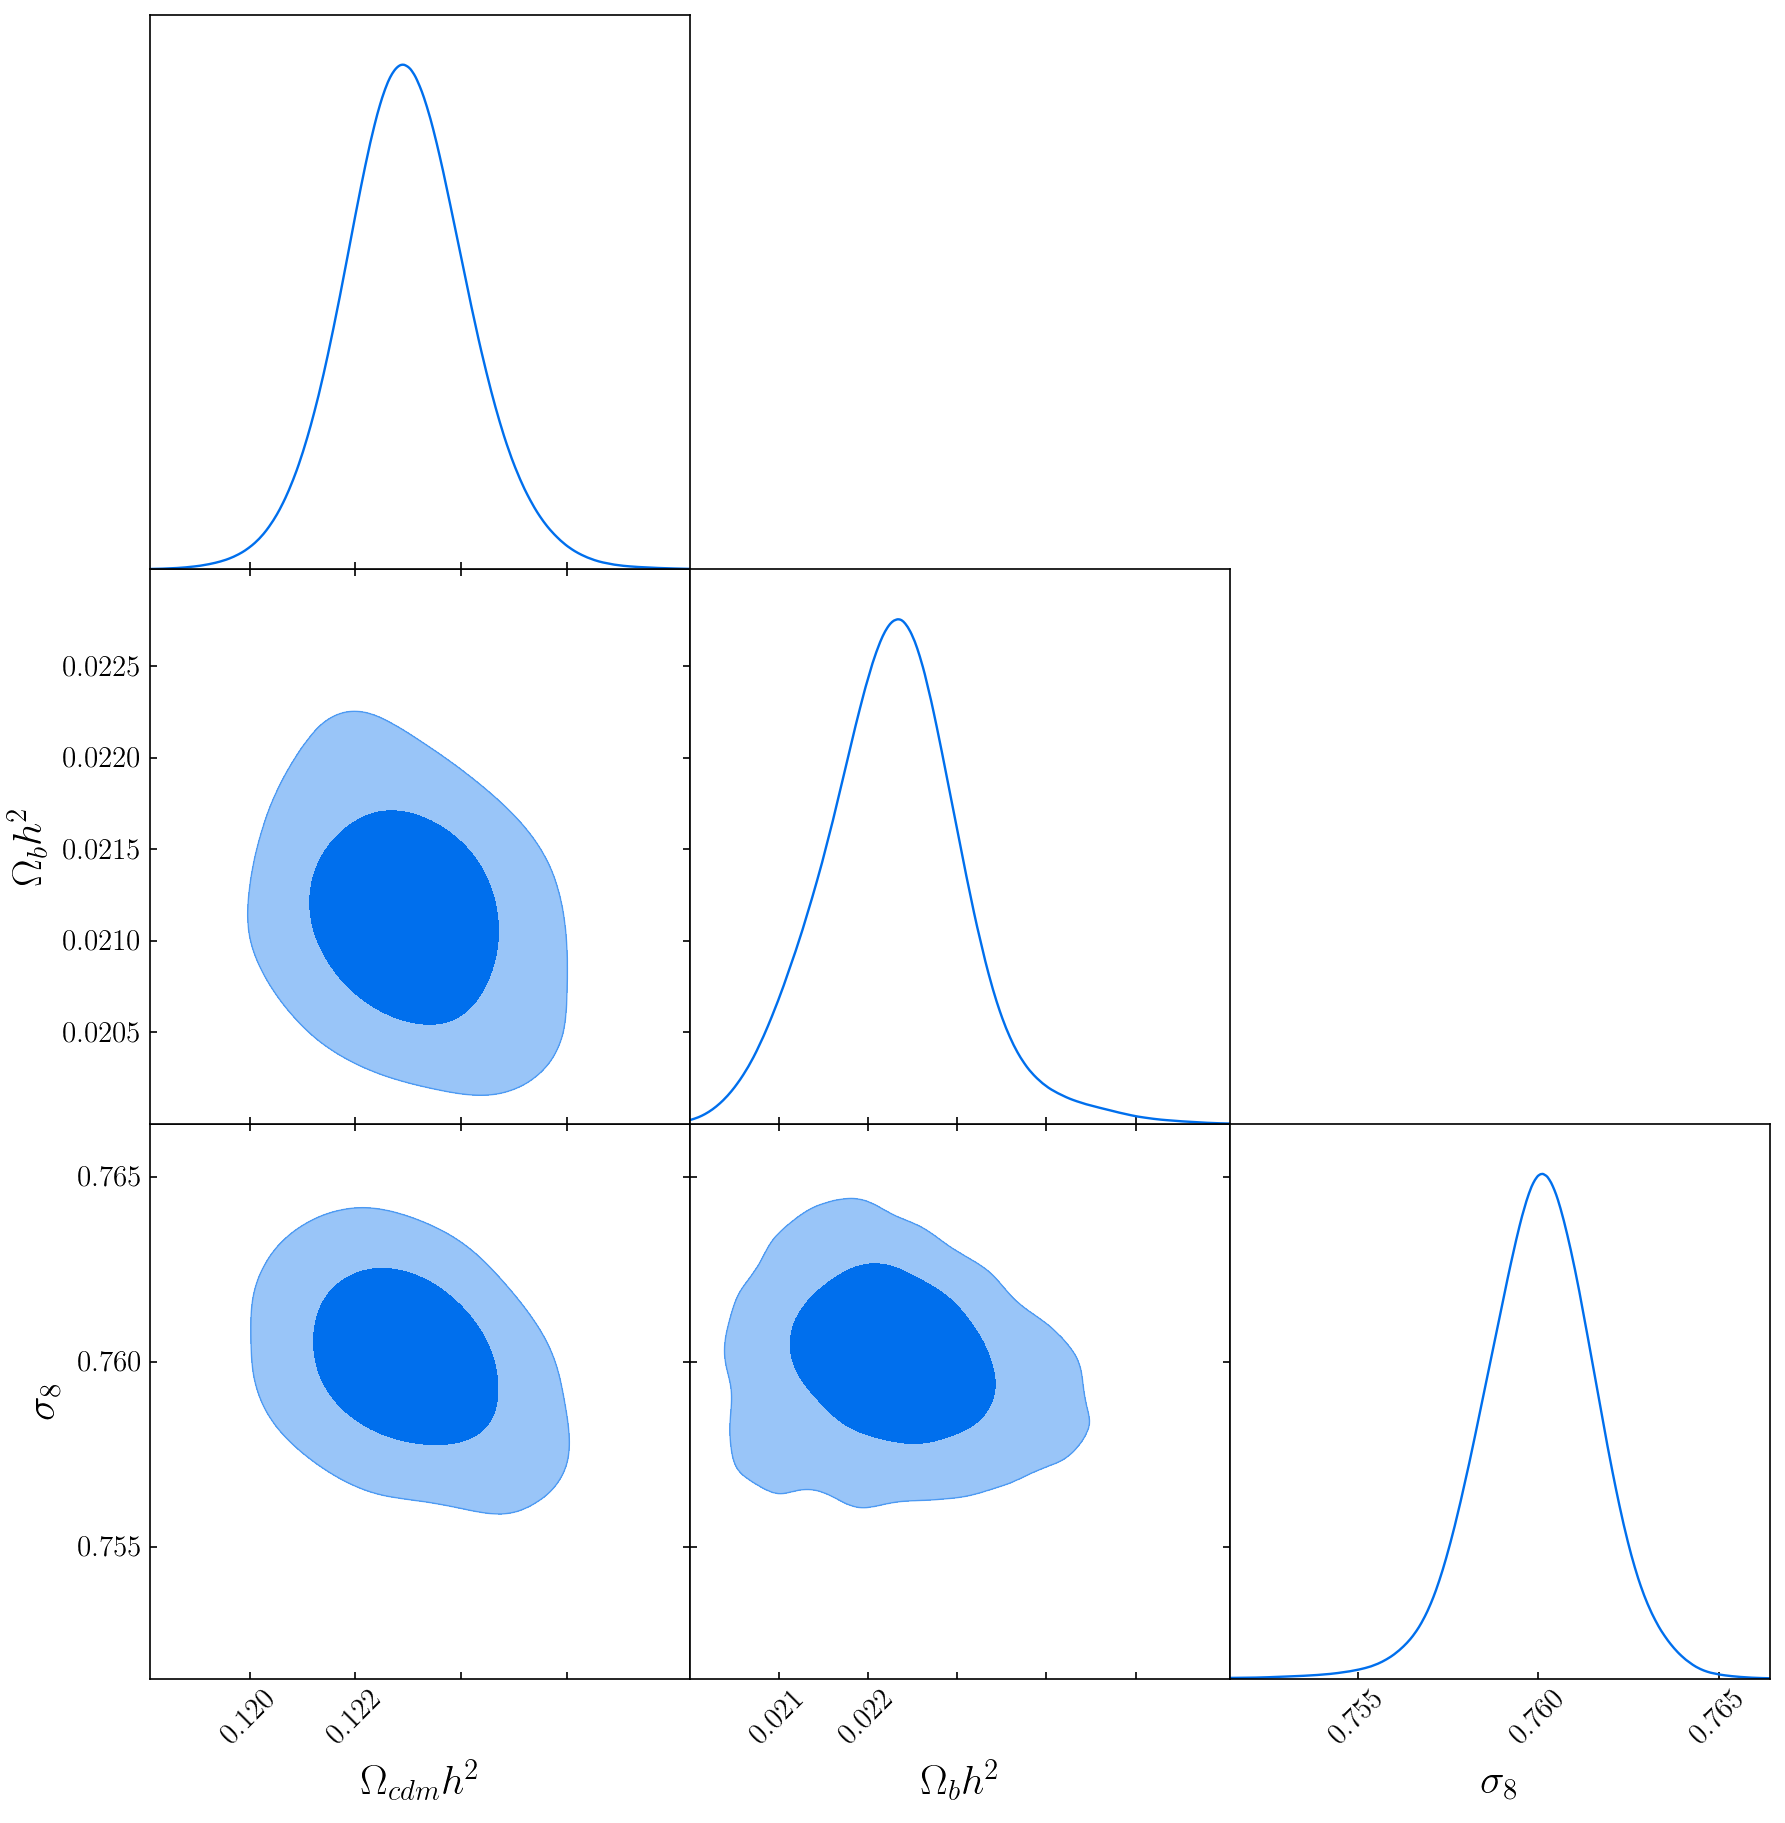

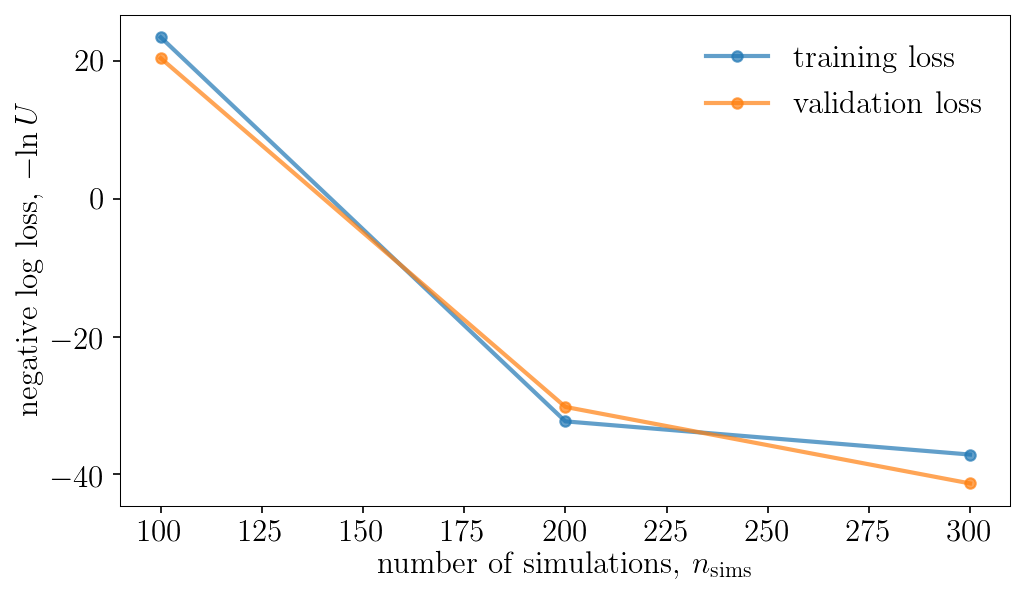

Population 3/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


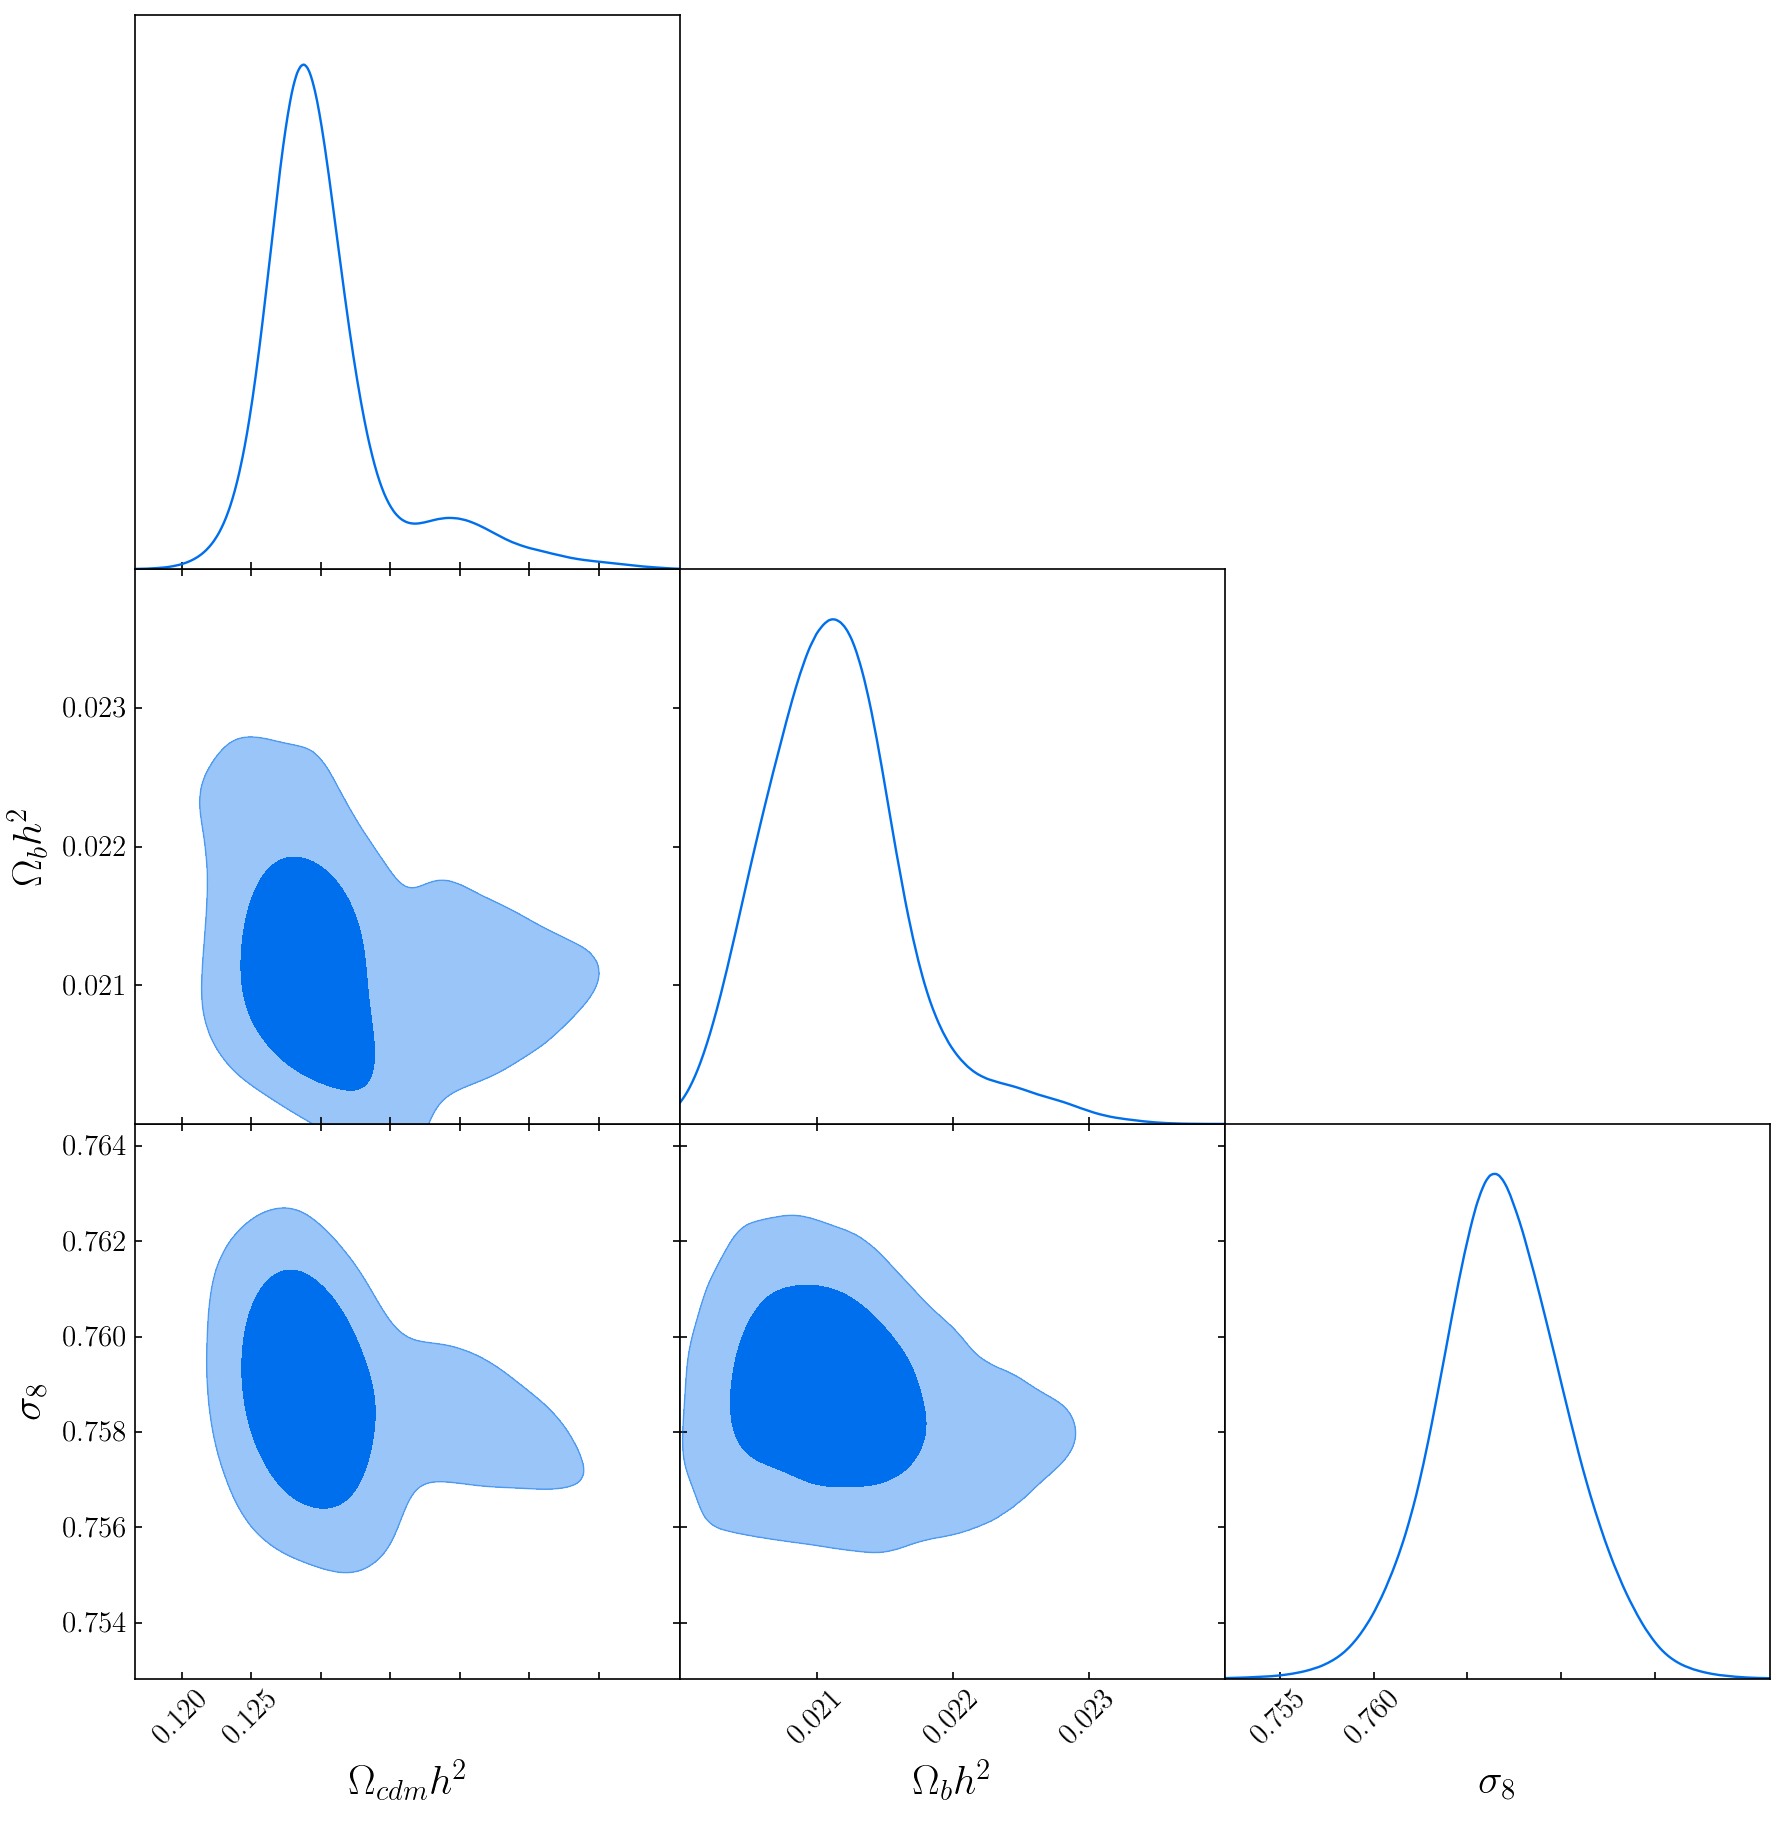

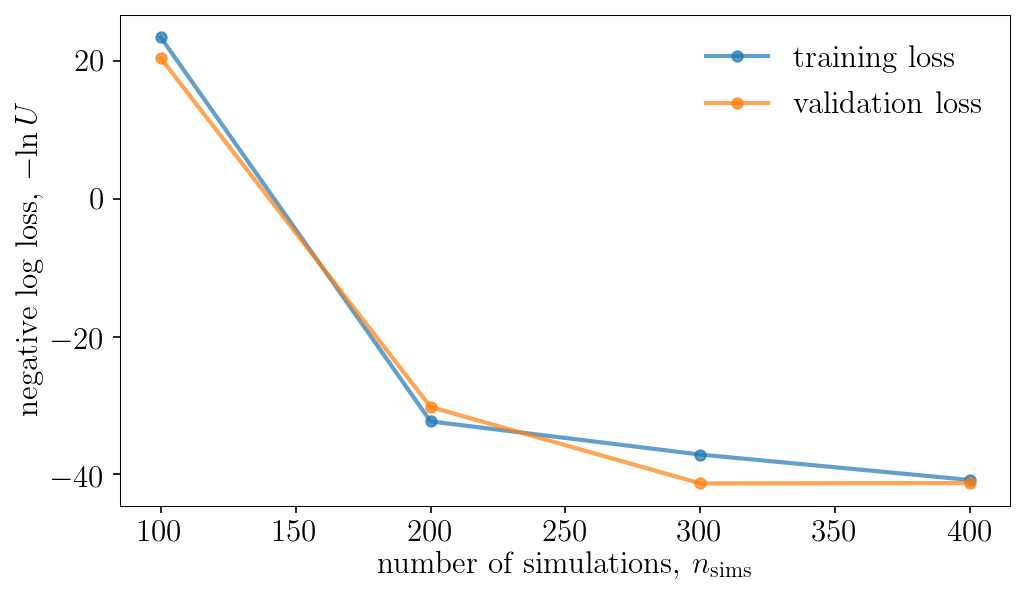

Population 4/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


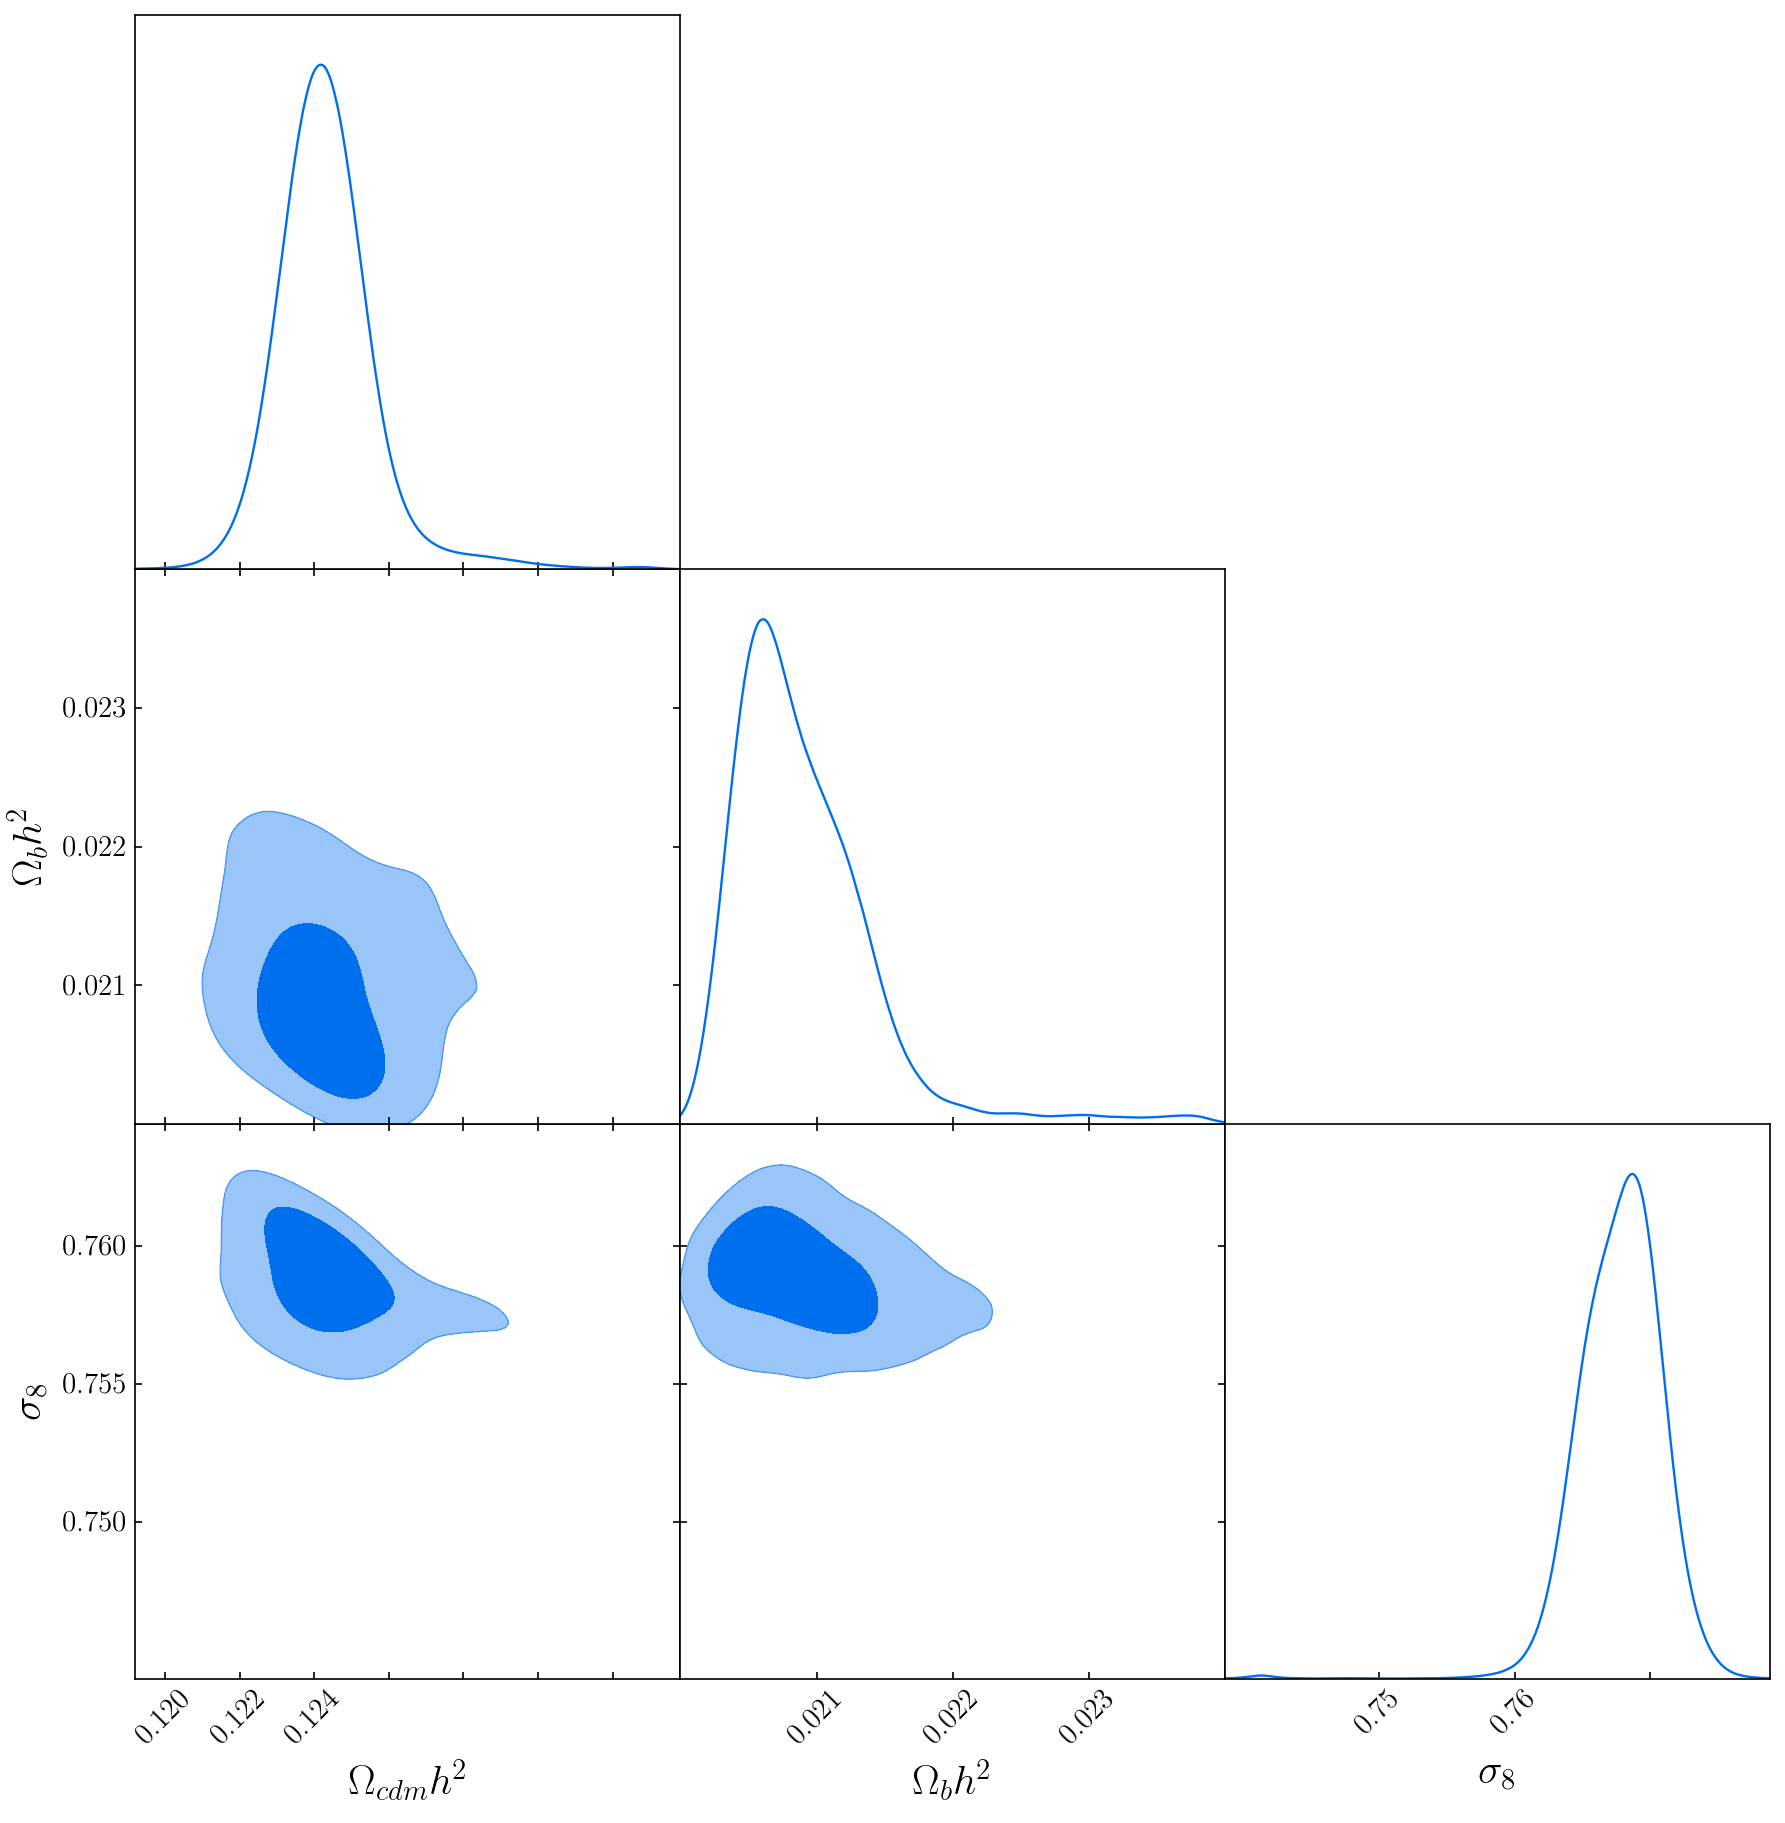

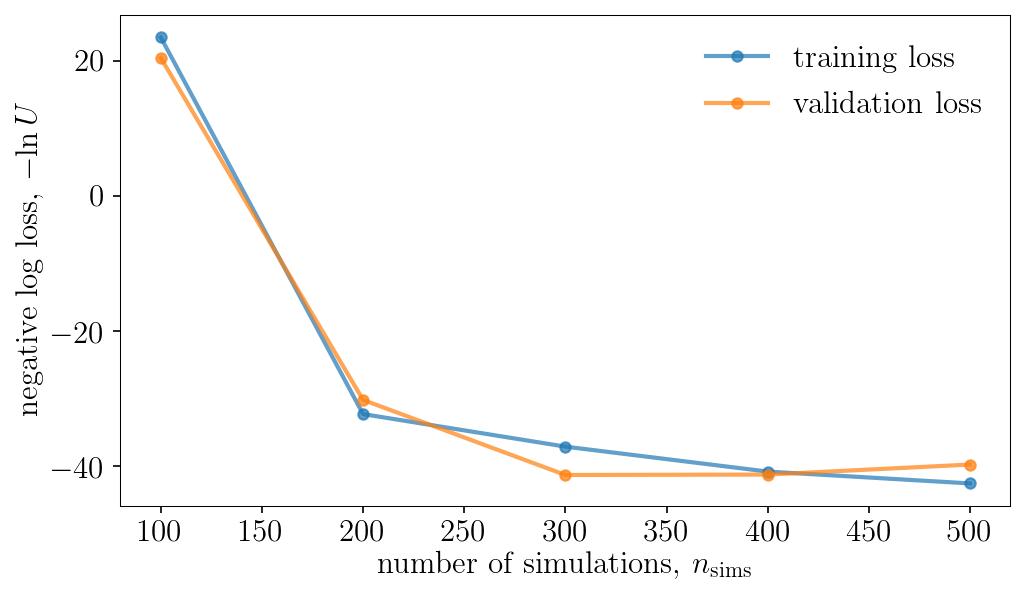

Population 5/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


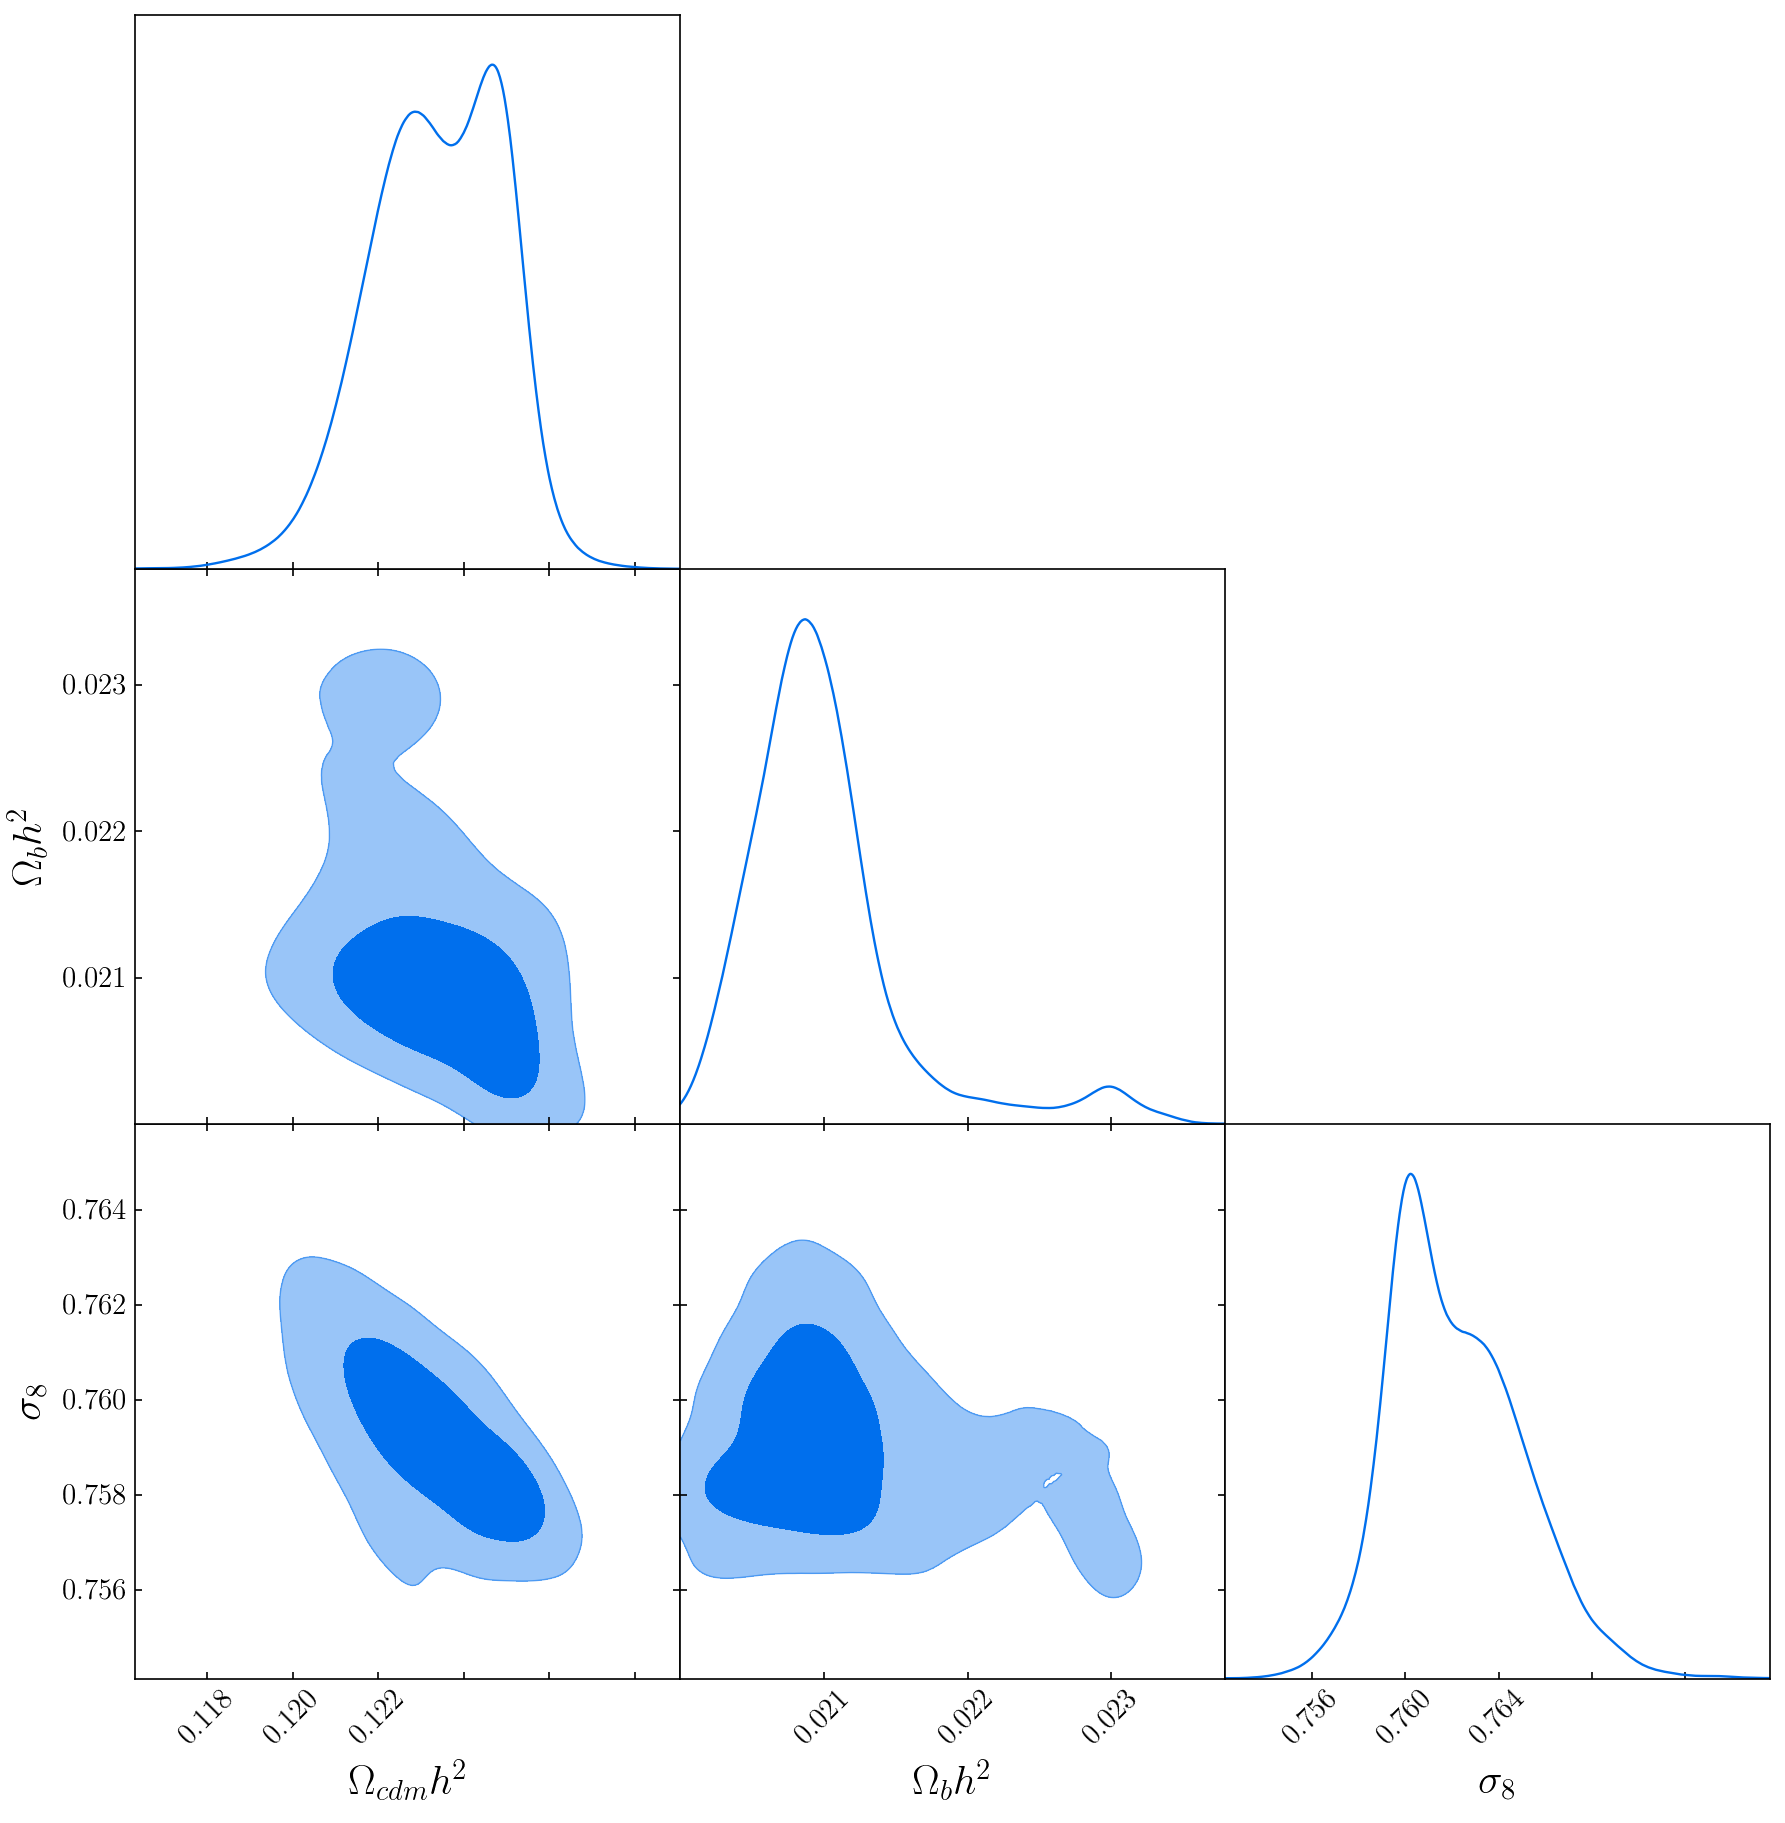

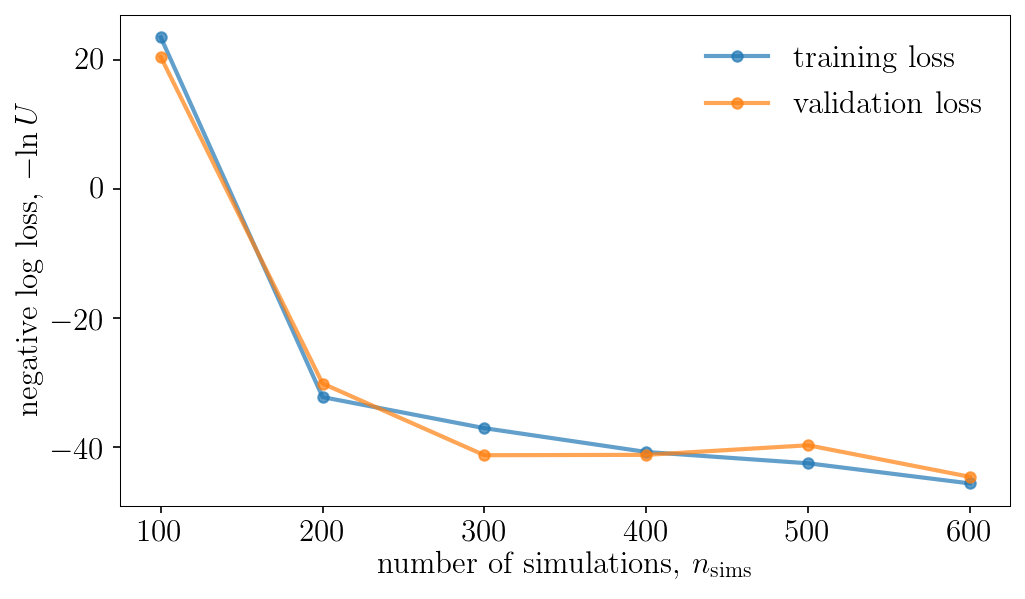

Population 6/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


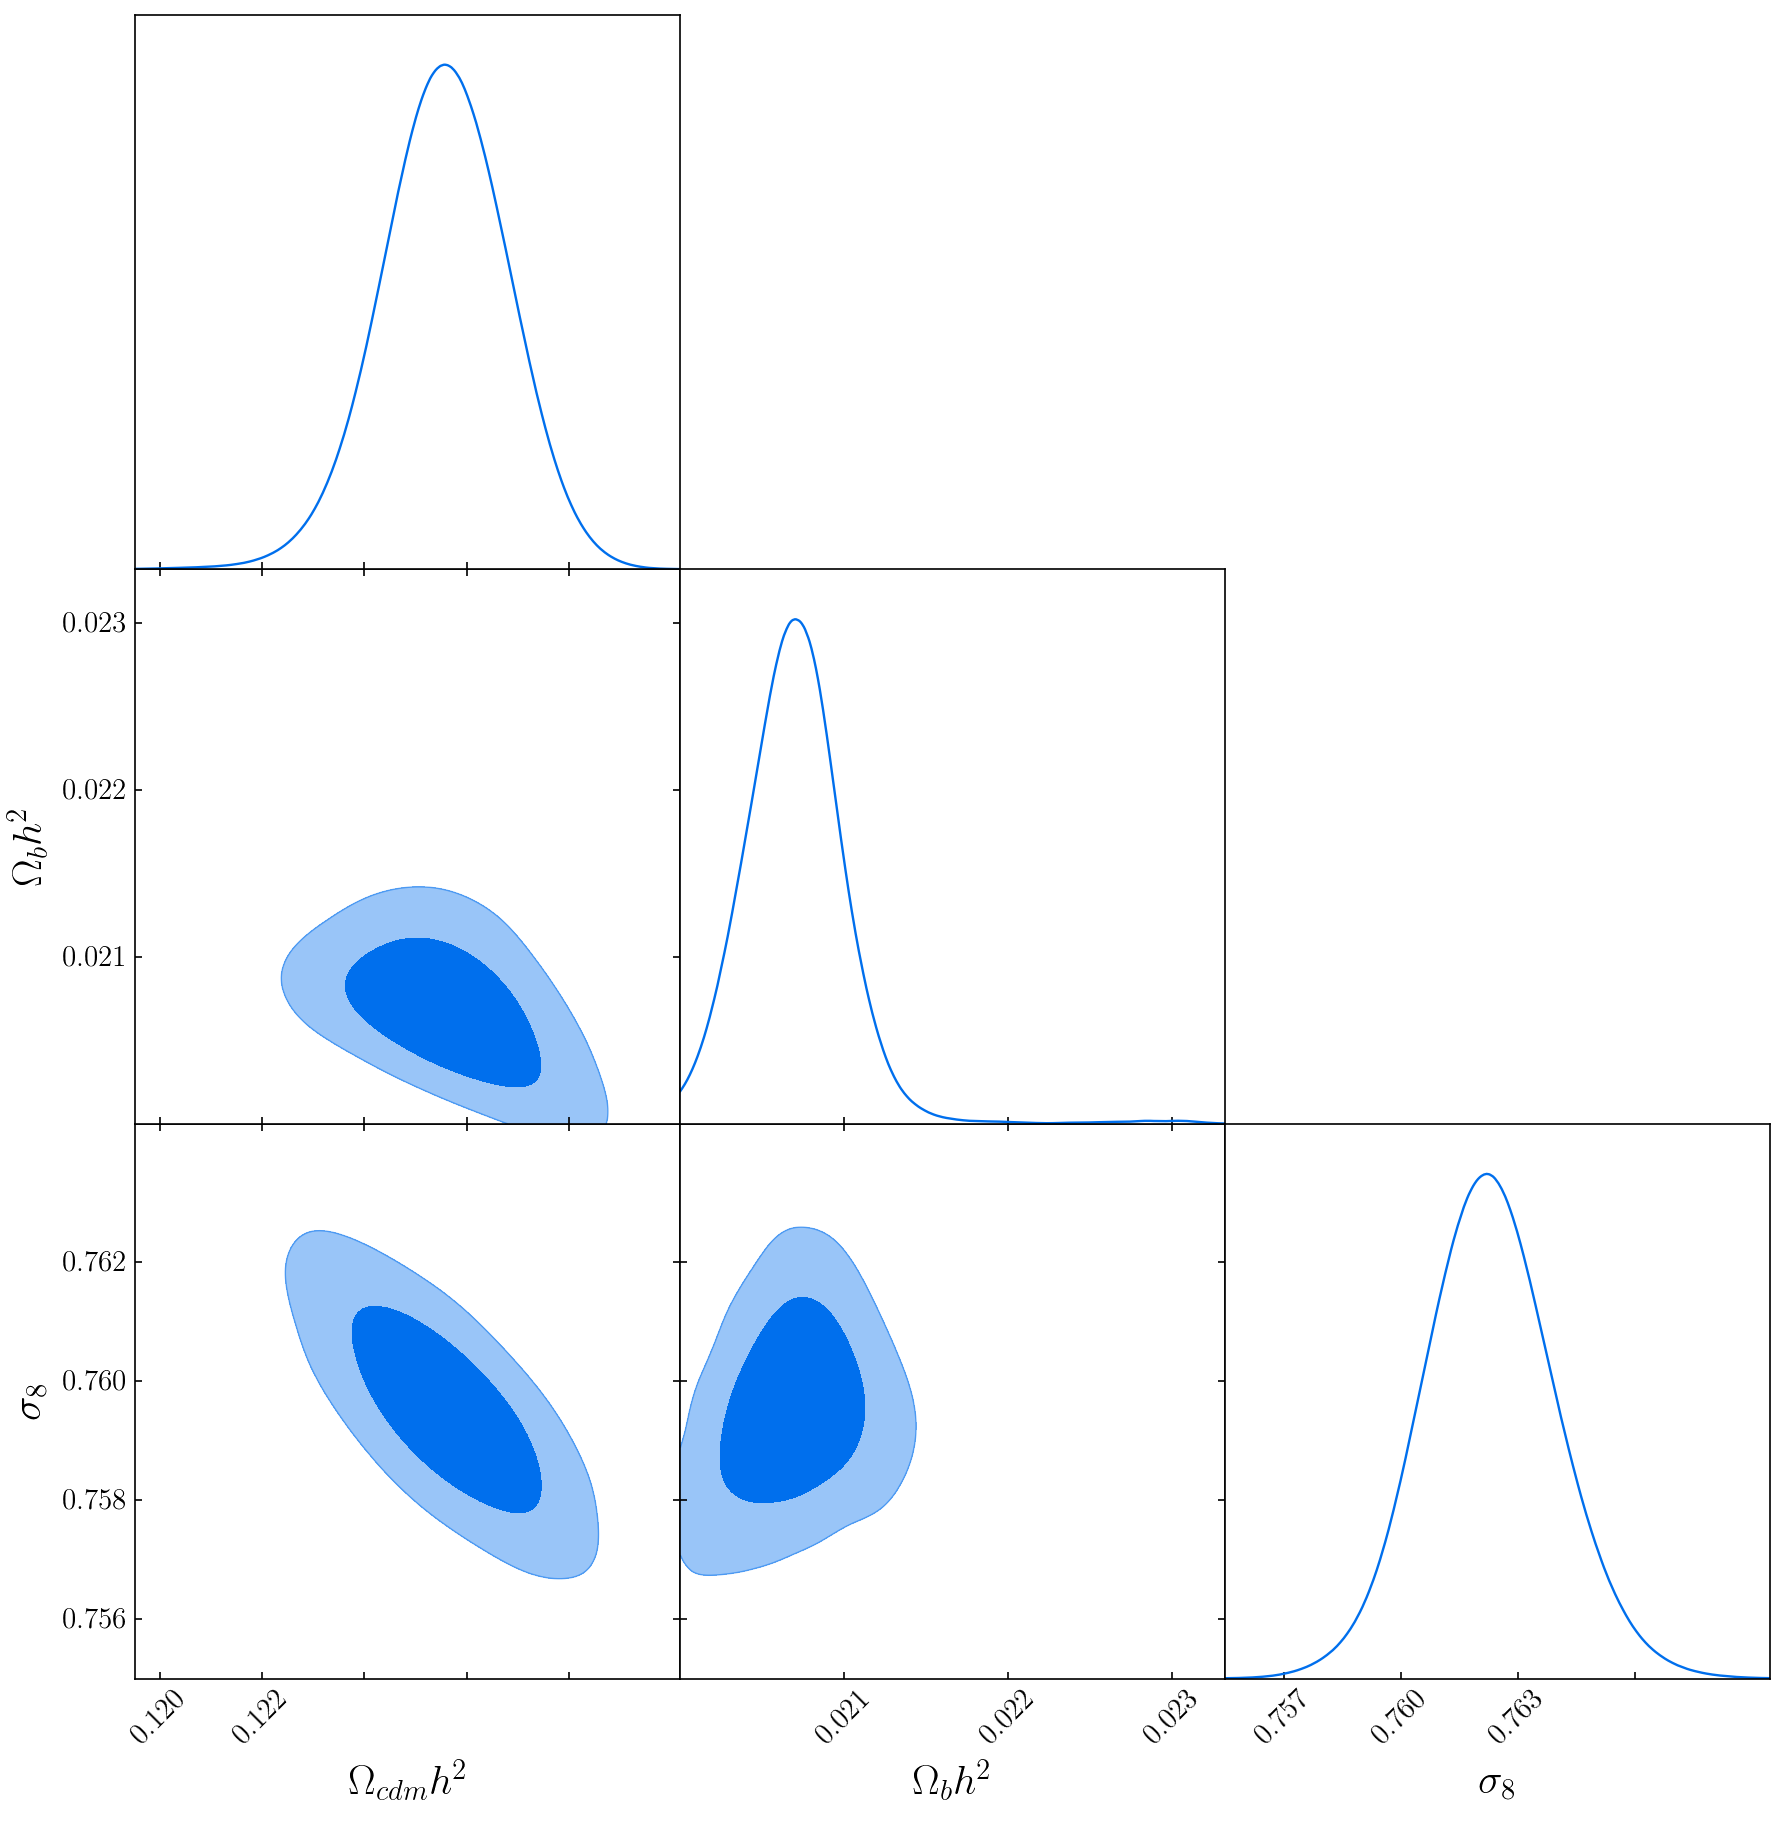

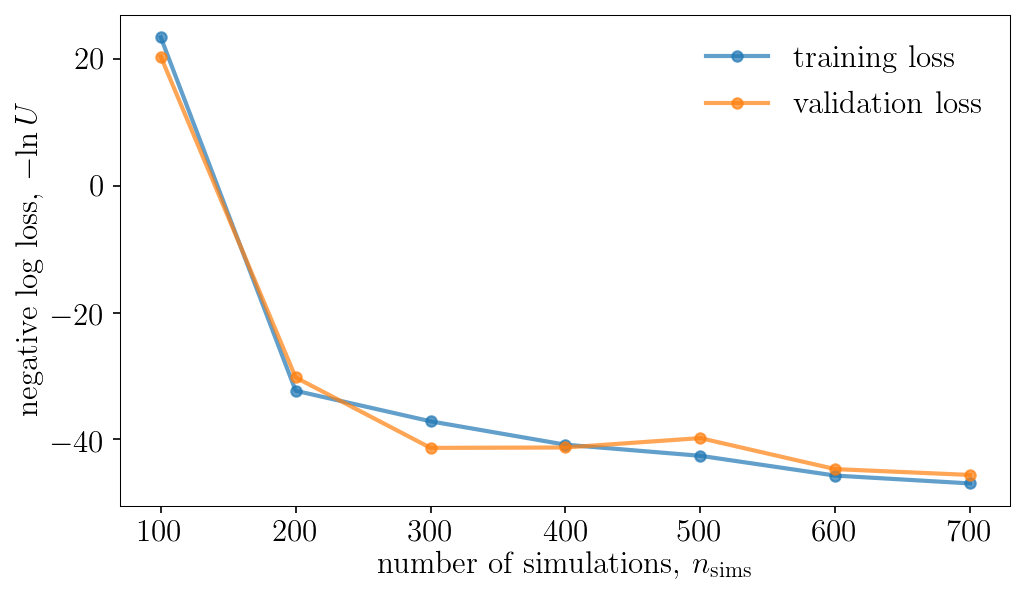

Population 7/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


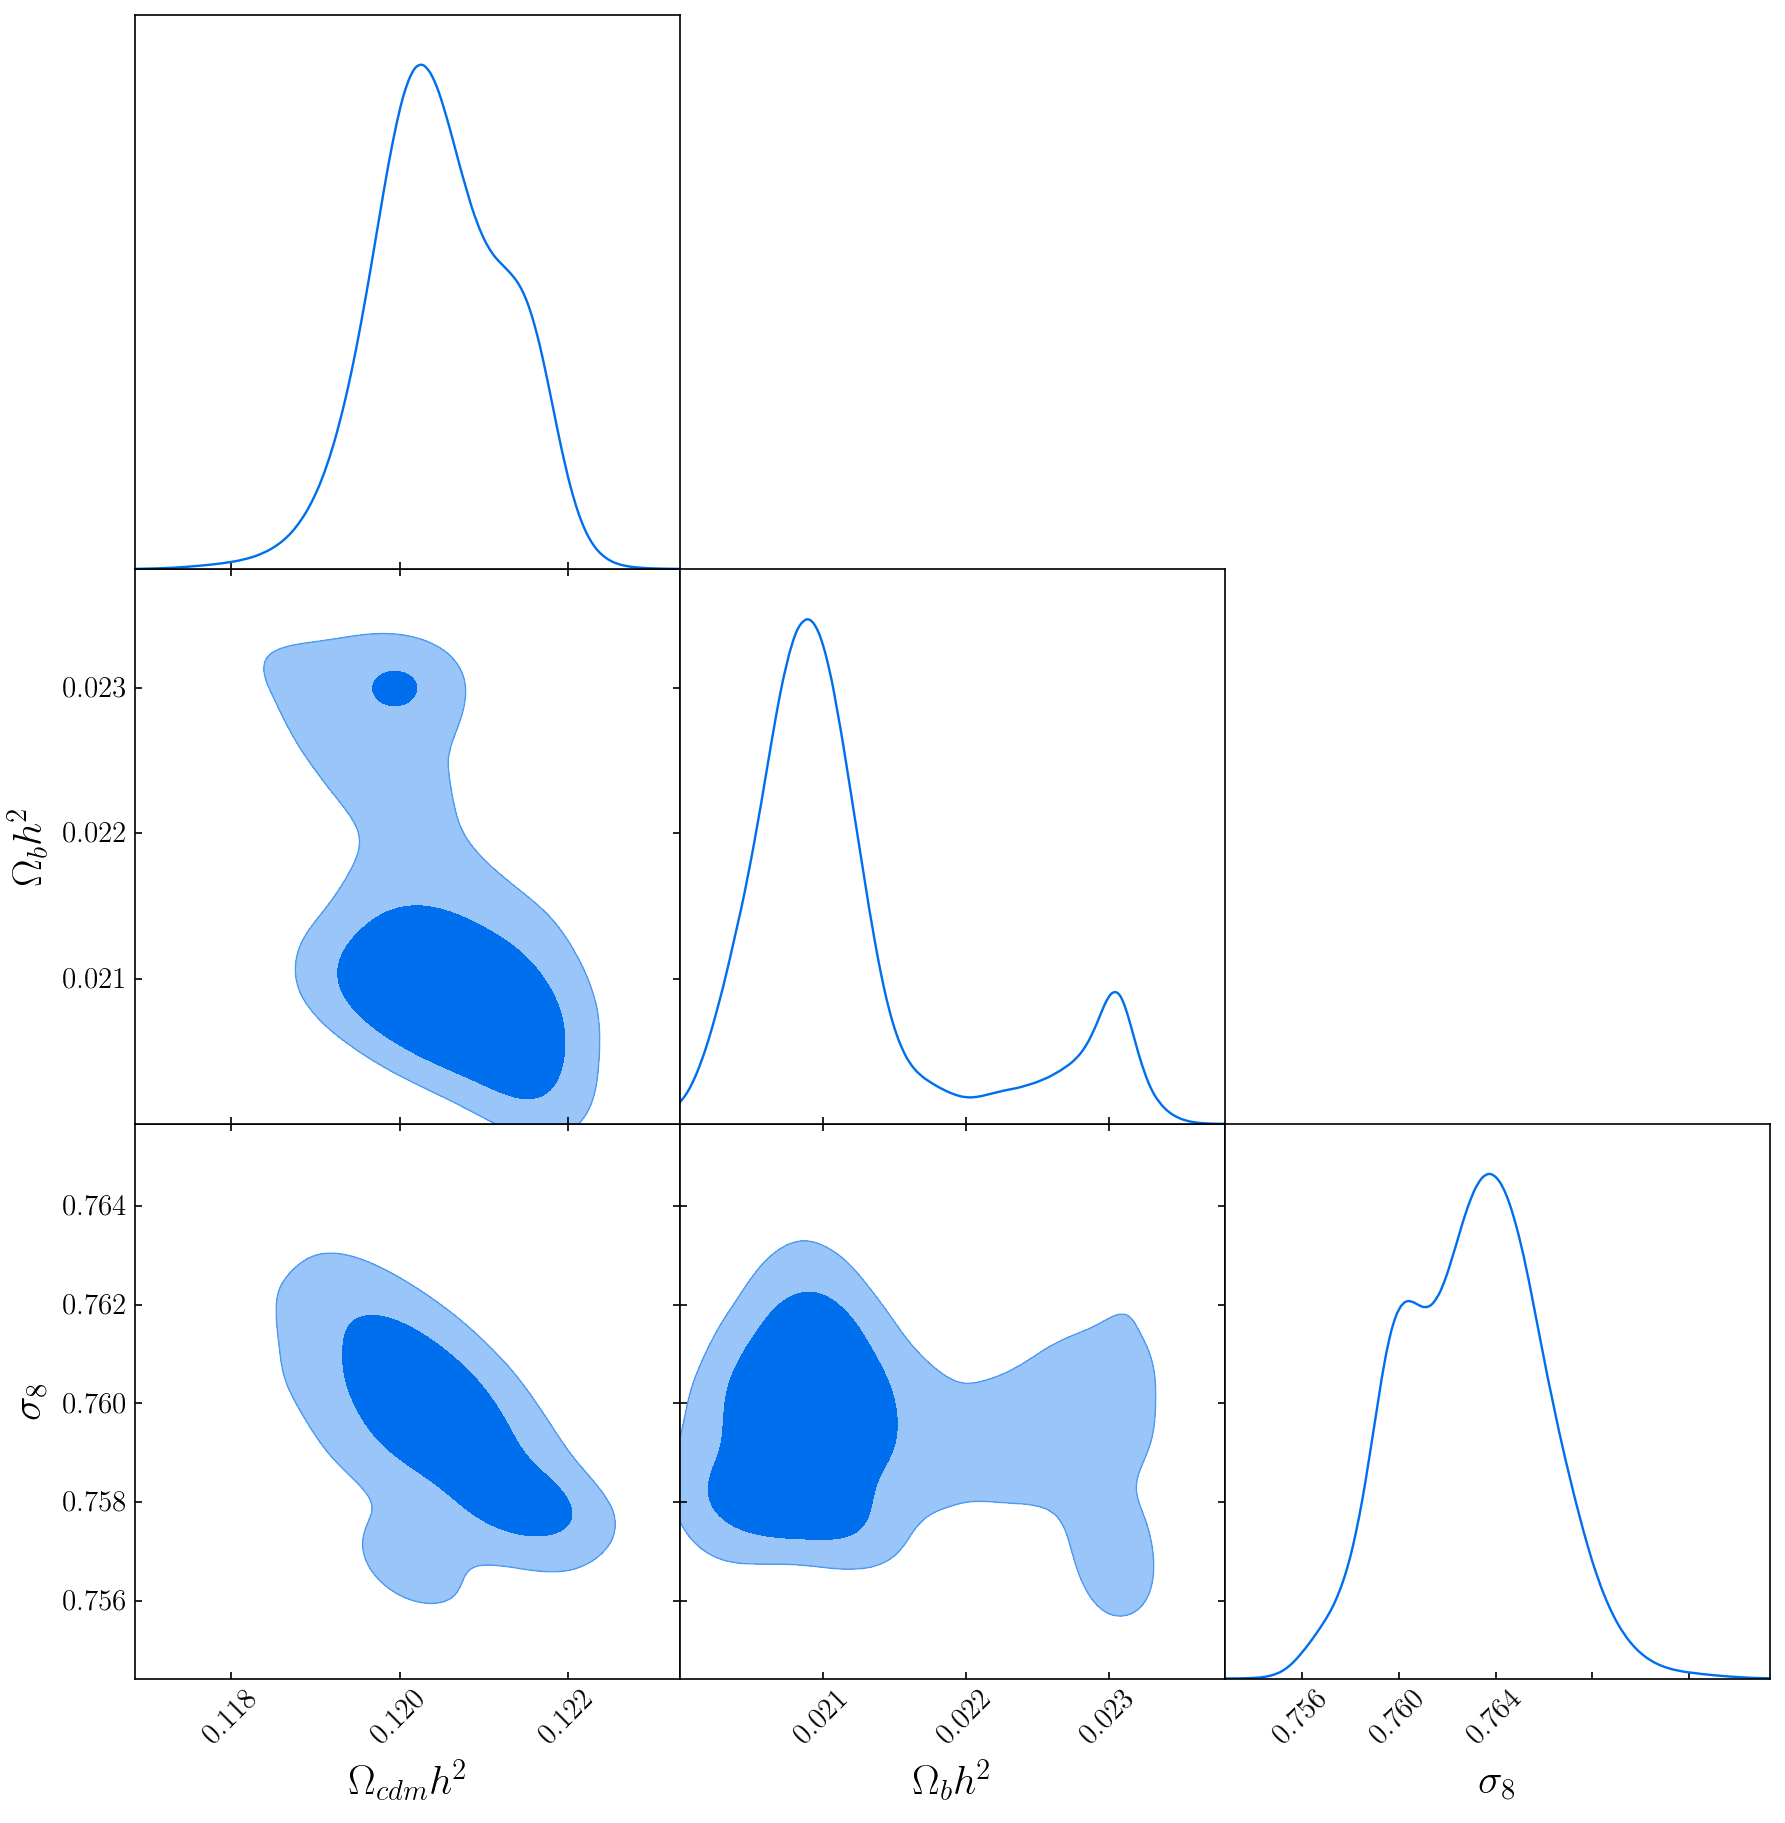

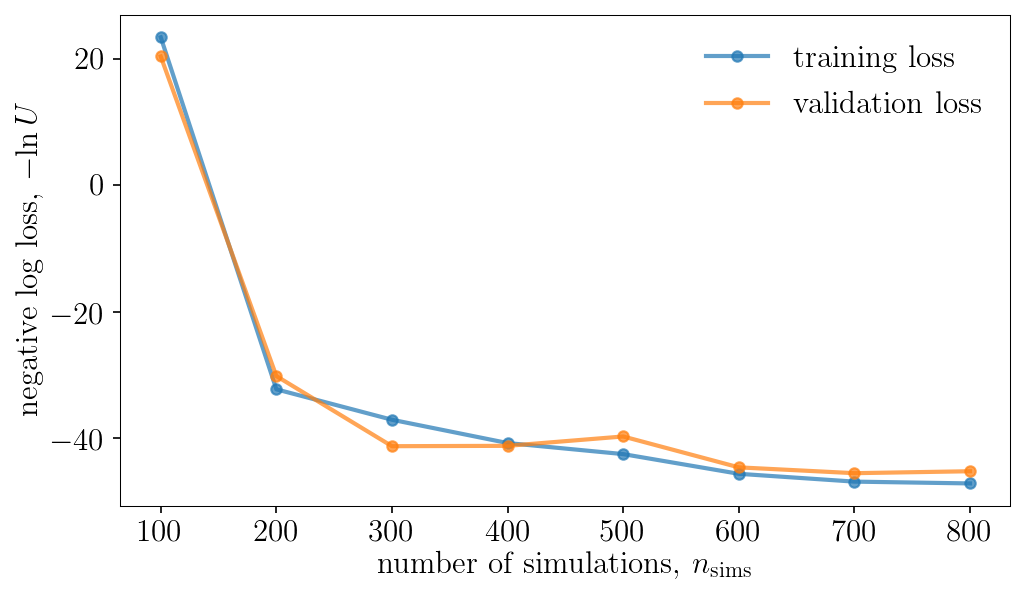

Population 8/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


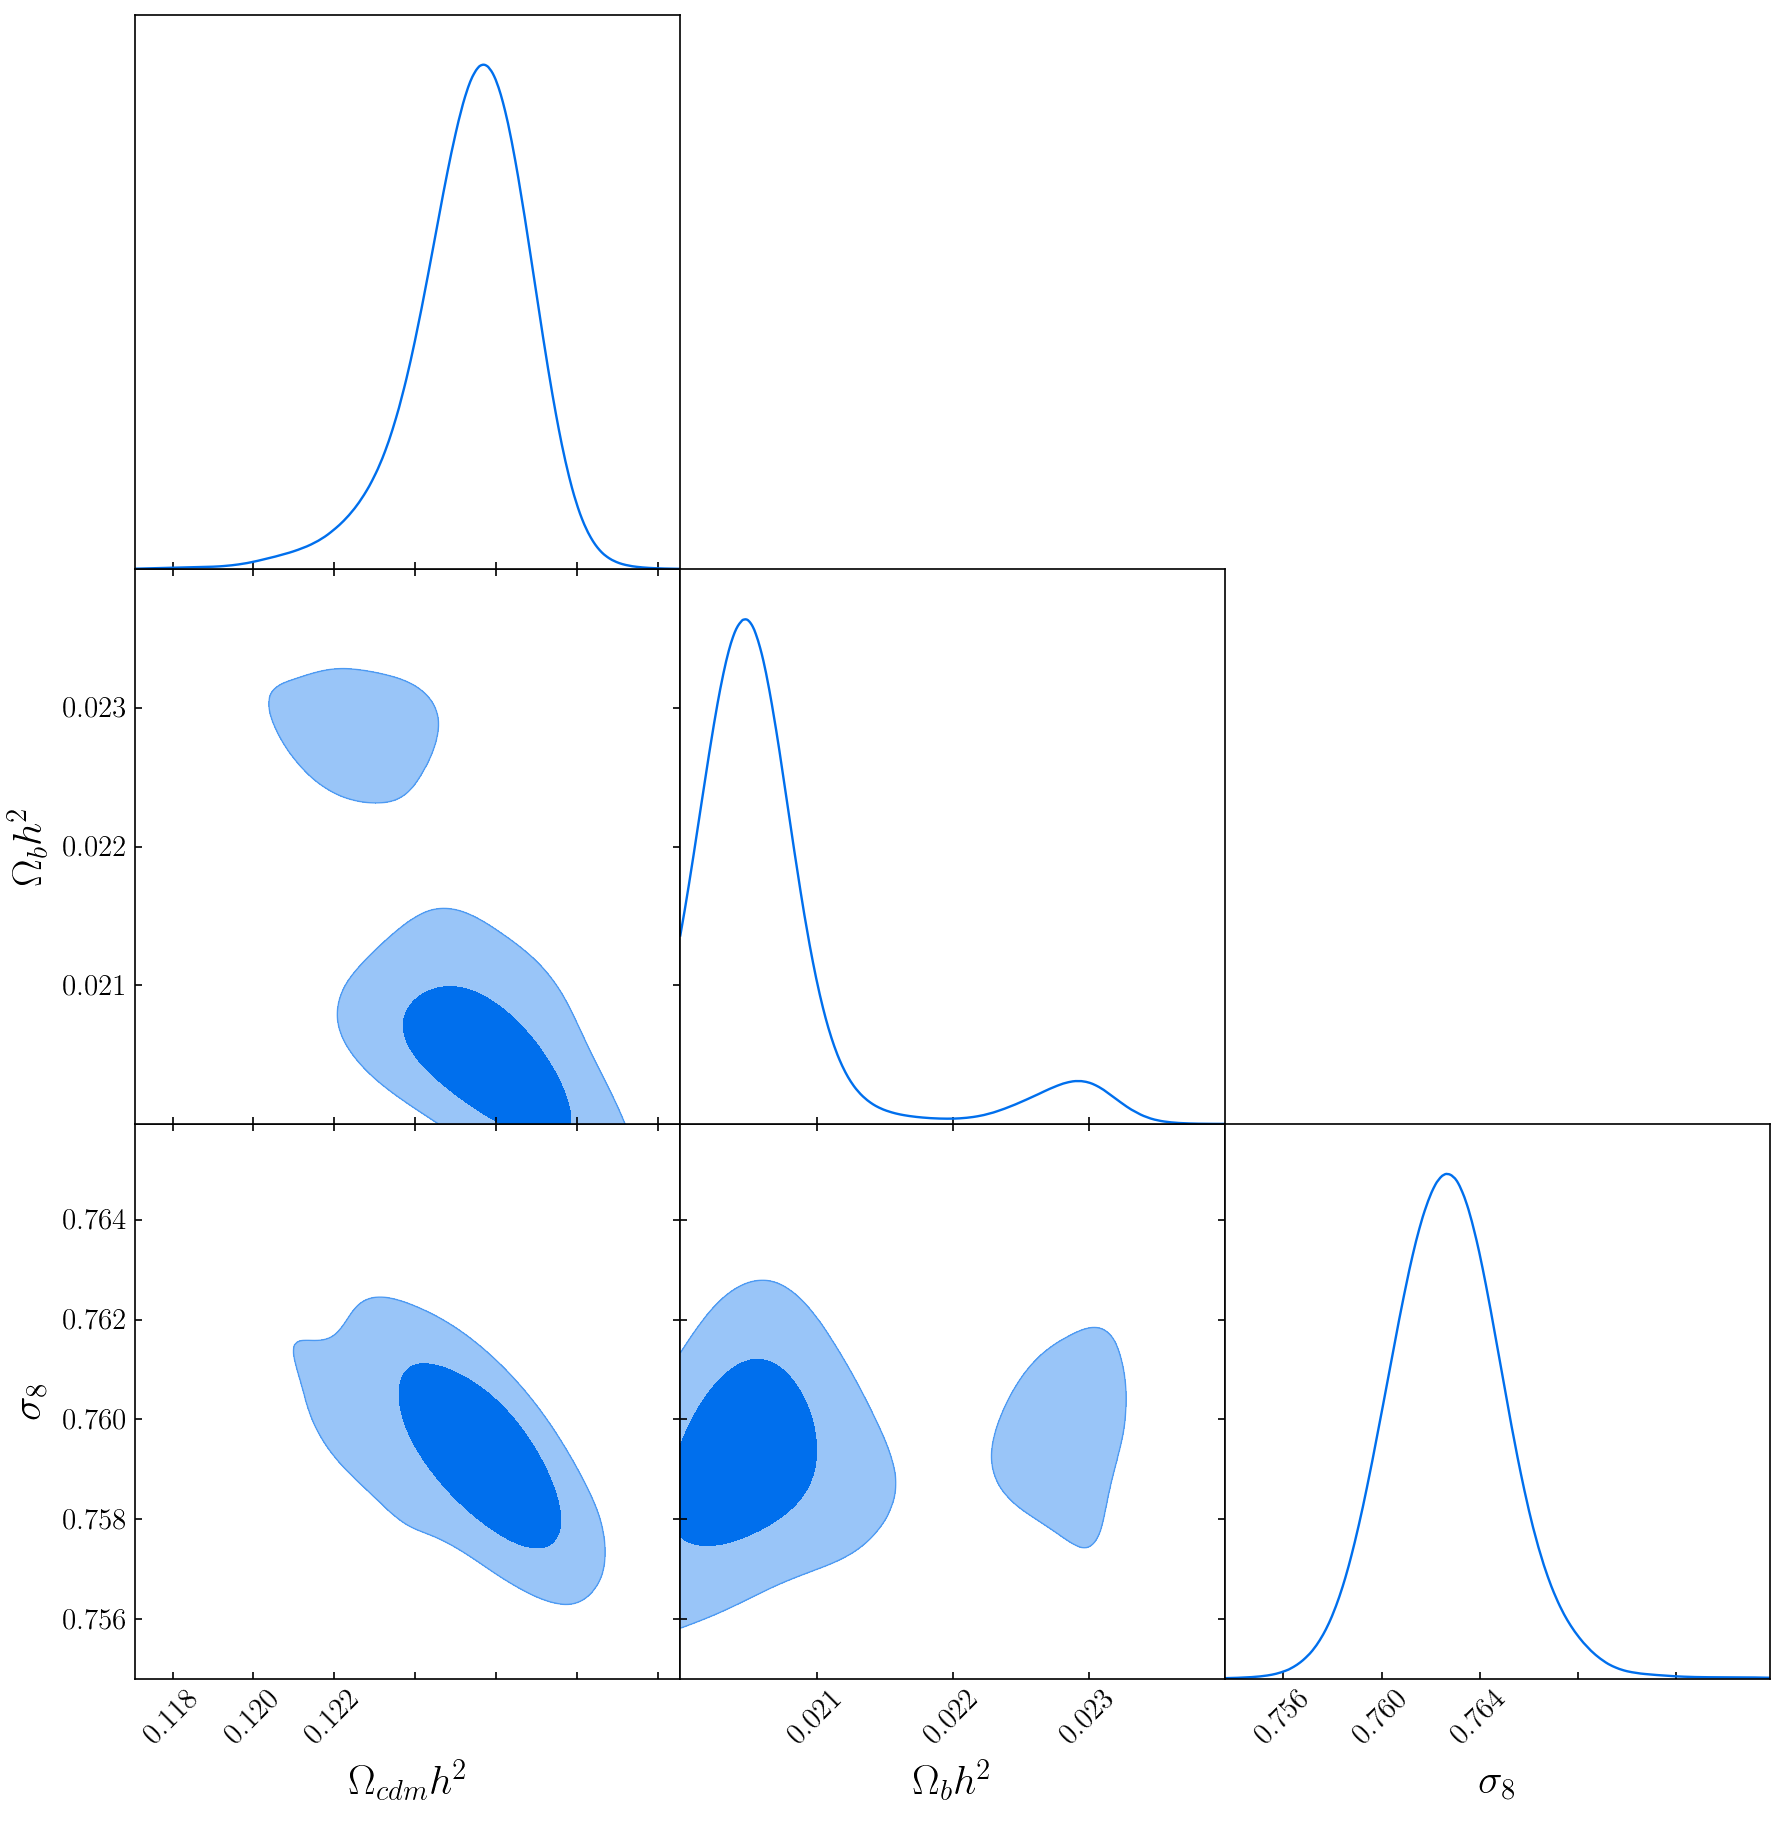

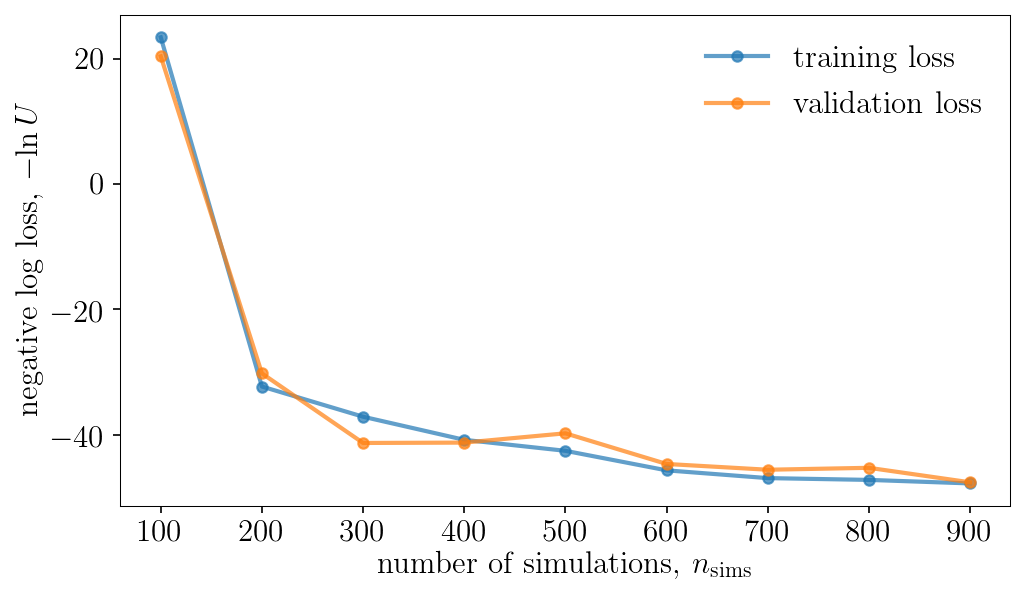

Population 9/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


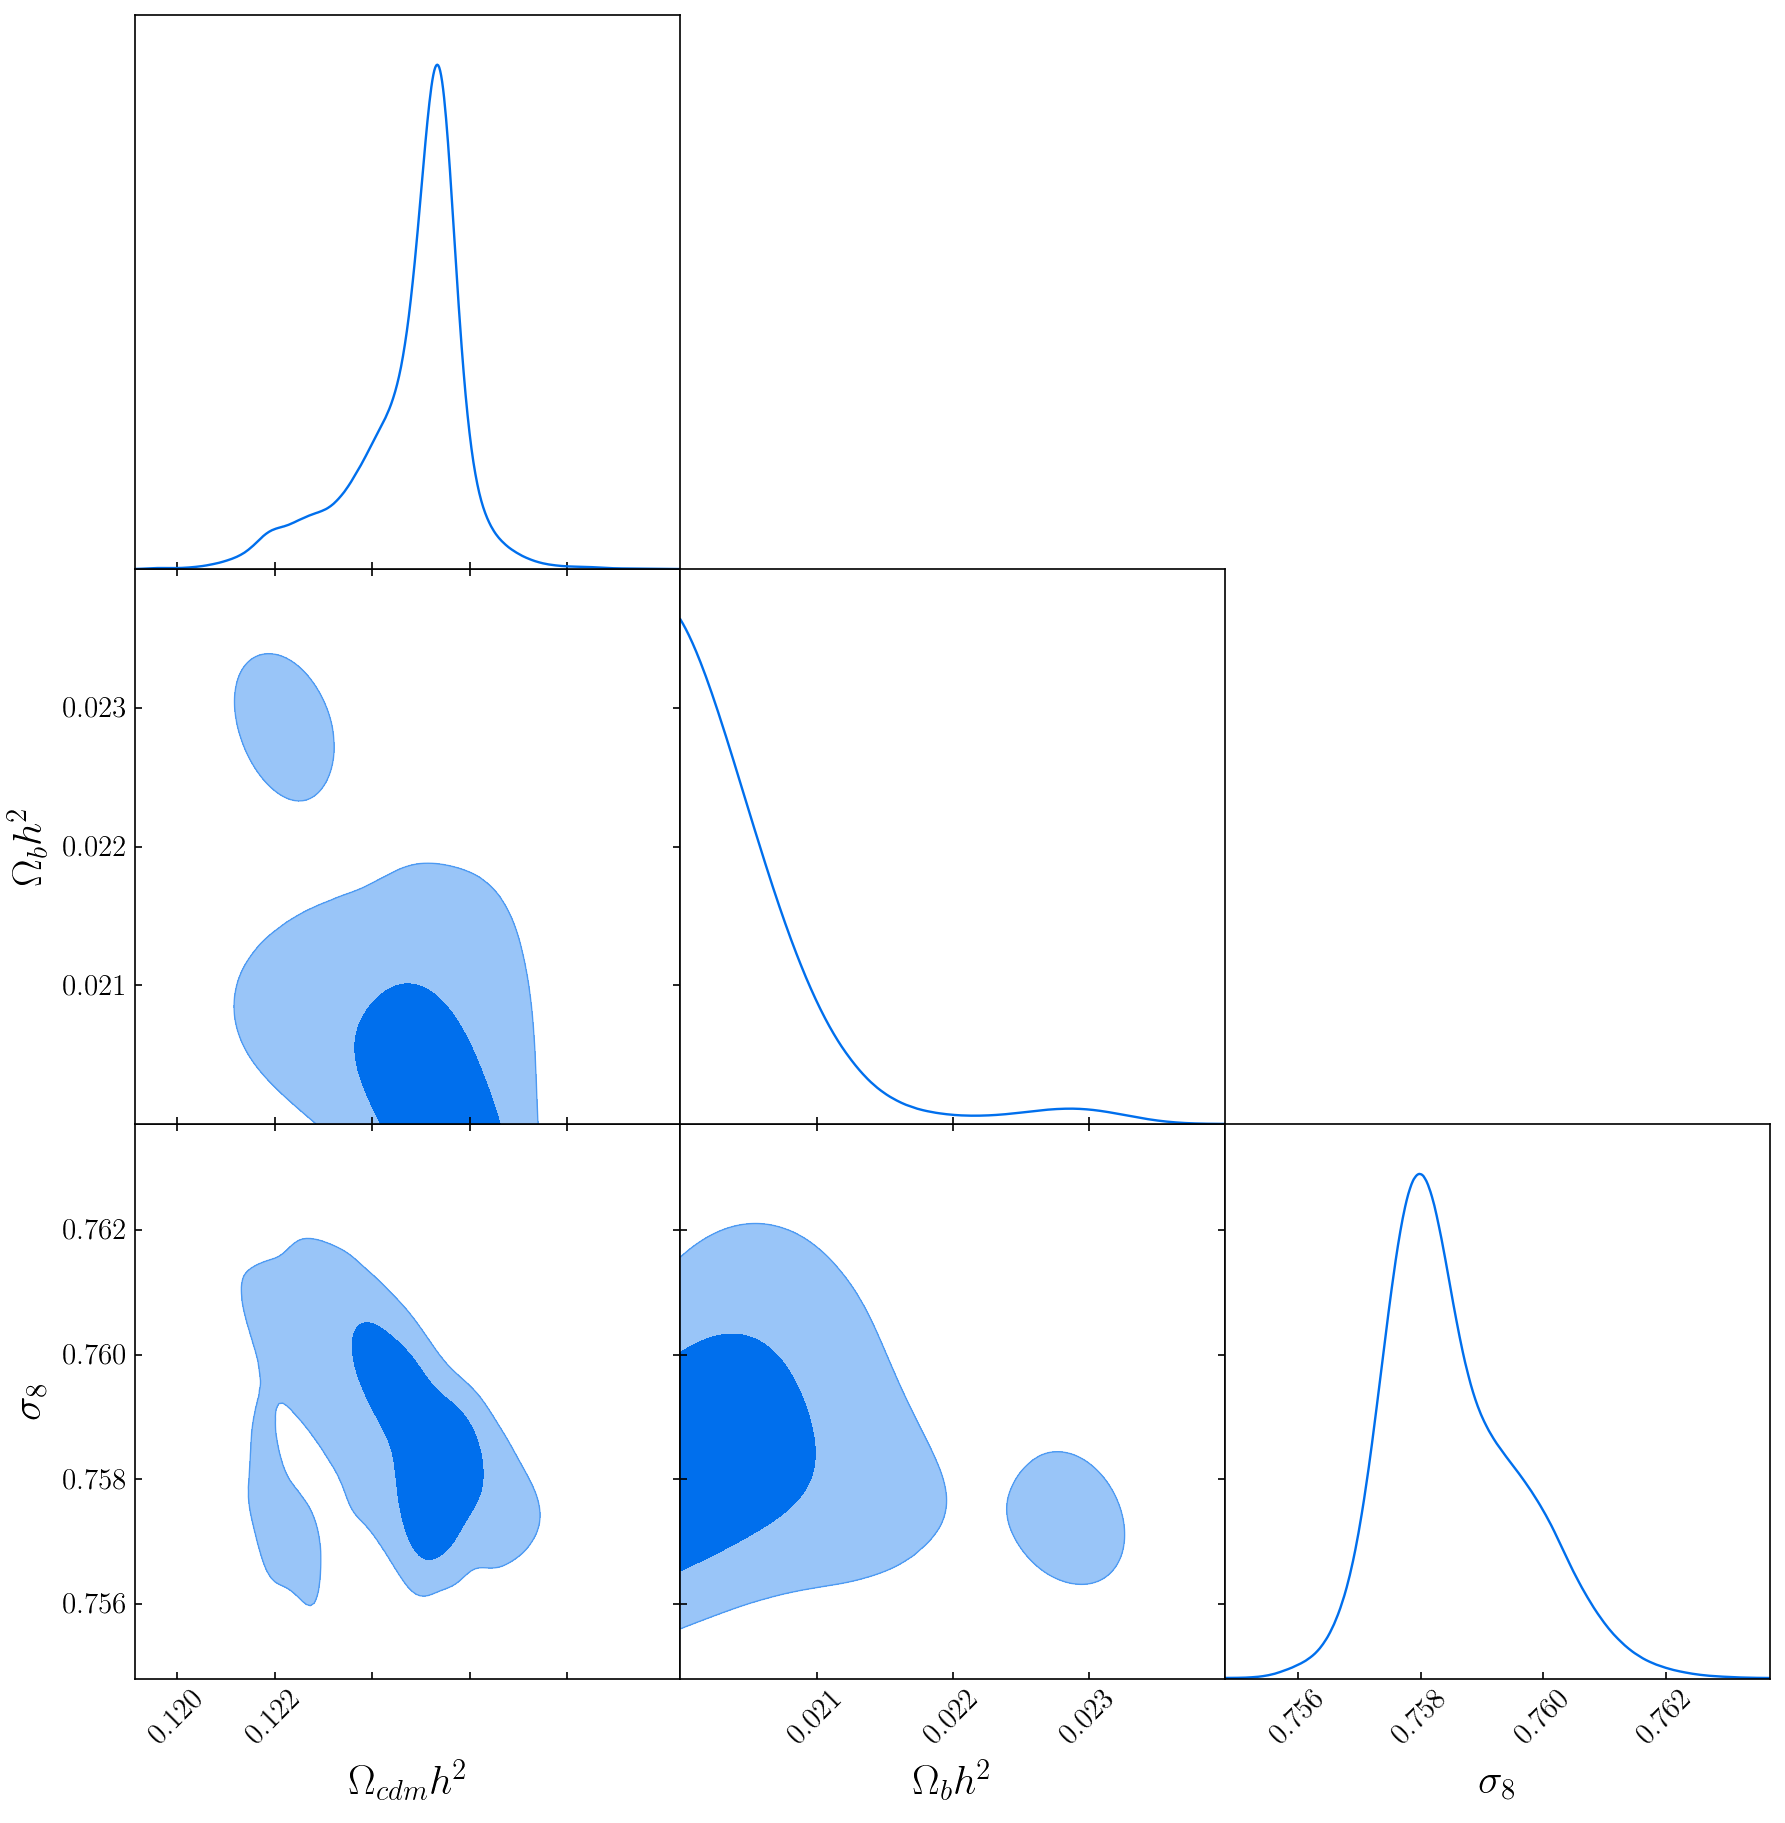

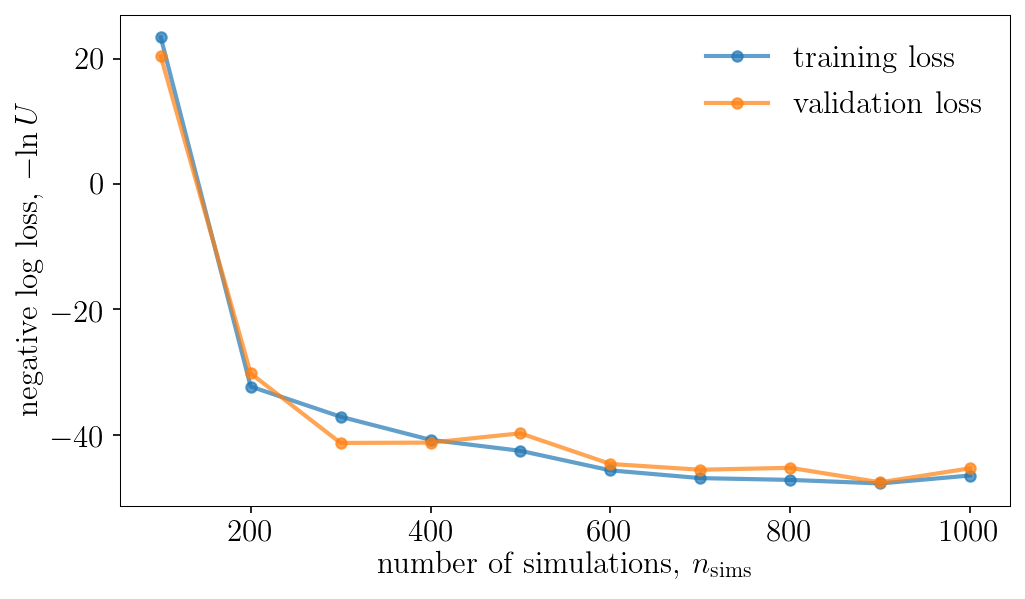

Population 10/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


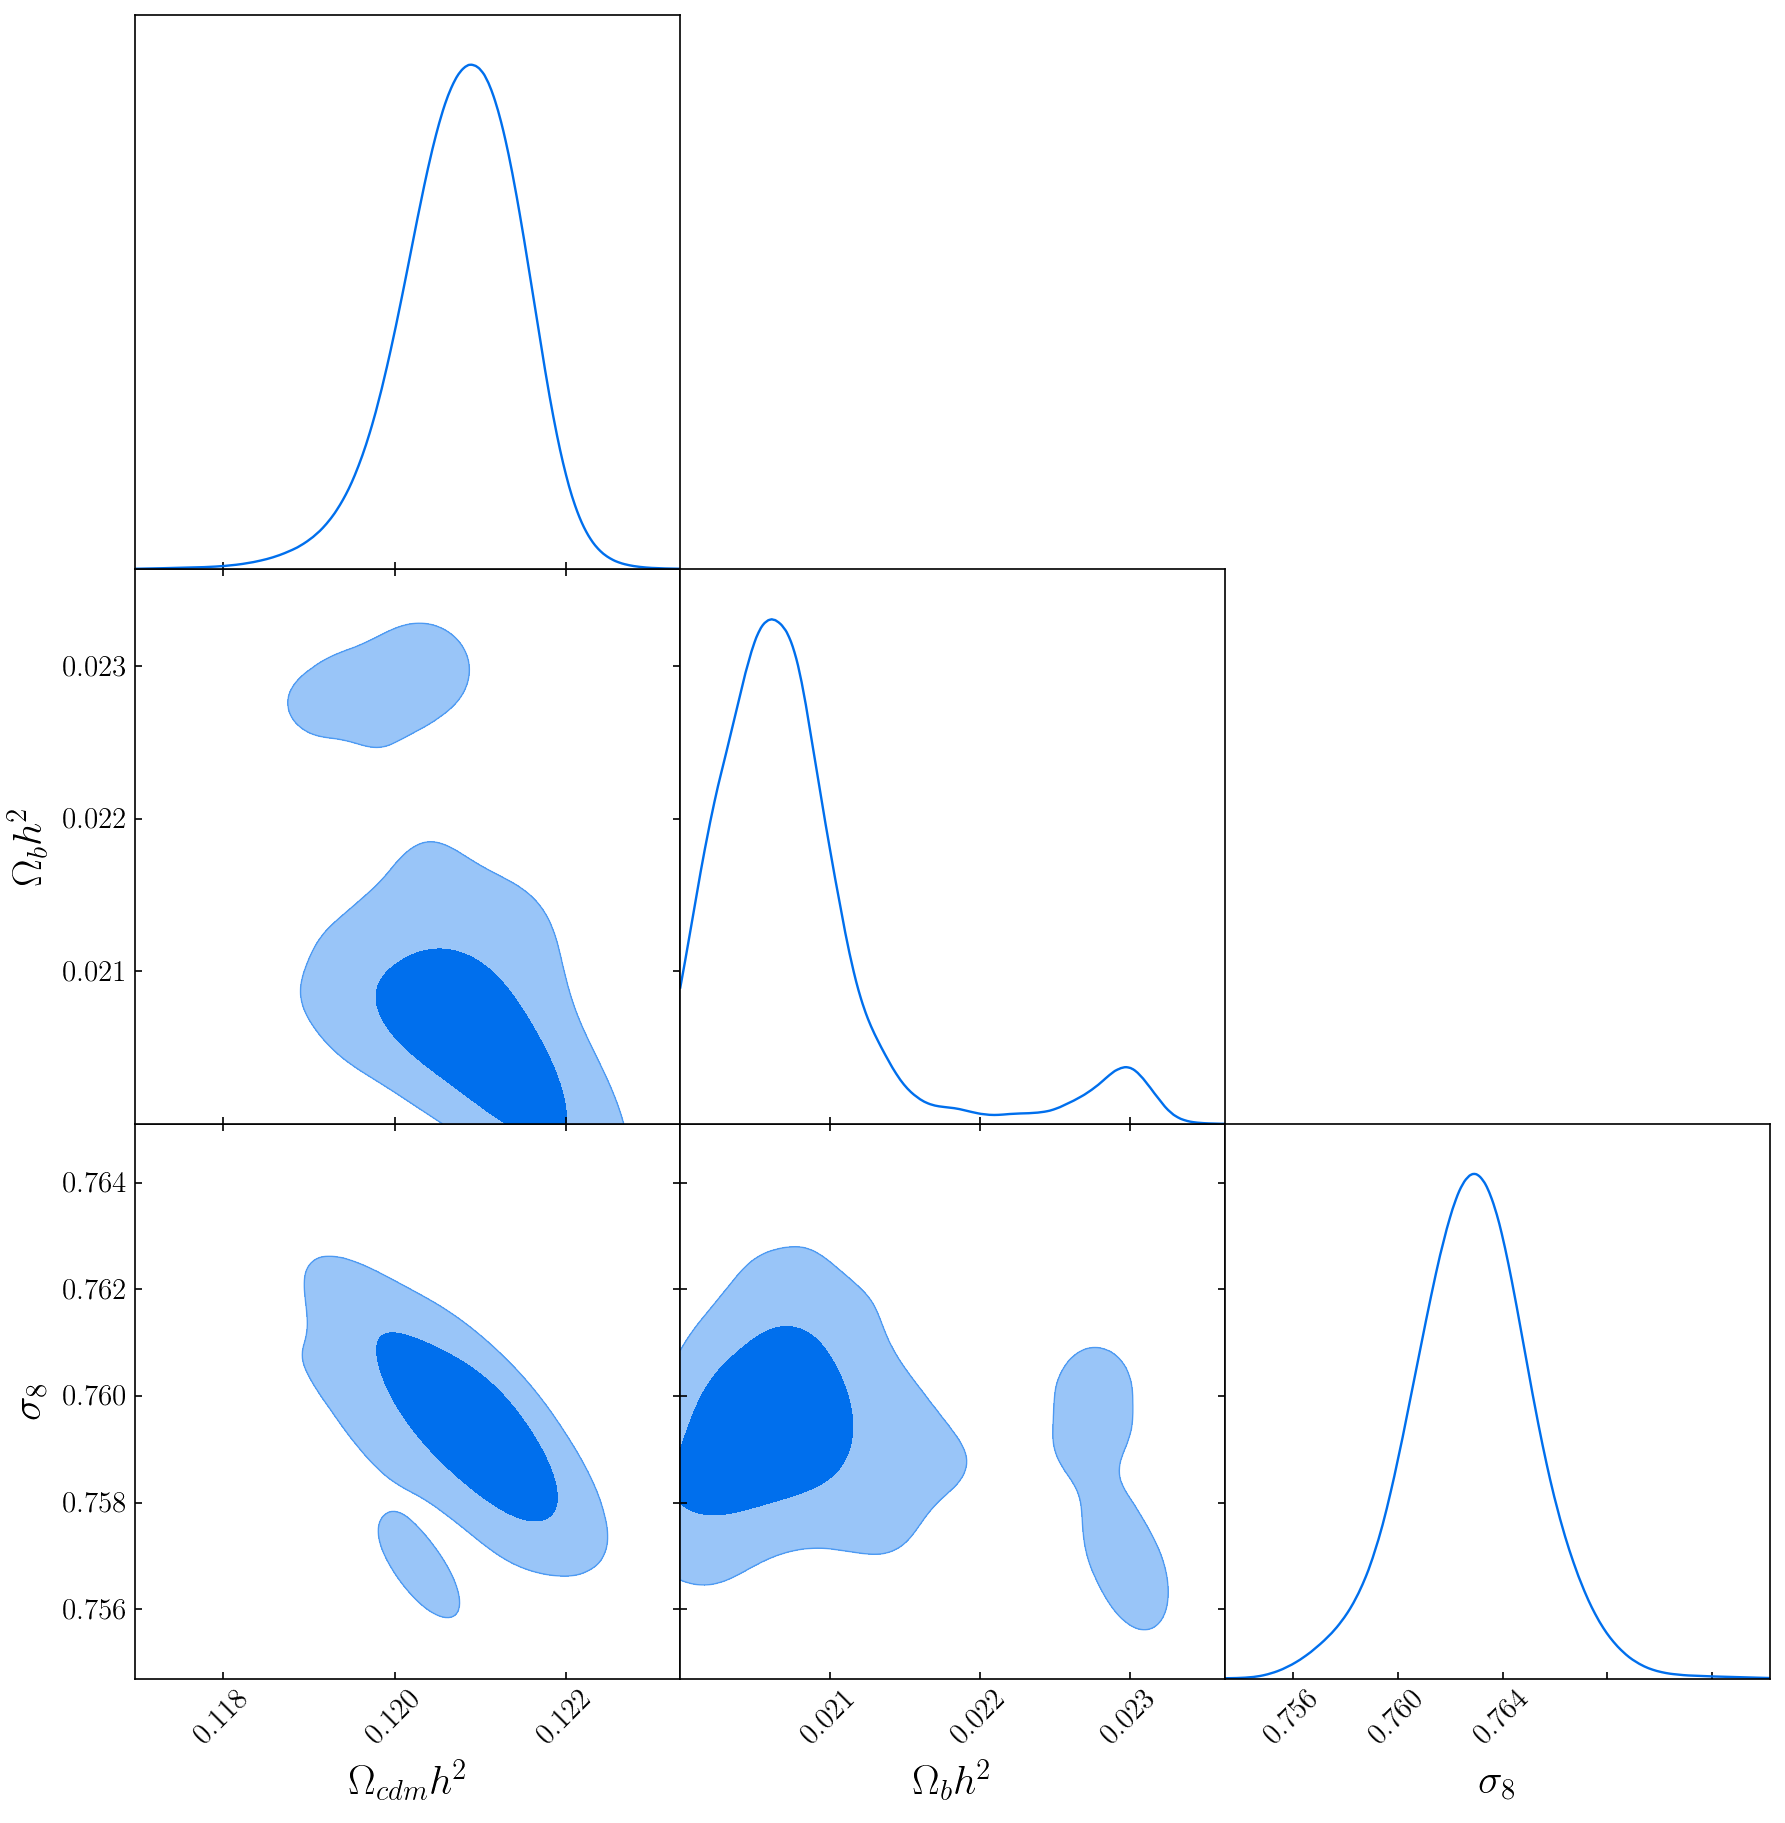

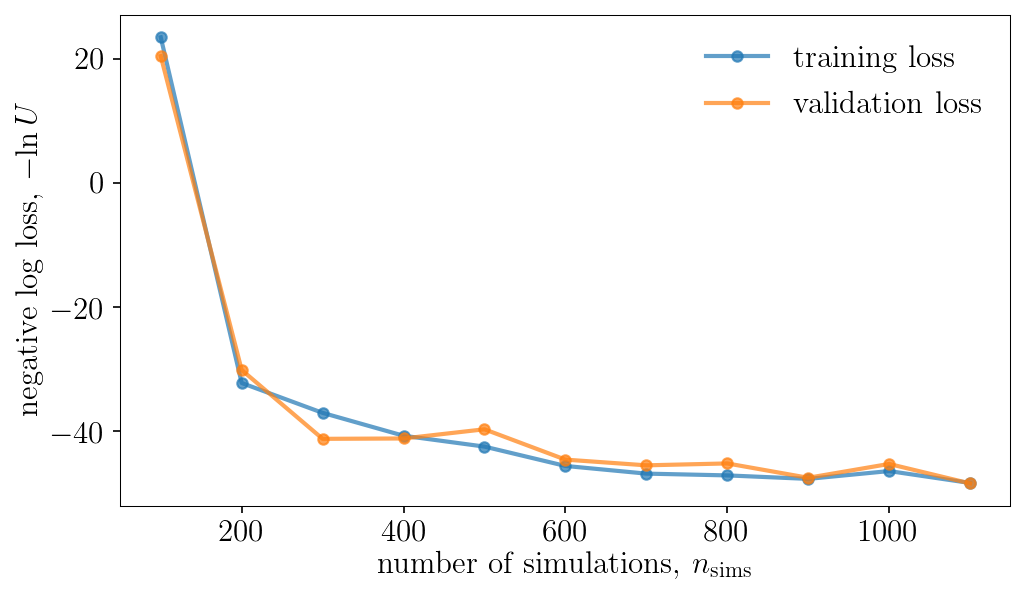

In [26]:
DelfiEnsemble0.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

## Sample the learned posterior

In [27]:
x0 = DelfiEnsemble0.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble0.posterior_samples)), 
                                                       p=DelfiEnsemble0.posterior_weights.astype(np.float32)/sum(DelfiEnsemble0.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble0.nwalkers),:]
posterior_samples_0, posterior_weights_0, log_prob_0 = DelfiEnsemble0.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


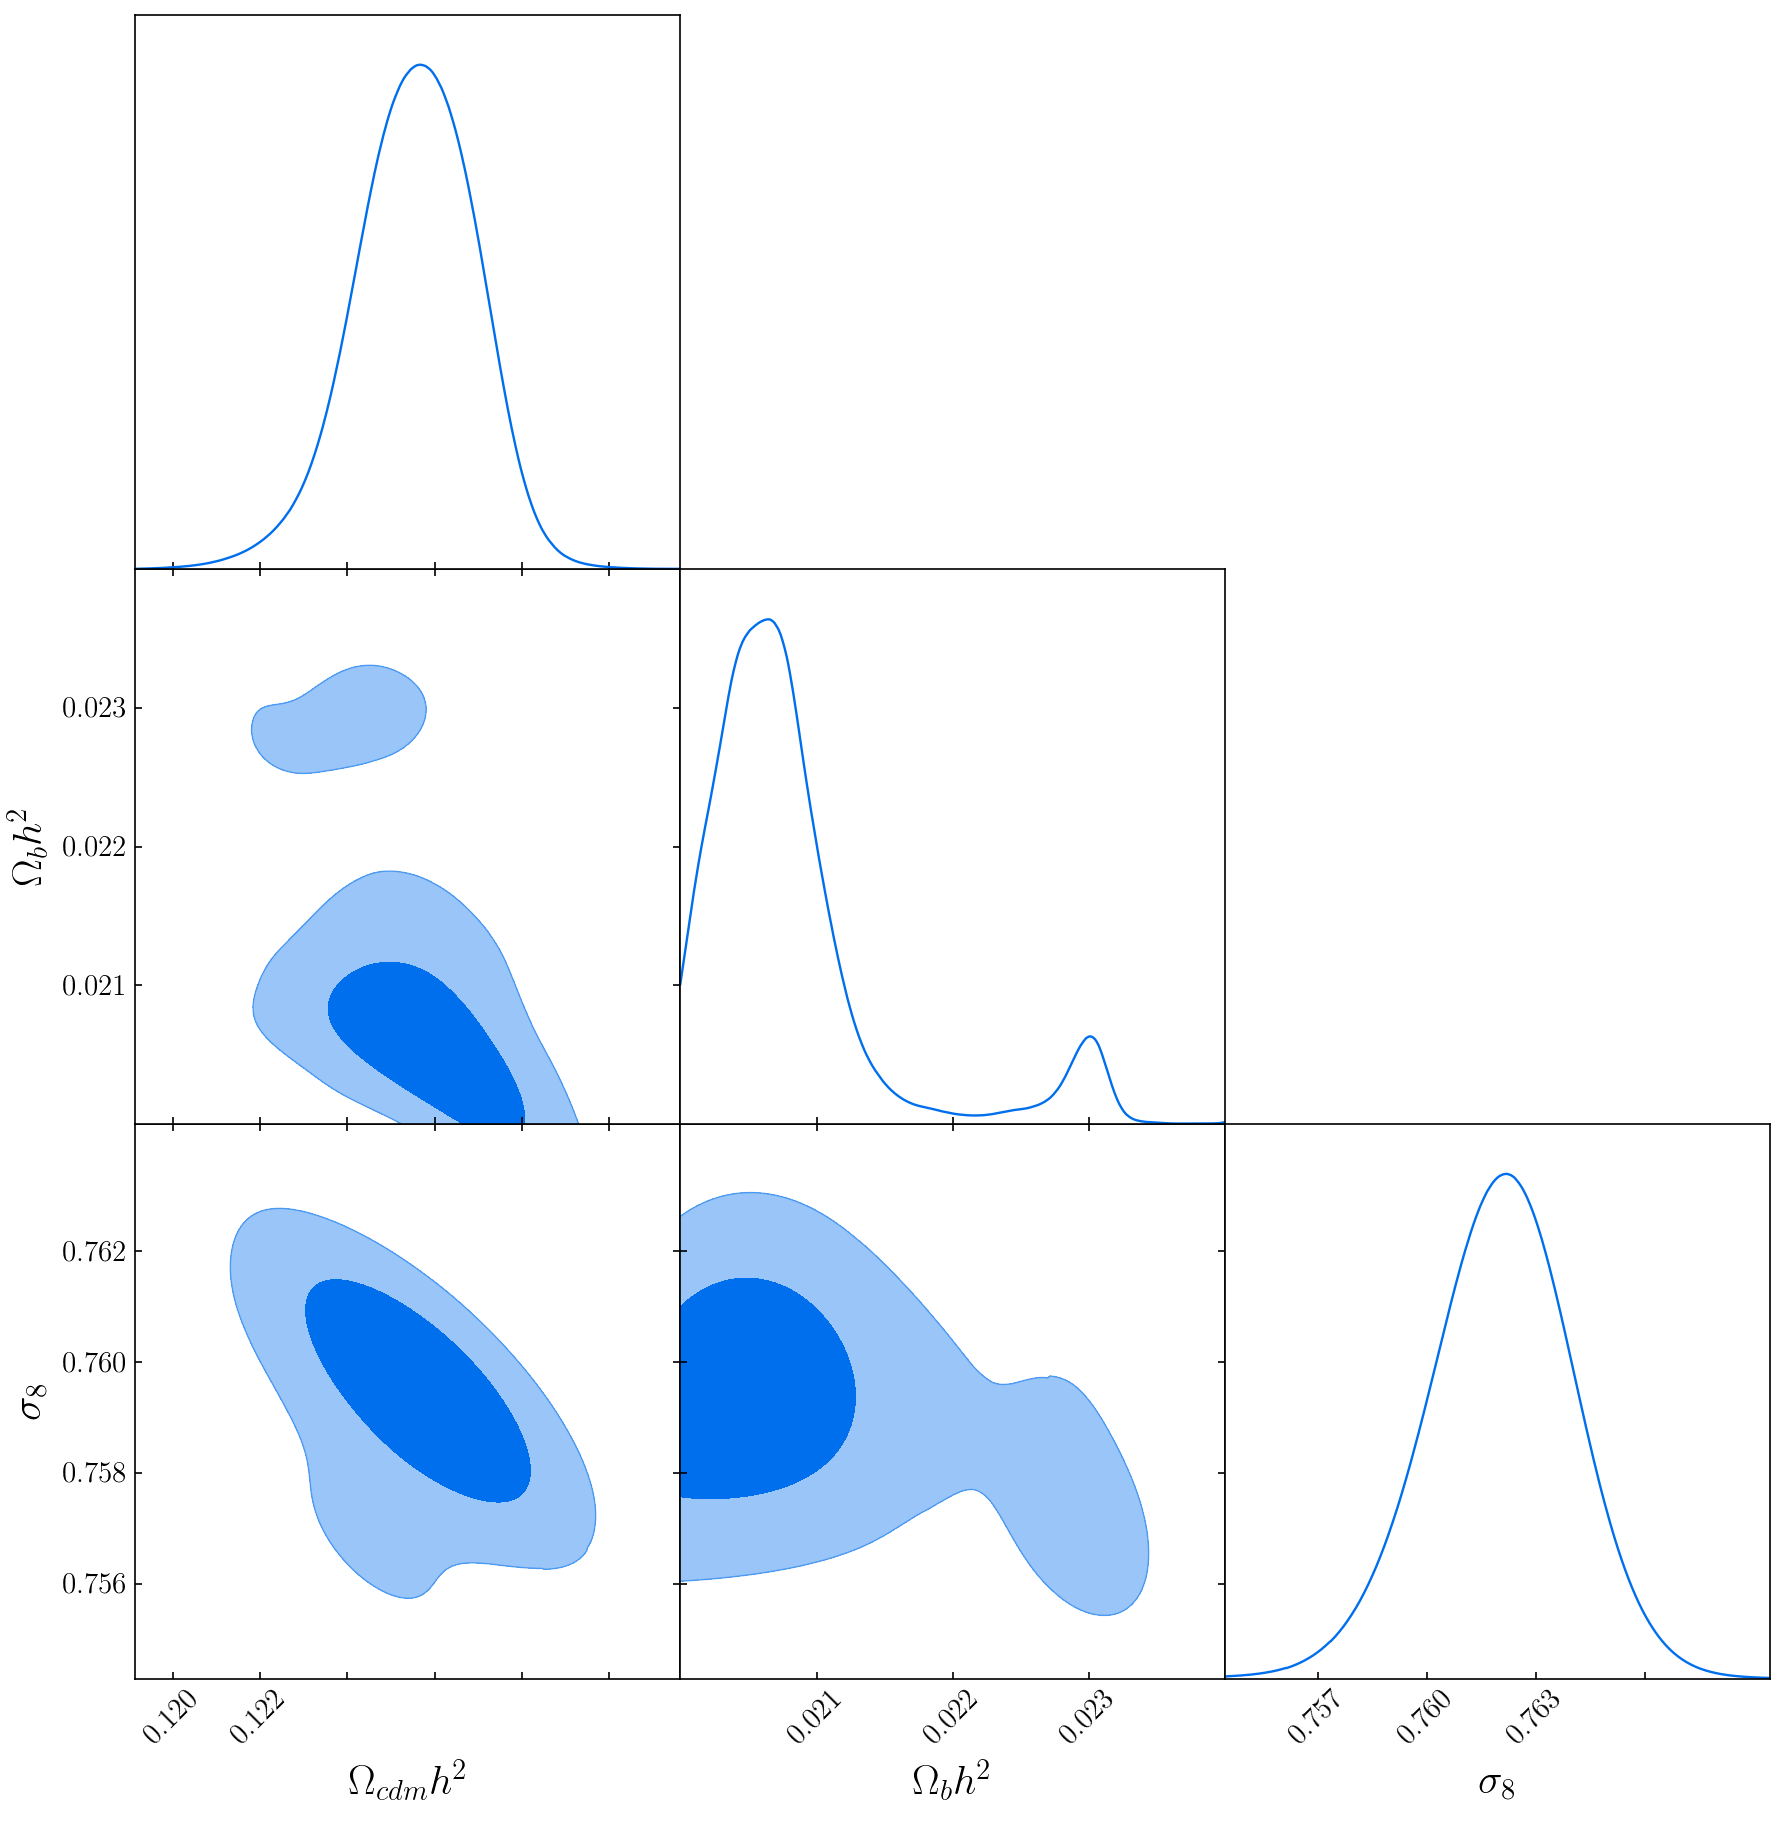

In [28]:
DelfiEnsemble0.triangle_plot(samples=[posterior_samples_0], weights=[posterior_weights_0])

In [29]:
def weighted_params(posterior_samples, posterior_weights):
    results_means = np.average(posterior_samples, axis =0, weights = posterior_weights)
    
    # https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel
    M_nonzero = len(np.nonzero(posterior_weights)[0])
    numerator = np.sum(((posterior_samples - results_means)**2)*posterior_weights.reshape((posterior_samples.shape[0], 1)), axis = 0)
    denominator = (M_nonzero-1)*np.sum(posterior_weights)/M_nonzero
    
    results_stdev = np.sqrt(numerator/denominator)
    
    return results_means, results_stdev

In [30]:
results_means_0, results_stdev_0 = weighted_params(posterior_samples_0, posterior_weights_0)
print('fiducial params' + str(theta_fiducial))
print(results_means_0)
print(results_stdev_0)

fiducial params[0.1197  0.02222 0.76   ]
[0.1207776  0.02083429 0.75936083]
[0.00070161 0.00070269 0.0012498 ]


In [31]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means_0 - 2*results_stdev_0)[0]) + ', ' + str((results_means_0 + 2*results_stdev_0)[0]), ']')
print('On \omega_b: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')
print('On \sigma_8: [' + str((results_means_0 - 2*results_stdev_0)[2]) + ', ' + str((results_means_0 + 2*results_stdev_0)[2]), ']')

Upper and lower 2\sigma-limits:
On \omega_cdm: [0.11937437509957723, 0.12218082382252389 ]
On \omega_b: [0.01942891840388738, 0.022239671018569482 ]
On \sigma_8: [0.7568612252835873, 0.7618604434557836 ]


## Attempt #2

In [36]:
DelfiEnsemble = delfi.Delfi(N_counts_data, prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_tinker_2000sims/")
 


In [37]:
n_initial = 100 
n_batch = 100 
n_populations = 20

Sampling approximate posterior...
Done.
Removed no burn in


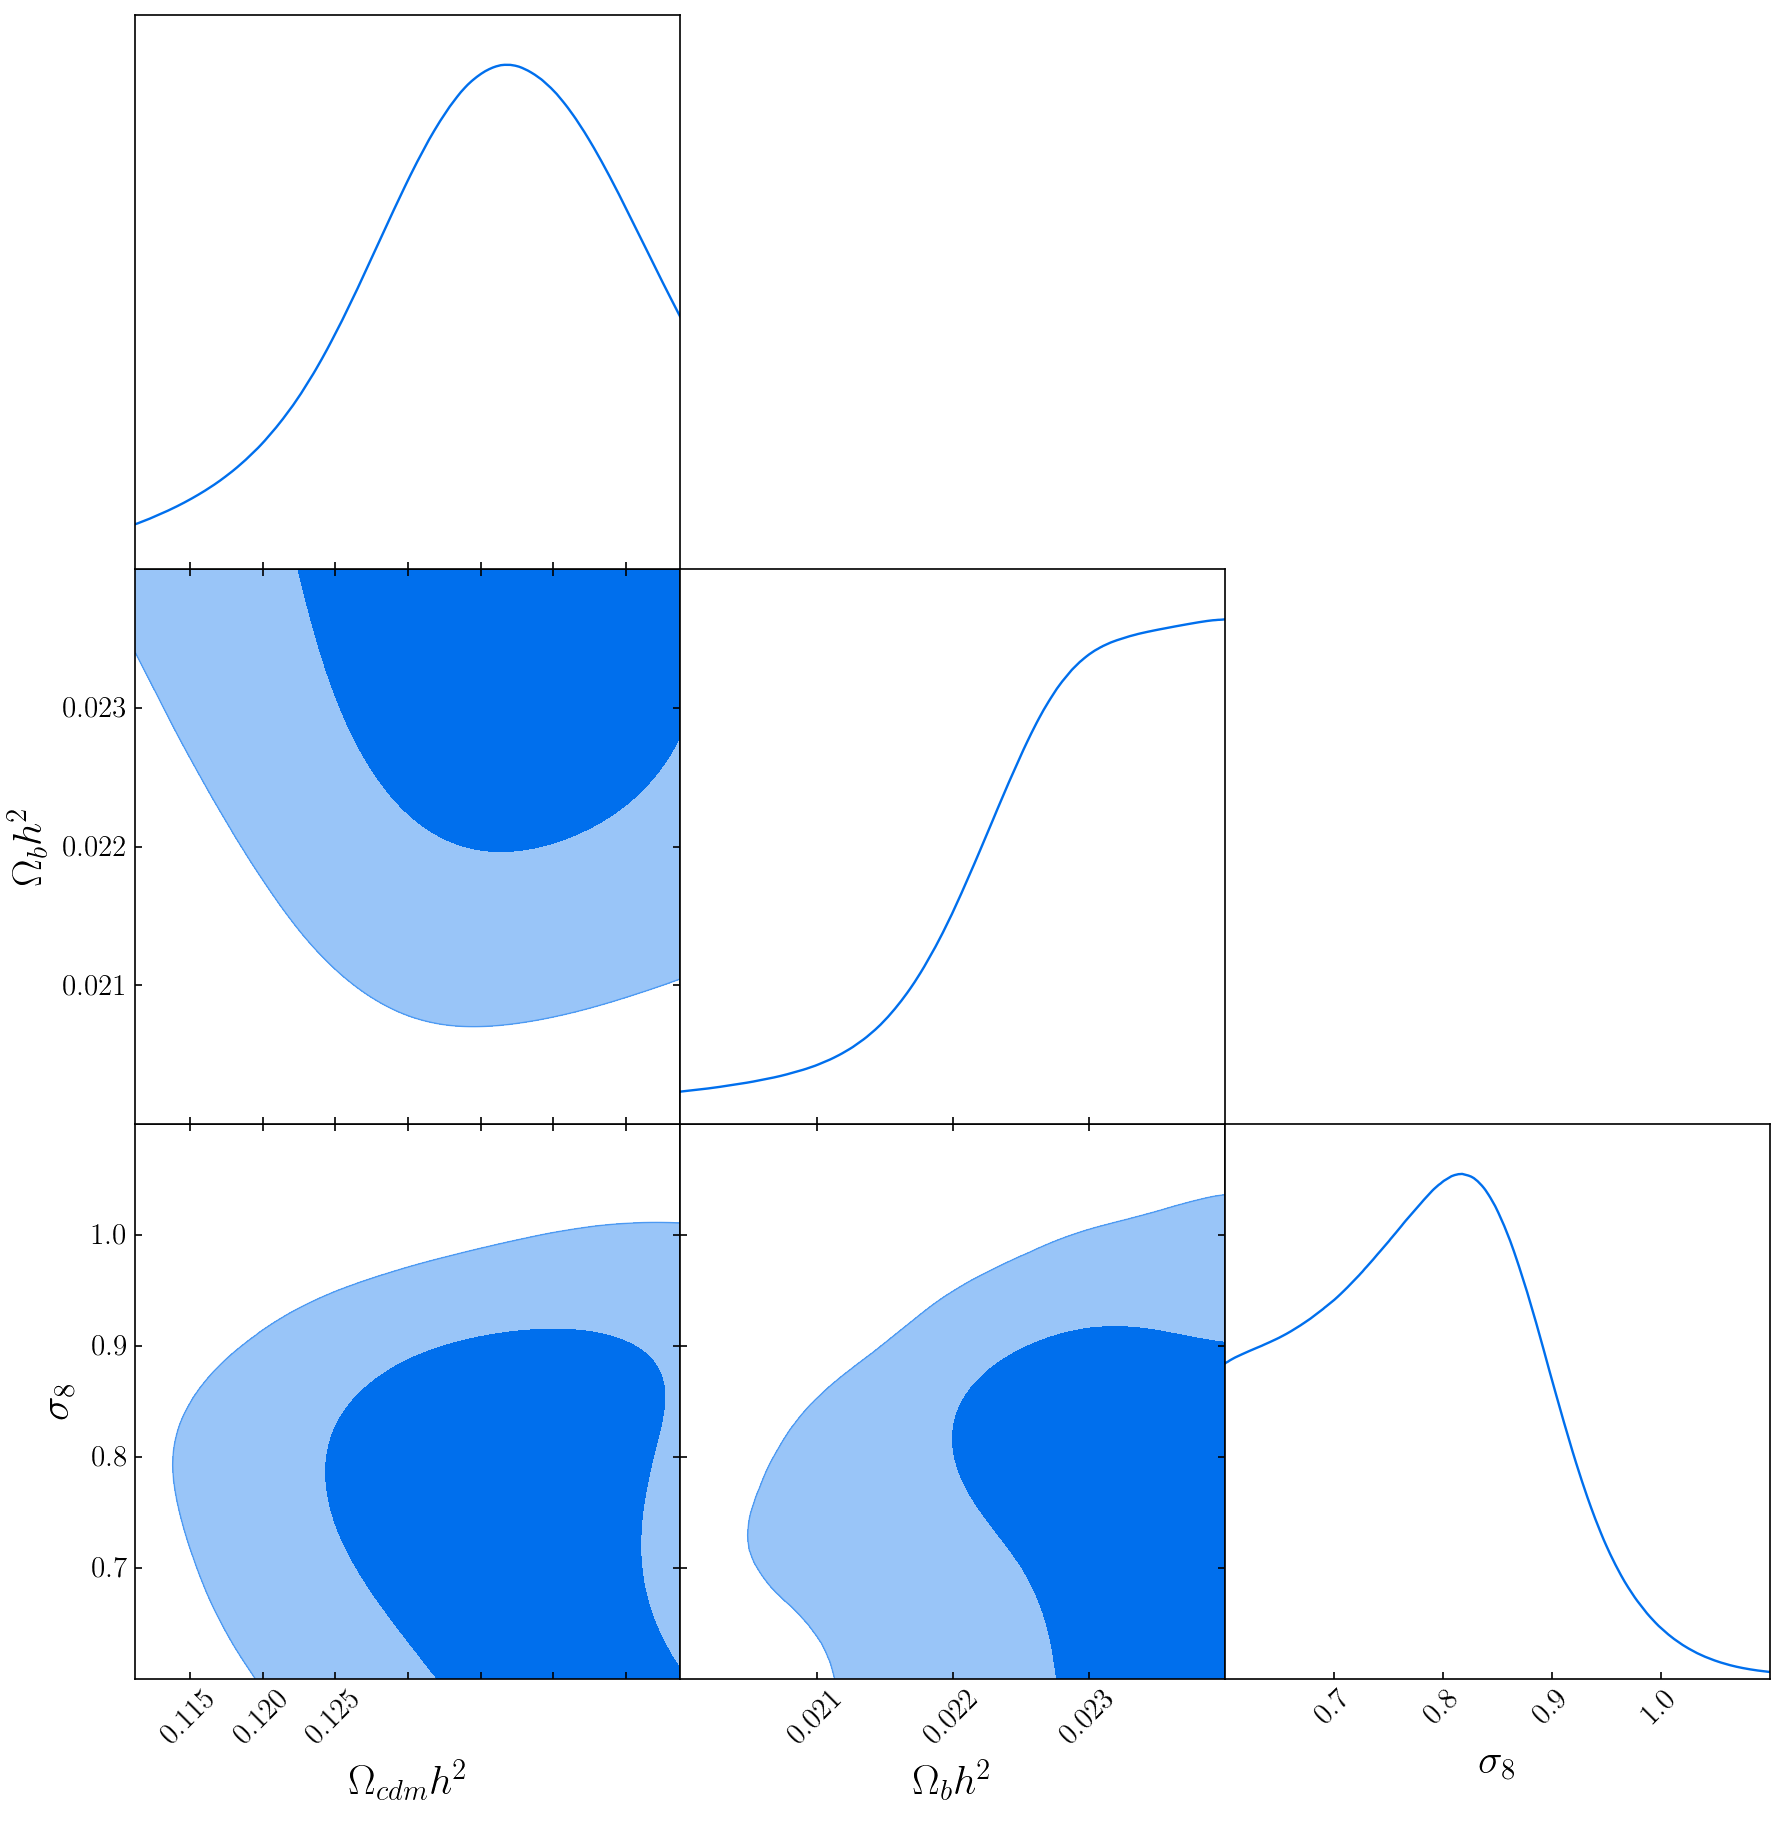

Population 1/20
Sampling proposal density...
Done.


In [ ]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)